### Cab-Driver Agent

In [39]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [40]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
print("\nData shape:\n", np.shape(Time_matrix))
print("dimensions = ",len(Time_matrix.shape))


Data shape:
 (5, 5, 24, 7)
dimensions =  4


In [41]:
 # Call the environment
env = CabDriver()

#### Tracking the state-action pairs for checking convergence


In [42]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [43]:
class DQNAgent:
    def __init__(self, state_size, action_size,learning_rate):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        #self.discount_factor =0.9
        self.discount_factor =0.95

        #self.learning_rate =0.001
        #self.learning_rate = 0.01
        self.learning_rate = learning_rate

        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay =  .995
        #self.epsilon_decay = -0.0005
        self.epsilon_decay =  .999
        #self.epsilon_min = 0.001
        self.epsilon_min = 0.00001

        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state,env):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        possible_actions_index,actions = env.requests(state) # Find possible action indexes and append 0
        possible_actions_index.append(0)
        if np.random.rand() <= self.epsilon:
            return random.sample(possible_actions_index,1)[0]
        else:
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            # Give action with max q_value only amongst possible action
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]    
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,env):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(done_boolean)
                update_output[i] = next_state
                
                # Write your code from here
                
            # 1. Predict the target from earlier model           
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # Find possible actions from next state
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    # Only take the max q_value from valid actions from next state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                
                
        # 4. Fit your model and track the loss values
            #print("Training Model")
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            #print("Model Training Model")
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)

In [44]:
Episodes = 8000

### DQN block

In [45]:
#Under Test
learning_rate = 0.01
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [2, 7, 6]
episode 0, reward -324.0, memory_length 145, epsilon 0.999, time 724.0, rides 144
Initial State is  [2, 7, 6]
episode 1, reward -212.0, memory_length 279, epsilon 0.998001, time 726.0, rides 133
Initial State is  [2, 7, 6]
episode 2, reward -405.0, memory_length 395, epsilon 0.997002999, time 728.0, rides 115
Initial State is  [2, 7, 6]
episode 3, reward -82.0, memory_length 520, epsilon 0.996005996001, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 4, reward -102.0, memory_length 653, epsilon 0.995009990004999, time 733.0, rides 132
Initial State is  [2, 7, 6]
episode 5, reward -307.0, memory_length 774, epsilon 0.994014980014994, time 732.0, rides 120
Initial State is  [2, 7, 6]
episode 6, reward -258.0, memory_length 890, epsilon 0.993020965034979, time 731.0, rides 115
Initial State is  [2, 7, 6]
episode 7, reward -182.0, memory_length 1018, epsilon 0.9920279440699441, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 8, reward -132.0,

episode 66, reward -329.0, memory_length 2000, epsilon 0.9351638519212846, time 731.0, rides 137
Initial State is  [2, 7, 6]
episode 67, reward -246.0, memory_length 2000, epsilon 0.9342286880693633, time 729.0, rides 106
Initial State is  [2, 7, 6]
episode 68, reward -78.0, memory_length 2000, epsilon 0.933294459381294, time 735.0, rides 125
Initial State is  [2, 7, 6]
episode 69, reward 39.0, memory_length 2000, epsilon 0.9323611649219127, time 727.0, rides 129
Initial State is  [2, 7, 6]
episode 70, reward -57.0, memory_length 2000, epsilon 0.9314288037569908, time 721.0, rides 117
Initial State is  [2, 7, 6]
episode 71, reward -292.0, memory_length 2000, epsilon 0.9304973749532338, time 736.0, rides 119
Initial State is  [2, 7, 6]
episode 72, reward -92.0, memory_length 2000, epsilon 0.9295668775782806, time 731.0, rides 124
Initial State is  [2, 7, 6]
episode 73, reward -459.0, memory_length 2000, epsilon 0.9286373107007023, time 730.0, rides 124
Initial State is  [2, 7, 6]
episod

episode 132, reward 102.0, memory_length 2000, epsilon 0.8754068367770318, time 722.0, rides 139
Initial State is  [2, 7, 6]
episode 133, reward 88.0, memory_length 2000, epsilon 0.8745314299402548, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 134, reward -40.0, memory_length 2000, epsilon 0.8736568985103146, time 737.0, rides 123
Initial State is  [2, 7, 6]
episode 135, reward -296.0, memory_length 2000, epsilon 0.8727832416118043, time 741.0, rides 123
Initial State is  [2, 7, 6]
episode 136, reward 5.0, memory_length 2000, epsilon 0.8719104583701925, time 736.0, rides 124
Initial State is  [2, 7, 6]
episode 137, reward -57.0, memory_length 2000, epsilon 0.8710385479118223, time 734.0, rides 127
Initial State is  [2, 7, 6]
episode 138, reward -11.0, memory_length 2000, epsilon 0.8701675093639105, time 729.0, rides 144
Initial State is  [2, 7, 6]
episode 139, reward -194.0, memory_length 2000, epsilon 0.8692973418545467, time 734.0, rides 120
Initial State is  [2, 7, 6]
e

episode 198, reward -236.0, memory_length 2000, epsilon 0.8194682977764125, time 729.0, rides 116
Initial State is  [2, 7, 6]
episode 199, reward -10.0, memory_length 2000, epsilon 0.818648829478636, time 732.0, rides 134
Initial State is  [2, 7, 6]
episode 200, reward -81.0, memory_length 2000, epsilon 0.8178301806491574, time 728.0, rides 127
Initial State is  [2, 7, 6]
episode 201, reward -290.0, memory_length 2000, epsilon 0.8170123504685082, time 725.0, rides 131
Initial State is  [2, 7, 6]
episode 202, reward -54.0, memory_length 2000, epsilon 0.8161953381180397, time 734.0, rides 134
Initial State is  [2, 7, 6]
episode 203, reward 12.0, memory_length 2000, epsilon 0.8153791427799216, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 204, reward -163.0, memory_length 2000, epsilon 0.8145637636371417, time 733.0, rides 115
Initial State is  [2, 7, 6]
episode 205, reward -45.0, memory_length 2000, epsilon 0.8137491998735046, time 731.0, rides 125
Initial State is  [2, 7, 6]

episode 264, reward 94.0, memory_length 2000, epsilon 0.7671042341100781, time 733.0, rides 135
Initial State is  [2, 7, 6]
episode 265, reward -343.0, memory_length 2000, epsilon 0.766337129875968, time 732.0, rides 121
Initial State is  [2, 7, 6]
episode 266, reward -170.0, memory_length 2000, epsilon 0.7655707927460921, time 732.0, rides 131
Initial State is  [2, 7, 6]
episode 267, reward 41.0, memory_length 2000, epsilon 0.764805221953346, time 723.0, rides 130
Initial State is  [2, 7, 6]
episode 268, reward -83.0, memory_length 2000, epsilon 0.7640404167313927, time 729.0, rides 126
Initial State is  [2, 7, 6]
episode 269, reward 156.0, memory_length 2000, epsilon 0.7632763763146613, time 735.0, rides 132
Initial State is  [2, 7, 6]
episode 270, reward 70.0, memory_length 2000, epsilon 0.7625130999383466, time 736.0, rides 137
Initial State is  [2, 7, 6]
episode 271, reward -173.0, memory_length 2000, epsilon 0.7617505868384082, time 730.0, rides 123
Initial State is  [2, 7, 6]
ep

episode 330, reward -58.0, memory_length 2000, epsilon 0.7180862366321393, time 734.0, rides 121
Initial State is  [2, 7, 6]
episode 331, reward 9.0, memory_length 2000, epsilon 0.7173681503955072, time 738.0, rides 132
Initial State is  [2, 7, 6]
episode 332, reward -111.0, memory_length 2000, epsilon 0.7166507822451117, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 333, reward -14.0, memory_length 2000, epsilon 0.7159341314628666, time 732.0, rides 131
Initial State is  [2, 7, 6]
episode 334, reward -210.0, memory_length 2000, epsilon 0.7152181973314037, time 734.0, rides 141
Initial State is  [2, 7, 6]
episode 335, reward 171.0, memory_length 2000, epsilon 0.7145029791340722, time 734.0, rides 126
Initial State is  [2, 7, 6]
episode 336, reward -139.0, memory_length 2000, epsilon 0.7137884761549381, time 737.0, rides 133
Initial State is  [2, 7, 6]
episode 337, reward -37.0, memory_length 2000, epsilon 0.7130746876787832, time 732.0, rides 125
Initial State is  [2, 7, 6]

episode 396, reward -92.0, memory_length 2000, epsilon 0.6722004915521225, time 723.0, rides 130
Initial State is  [2, 7, 6]
episode 397, reward 214.0, memory_length 2000, epsilon 0.6715282910605703, time 732.0, rides 122
Initial State is  [2, 7, 6]
episode 398, reward 196.0, memory_length 2000, epsilon 0.6708567627695098, time 725.0, rides 125
Initial State is  [2, 7, 6]
episode 399, reward -106.0, memory_length 2000, epsilon 0.6701859060067403, time 742.0, rides 106
Initial State is  [2, 7, 6]
episode 400, reward -96.0, memory_length 2000, epsilon 0.6695157201007336, time 728.0, rides 134
Initial State is  [2, 7, 6]
episode 401, reward 142.0, memory_length 2000, epsilon 0.6688462043806328, time 726.0, rides 143
Initial State is  [2, 7, 6]
episode 402, reward -12.0, memory_length 2000, epsilon 0.6681773581762521, time 731.0, rides 125
Initial State is  [2, 7, 6]
episode 403, reward 216.0, memory_length 2000, epsilon 0.6675091808180759, time 728.0, rides 125
Initial State is  [2, 7, 6]

episode 462, reward -26.0, memory_length 2000, epsilon 0.6292468477910546, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 463, reward -24.0, memory_length 2000, epsilon 0.6286176009432635, time 729.0, rides 116
Initial State is  [2, 7, 6]
episode 464, reward 338.0, memory_length 2000, epsilon 0.6279889833423202, time 733.0, rides 132
Initial State is  [2, 7, 6]
episode 465, reward 163.0, memory_length 2000, epsilon 0.6273609943589779, time 724.0, rides 124
Initial State is  [2, 7, 6]
episode 466, reward 155.0, memory_length 2000, epsilon 0.6267336333646188, time 725.0, rides 124
Initial State is  [2, 7, 6]
episode 467, reward 109.0, memory_length 2000, epsilon 0.6261068997312542, time 727.0, rides 123
Initial State is  [2, 7, 6]
episode 468, reward 154.0, memory_length 2000, epsilon 0.6254807928315229, time 734.0, rides 128
Initial State is  [2, 7, 6]
episode 469, reward 38.0, memory_length 2000, epsilon 0.6248553120386914, time 733.0, rides 123
Initial State is  [2, 7, 6]
e

episode 528, reward 140.0, memory_length 2000, epsilon 0.5890379439335424, time 735.0, rides 125
Initial State is  [2, 7, 6]
episode 529, reward -168.0, memory_length 2000, epsilon 0.5884489059896089, time 727.0, rides 132
Initial State is  [2, 7, 6]
episode 530, reward 126.0, memory_length 2000, epsilon 0.5878604570836192, time 726.0, rides 117
Initial State is  [2, 7, 6]
episode 531, reward 240.0, memory_length 2000, epsilon 0.5872725966265356, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 532, reward 89.0, memory_length 2000, epsilon 0.5866853240299091, time 722.0, rides 123
Initial State is  [2, 7, 6]
episode 533, reward 148.0, memory_length 2000, epsilon 0.5860986387058792, time 729.0, rides 123
Initial State is  [2, 7, 6]
episode 534, reward 221.0, memory_length 2000, epsilon 0.5855125400671733, time 729.0, rides 134
Initial State is  [2, 7, 6]
episode 535, reward 342.0, memory_length 2000, epsilon 0.5849270275271061, time 731.0, rides 121
Initial State is  [2, 7, 6]


episode 594, reward 298.0, memory_length 2000, epsilon 0.5513983909676525, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 595, reward 231.0, memory_length 2000, epsilon 0.5508469925766849, time 726.0, rides 134
Initial State is  [2, 7, 6]
episode 596, reward -21.0, memory_length 2000, epsilon 0.5502961455841082, time 740.0, rides 119
Initial State is  [2, 7, 6]
episode 597, reward 219.0, memory_length 2000, epsilon 0.5497458494385241, time 724.0, rides 138
Initial State is  [2, 7, 6]
episode 598, reward -113.0, memory_length 2000, epsilon 0.5491961035890855, time 732.0, rides 119
Initial State is  [2, 7, 6]
episode 599, reward 271.0, memory_length 2000, epsilon 0.5486469074854965, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 600, reward 35.0, memory_length 2000, epsilon 0.548098260578011, time 725.0, rides 143
Initial State is  [2, 7, 6]
episode 601, reward 115.0, memory_length 2000, epsilon 0.547550162317433, time 729.0, rides 125
Initial State is  [2, 7, 6]
ep

episode 660, reward 280.0, memory_length 2000, epsilon 0.5161640072477562, time 724.0, rides 133
Initial State is  [2, 7, 6]
episode 661, reward 368.0, memory_length 2000, epsilon 0.5156478432405085, time 723.0, rides 110
Initial State is  [2, 7, 6]
episode 662, reward 425.0, memory_length 2000, epsilon 0.515132195397268, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 663, reward 212.0, memory_length 2000, epsilon 0.5146170632018707, time 725.0, rides 135
Initial State is  [2, 7, 6]
episode 664, reward 82.0, memory_length 2000, epsilon 0.5141024461386688, time 722.0, rides 117
Initial State is  [2, 7, 6]
episode 665, reward 47.0, memory_length 2000, epsilon 0.5135883436925301, time 726.0, rides 128
Initial State is  [2, 7, 6]
episode 666, reward 347.0, memory_length 2000, epsilon 0.5130747553488376, time 738.0, rides 125
Initial State is  [2, 7, 6]
episode 667, reward 310.0, memory_length 2000, epsilon 0.5125616805934888, time 727.0, rides 125
Initial State is  [2, 7, 6]
epi

episode 726, reward 127.0, memory_length 2000, epsilon 0.4831811023432807, time 735.0, rides 119
Initial State is  [2, 7, 6]
episode 727, reward 185.0, memory_length 2000, epsilon 0.4826979212409374, time 724.0, rides 128
Initial State is  [2, 7, 6]
episode 728, reward 503.0, memory_length 2000, epsilon 0.48221522331969646, time 725.0, rides 119
Initial State is  [2, 7, 6]
episode 729, reward 39.0, memory_length 2000, epsilon 0.48173300809637676, time 730.0, rides 121
Initial State is  [2, 7, 6]
episode 730, reward 200.0, memory_length 2000, epsilon 0.48125127508828036, time 735.0, rides 129
Initial State is  [2, 7, 6]
episode 731, reward 384.0, memory_length 2000, epsilon 0.48077002381319206, time 726.0, rides 116
Initial State is  [2, 7, 6]
episode 732, reward 362.0, memory_length 2000, epsilon 0.48028925378937887, time 727.0, rides 116
Initial State is  [2, 7, 6]
episode 733, reward 245.0, memory_length 2000, epsilon 0.47980896453558947, time 731.0, rides 131
Initial State is  [2, 7

episode 792, reward 243.0, memory_length 2000, epsilon 0.4523058066495642, time 726.0, rides 129
Initial State is  [2, 7, 6]
episode 793, reward 280.0, memory_length 2000, epsilon 0.45185350084291465, time 734.0, rides 126
Initial State is  [2, 7, 6]
episode 794, reward 73.0, memory_length 2000, epsilon 0.4514016473420717, time 735.0, rides 128
Initial State is  [2, 7, 6]
episode 795, reward 212.0, memory_length 2000, epsilon 0.45095024569472963, time 734.0, rides 127
Initial State is  [2, 7, 6]
episode 796, reward 167.0, memory_length 2000, epsilon 0.4504992954490349, time 736.0, rides 108
Initial State is  [2, 7, 6]
episode 797, reward 106.0, memory_length 2000, epsilon 0.45004879615358584, time 728.0, rides 112
Initial State is  [2, 7, 6]
episode 798, reward 436.0, memory_length 2000, epsilon 0.44959874735743227, time 733.0, rides 118
Initial State is  [2, 7, 6]
episode 799, reward 24.0, memory_length 2000, epsilon 0.4491491486100748, time 732.0, rides 124
Initial State is  [2, 7, 6

episode 858, reward 427.0, memory_length 2000, epsilon 0.4234034438366067, time 727.0, rides 121
Initial State is  [2, 7, 6]
episode 859, reward 435.0, memory_length 2000, epsilon 0.4229800403927701, time 723.0, rides 132
Initial State is  [2, 7, 6]
episode 860, reward 432.0, memory_length 2000, epsilon 0.42255706035237733, time 724.0, rides 122
Initial State is  [2, 7, 6]
episode 861, reward 302.0, memory_length 2000, epsilon 0.42213450329202495, time 730.0, rides 126
Initial State is  [2, 7, 6]
episode 862, reward 194.0, memory_length 2000, epsilon 0.4217123687887329, time 741.0, rides 125
Initial State is  [2, 7, 6]
episode 863, reward 229.0, memory_length 2000, epsilon 0.4212906564199442, time 734.0, rides 117
Initial State is  [2, 7, 6]
episode 864, reward 234.0, memory_length 2000, epsilon 0.42086936576352424, time 732.0, rides 124
Initial State is  [2, 7, 6]
episode 865, reward 299.0, memory_length 2000, epsilon 0.4204484963977607, time 727.0, rides 131
Initial State is  [2, 7, 

episode 924, reward 253.0, memory_length 2000, epsilon 0.3963479433983767, time 732.0, rides 133
Initial State is  [2, 7, 6]
episode 925, reward 150.0, memory_length 2000, epsilon 0.3959515954549783, time 728.0, rides 120
Initial State is  [2, 7, 6]
episode 926, reward 560.0, memory_length 2000, epsilon 0.39555564385952335, time 724.0, rides 127
Initial State is  [2, 7, 6]
episode 927, reward 432.0, memory_length 2000, epsilon 0.39516008821566384, time 727.0, rides 128
Initial State is  [2, 7, 6]
episode 928, reward 163.0, memory_length 2000, epsilon 0.3947649281274482, time 724.0, rides 123
Initial State is  [2, 7, 6]
episode 929, reward 569.0, memory_length 2000, epsilon 0.3943701631993207, time 734.0, rides 141
Initial State is  [2, 7, 6]
episode 930, reward 441.0, memory_length 2000, epsilon 0.3939757930361214, time 737.0, rides 136
Initial State is  [2, 7, 6]
episode 931, reward 358.0, memory_length 2000, epsilon 0.3935818172430853, time 724.0, rides 134
Initial State is  [2, 7, 6

episode 990, reward 448.0, memory_length 2000, epsilon 0.37102129074024554, time 725.0, rides 134
Initial State is  [2, 7, 6]
episode 991, reward 410.0, memory_length 2000, epsilon 0.3706502694495053, time 728.0, rides 139
Initial State is  [2, 7, 6]
episode 992, reward 356.0, memory_length 2000, epsilon 0.3702796191800558, time 731.0, rides 122
Initial State is  [2, 7, 6]
episode 993, reward 201.0, memory_length 2000, epsilon 0.36990933956087574, time 731.0, rides 113
Initial State is  [2, 7, 6]
episode 994, reward 495.0, memory_length 2000, epsilon 0.36953943022131486, time 725.0, rides 136
Initial State is  [2, 7, 6]
episode 995, reward 482.0, memory_length 2000, epsilon 0.3691698907910935, time 730.0, rides 141
Initial State is  [2, 7, 6]
episode 996, reward 410.0, memory_length 2000, epsilon 0.3688007209003024, time 727.0, rides 129
Initial State is  [2, 7, 6]
episode 997, reward 553.0, memory_length 2000, epsilon 0.36843192017940213, time 727.0, rides 122
Initial State is  [2, 7,

episode 1055, reward 168.0, memory_length 2000, epsilon 0.34766067307894, time 730.0, rides 129
Initial State is  [2, 7, 6]
episode 1056, reward 340.0, memory_length 2000, epsilon 0.34731301240586104, time 733.0, rides 134
Initial State is  [2, 7, 6]
episode 1057, reward 244.0, memory_length 2000, epsilon 0.3469656993934552, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 1058, reward 552.0, memory_length 2000, epsilon 0.3466187336940617, time 726.0, rides 130
Initial State is  [2, 7, 6]
episode 1059, reward 551.0, memory_length 2000, epsilon 0.34627211496036764, time 726.0, rides 122
Initial State is  [2, 7, 6]
episode 1060, reward 357.0, memory_length 2000, epsilon 0.3459258428454073, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 1061, reward 566.0, memory_length 2000, epsilon 0.34557991700256185, time 736.0, rides 121
Initial State is  [2, 7, 6]
episode 1062, reward 475.0, memory_length 2000, epsilon 0.3452343370855593, time 726.0, rides 131
Initial State is  [

episode 1120, reward 480.0, memory_length 2000, epsilon 0.325770910247633, time 734.0, rides 125
Initial State is  [2, 7, 6]
episode 1121, reward 450.0, memory_length 2000, epsilon 0.32544513933738534, time 727.0, rides 119
Initial State is  [2, 7, 6]
episode 1122, reward 467.0, memory_length 2000, epsilon 0.3251196941980479, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 1123, reward 628.0, memory_length 2000, epsilon 0.32479457450384985, time 725.0, rides 130
Initial State is  [2, 7, 6]
episode 1124, reward 753.0, memory_length 2000, epsilon 0.324469779929346, time 722.0, rides 123
Initial State is  [2, 7, 6]
episode 1125, reward 260.0, memory_length 2000, epsilon 0.32414531014941667, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 1126, reward 358.0, memory_length 2000, epsilon 0.32382116483926726, time 733.0, rides 128
Initial State is  [2, 7, 6]
episode 1127, reward 190.0, memory_length 2000, epsilon 0.323497343674428, time 723.0, rides 123
Initial State is  [

episode 1185, reward 991.0, memory_length 2000, epsilon 0.30525939279728115, time 732.0, rides 129
Initial State is  [2, 7, 6]
episode 1186, reward 306.0, memory_length 2000, epsilon 0.30495413340448385, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 1187, reward 329.0, memory_length 2000, epsilon 0.3046491792710794, time 733.0, rides 133
Initial State is  [2, 7, 6]
episode 1188, reward 675.0, memory_length 2000, epsilon 0.3043445300918083, time 727.0, rides 113
Initial State is  [2, 7, 6]
episode 1189, reward 610.0, memory_length 2000, epsilon 0.30404018556171647, time 732.0, rides 127
Initial State is  [2, 7, 6]
episode 1190, reward 696.0, memory_length 2000, epsilon 0.30373614537615473, time 726.0, rides 118
Initial State is  [2, 7, 6]
episode 1191, reward 536.0, memory_length 2000, epsilon 0.3034324092307786, time 725.0, rides 123
Initial State is  [2, 7, 6]
episode 1192, reward 641.0, memory_length 2000, epsilon 0.3031289768215478, time 735.0, rides 132
Initial State is

episode 1250, reward 826.0, memory_length 2000, epsilon 0.28603934224861294, time 733.0, rides 126
Initial State is  [2, 7, 6]
episode 1251, reward 449.0, memory_length 2000, epsilon 0.2857533029063643, time 725.0, rides 140
Initial State is  [2, 7, 6]
episode 1252, reward 688.0, memory_length 2000, epsilon 0.28546754960345794, time 725.0, rides 138
Initial State is  [2, 7, 6]
episode 1253, reward 1042.0, memory_length 2000, epsilon 0.2851820820538545, time 732.0, rides 120
Initial State is  [2, 7, 6]
episode 1254, reward 511.0, memory_length 2000, epsilon 0.2848968999718006, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 1255, reward 663.0, memory_length 2000, epsilon 0.2846120030718288, time 729.0, rides 112
Initial State is  [2, 7, 6]
episode 1256, reward 319.0, memory_length 2000, epsilon 0.284327391068757, time 726.0, rides 133
Initial State is  [2, 7, 6]
episode 1257, reward 513.0, memory_length 2000, epsilon 0.2840430636776882, time 730.0, rides 130
Initial State is  

episode 1315, reward 384.0, memory_length 2000, epsilon 0.268029443956713, time 735.0, rides 135
Initial State is  [2, 7, 6]
episode 1316, reward 477.0, memory_length 2000, epsilon 0.2677614145127563, time 725.0, rides 123
Initial State is  [2, 7, 6]
episode 1317, reward 625.0, memory_length 2000, epsilon 0.2674936530982436, time 731.0, rides 119
Initial State is  [2, 7, 6]
episode 1318, reward 577.0, memory_length 2000, epsilon 0.26722615944514533, time 729.0, rides 126
Initial State is  [2, 7, 6]
episode 1319, reward 643.0, memory_length 2000, epsilon 0.2669589332857002, time 729.0, rides 126
Initial State is  [2, 7, 6]
episode 1320, reward 606.0, memory_length 2000, epsilon 0.2666919743524145, time 730.0, rides 132
Initial State is  [2, 7, 6]
episode 1321, reward 224.0, memory_length 2000, epsilon 0.26642528237806207, time 722.0, rides 134
Initial State is  [2, 7, 6]
episode 1322, reward 875.0, memory_length 2000, epsilon 0.266158857095684, time 731.0, rides 133
Initial State is  [2

episode 1380, reward 805.0, memory_length 2000, epsilon 0.25115350309155987, time 734.0, rides 116
Initial State is  [2, 7, 6]
episode 1381, reward 839.0, memory_length 2000, epsilon 0.2509023495884683, time 732.0, rides 132
Initial State is  [2, 7, 6]
episode 1382, reward 529.0, memory_length 2000, epsilon 0.25065144723887983, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 1383, reward 850.0, memory_length 2000, epsilon 0.25040079579164093, time 730.0, rides 142
Initial State is  [2, 7, 6]
episode 1384, reward 959.0, memory_length 2000, epsilon 0.2501503949958493, time 726.0, rides 128
Initial State is  [2, 7, 6]
episode 1385, reward 778.0, memory_length 2000, epsilon 0.24990024460085344, time 726.0, rides 128
Initial State is  [2, 7, 6]
episode 1386, reward 777.0, memory_length 2000, epsilon 0.24965034435625258, time 731.0, rides 139
Initial State is  [2, 7, 6]
episode 1387, reward 645.0, memory_length 2000, epsilon 0.24940069401189632, time 729.0, rides 140
Initial State 

episode 1445, reward 378.0, memory_length 2000, epsilon 0.2353401222790632, time 724.0, rides 123
Initial State is  [2, 7, 6]
episode 1446, reward 473.0, memory_length 2000, epsilon 0.23510478215678413, time 722.0, rides 132
Initial State is  [2, 7, 6]
episode 1447, reward 670.0, memory_length 2000, epsilon 0.23486967737462733, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 1448, reward 728.0, memory_length 2000, epsilon 0.2346348076972527, time 726.0, rides 145
Initial State is  [2, 7, 6]
episode 1449, reward 394.0, memory_length 2000, epsilon 0.23440017288955545, time 722.0, rides 114
Initial State is  [2, 7, 6]
episode 1450, reward 535.0, memory_length 2000, epsilon 0.2341657727166659, time 734.0, rides 129
Initial State is  [2, 7, 6]
episode 1451, reward 601.0, memory_length 2000, epsilon 0.2339316069439492, time 726.0, rides 115
Initial State is  [2, 7, 6]
episode 1452, reward 460.0, memory_length 2000, epsilon 0.23369767533700525, time 725.0, rides 131
Initial State is

episode 1510, reward 639.0, memory_length 2000, epsilon 0.22052239953879277, time 724.0, rides 133
Initial State is  [2, 7, 6]
episode 1511, reward 873.0, memory_length 2000, epsilon 0.22030187713925398, time 726.0, rides 135
Initial State is  [2, 7, 6]
episode 1512, reward 869.0, memory_length 2000, epsilon 0.22008157526211472, time 724.0, rides 126
Initial State is  [2, 7, 6]
episode 1513, reward 701.0, memory_length 2000, epsilon 0.2198614936868526, time 736.0, rides 133
Initial State is  [2, 7, 6]
episode 1514, reward 427.0, memory_length 2000, epsilon 0.21964163219316574, time 725.0, rides 116
Initial State is  [2, 7, 6]
episode 1515, reward 594.0, memory_length 2000, epsilon 0.21942199056097256, time 731.0, rides 130
Initial State is  [2, 7, 6]
episode 1516, reward 446.0, memory_length 2000, epsilon 0.2192025685704116, time 728.0, rides 126
Initial State is  [2, 7, 6]
episode 1517, reward 737.0, memory_length 2000, epsilon 0.21898336600184118, time 728.0, rides 118
Initial State 

episode 1575, reward 855.0, memory_length 2000, epsilon 0.20663764524045758, time 726.0, rides 141
Initial State is  [2, 7, 6]
episode 1576, reward 642.0, memory_length 2000, epsilon 0.20643100759521713, time 727.0, rides 148
Initial State is  [2, 7, 6]
episode 1577, reward 635.0, memory_length 2000, epsilon 0.20622457658762192, time 723.0, rides 134
Initial State is  [2, 7, 6]
episode 1578, reward 601.0, memory_length 2000, epsilon 0.2060183520110343, time 727.0, rides 117
Initial State is  [2, 7, 6]
episode 1579, reward 762.0, memory_length 2000, epsilon 0.20581233365902327, time 730.0, rides 134
Initial State is  [2, 7, 6]
episode 1580, reward 780.0, memory_length 2000, epsilon 0.20560652132536425, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 1581, reward 674.0, memory_length 2000, epsilon 0.20540091480403888, time 735.0, rides 122
Initial State is  [2, 7, 6]
episode 1582, reward 697.0, memory_length 2000, epsilon 0.20519551388923485, time 726.0, rides 130
Initial State

episode 1640, reward 698.0, memory_length 2000, epsilon 0.19362711688165665, time 726.0, rides 111
Initial State is  [2, 7, 6]
episode 1641, reward 791.0, memory_length 2000, epsilon 0.193433489764775, time 726.0, rides 125
Initial State is  [2, 7, 6]
episode 1642, reward 756.0, memory_length 2000, epsilon 0.19324005627501023, time 724.0, rides 121
Initial State is  [2, 7, 6]
episode 1643, reward 603.0, memory_length 2000, epsilon 0.1930468162187352, time 730.0, rides 108
Initial State is  [2, 7, 6]
episode 1644, reward 399.0, memory_length 2000, epsilon 0.19285376940251647, time 732.0, rides 125
Initial State is  [2, 7, 6]
episode 1645, reward 606.0, memory_length 2000, epsilon 0.19266091563311397, time 730.0, rides 131
Initial State is  [2, 7, 6]
episode 1646, reward 822.0, memory_length 2000, epsilon 0.19246825471748086, time 730.0, rides 132
Initial State is  [2, 7, 6]
episode 1647, reward 763.0, memory_length 2000, epsilon 0.1922757864627634, time 730.0, rides 138
Initial State is

episode 1705, reward 784.0, memory_length 2000, epsilon 0.1814357705648218, time 726.0, rides 115
Initial State is  [2, 7, 6]
episode 1706, reward 750.0, memory_length 2000, epsilon 0.18125433479425698, time 734.0, rides 125
Initial State is  [2, 7, 6]
episode 1707, reward 652.0, memory_length 2000, epsilon 0.18107308045946272, time 722.0, rides 127
Initial State is  [2, 7, 6]
episode 1708, reward 714.0, memory_length 2000, epsilon 0.18089200737900324, time 724.0, rides 117
Initial State is  [2, 7, 6]
episode 1709, reward 719.0, memory_length 2000, epsilon 0.18071111537162424, time 732.0, rides 125
Initial State is  [2, 7, 6]
episode 1710, reward 1140.0, memory_length 2000, epsilon 0.1805304042562526, time 730.0, rides 136
Initial State is  [2, 7, 6]
episode 1711, reward 348.0, memory_length 2000, epsilon 0.18034987385199636, time 731.0, rides 133
Initial State is  [2, 7, 6]
episode 1712, reward 691.0, memory_length 2000, epsilon 0.18016952397814437, time 726.0, rides 131
Initial State

episode 1770, reward 773.0, memory_length 2000, epsilon 0.17001202812192093, time 740.0, rides 128
Initial State is  [2, 7, 6]
episode 1771, reward 760.0, memory_length 2000, epsilon 0.169842016093799, time 727.0, rides 128
Initial State is  [2, 7, 6]
episode 1772, reward 515.0, memory_length 2000, epsilon 0.1696721740777052, time 732.0, rides 111
Initial State is  [2, 7, 6]
episode 1773, reward 717.0, memory_length 2000, epsilon 0.1695025019036275, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 1774, reward 877.0, memory_length 2000, epsilon 0.1693329994017239, time 726.0, rides 126
Initial State is  [2, 7, 6]
episode 1775, reward 694.0, memory_length 2000, epsilon 0.16916366640232217, time 737.0, rides 139
Initial State is  [2, 7, 6]
episode 1776, reward 858.0, memory_length 2000, epsilon 0.16899450273591984, time 723.0, rides 133
Initial State is  [2, 7, 6]
episode 1777, reward 622.0, memory_length 2000, epsilon 0.16882550823318393, time 726.0, rides 131
Initial State is 

episode 1835, reward 1015.0, memory_length 2000, epsilon 0.15930755890168982, time 735.0, rides 126
Initial State is  [2, 7, 6]
episode 1836, reward 815.0, memory_length 2000, epsilon 0.15914825134278812, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 1837, reward 1069.0, memory_length 2000, epsilon 0.15898910309144534, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 1838, reward 868.0, memory_length 2000, epsilon 0.1588301139883539, time 721.0, rides 118
Initial State is  [2, 7, 6]
episode 1839, reward 503.0, memory_length 2000, epsilon 0.15867128387436555, time 722.0, rides 132
Initial State is  [2, 7, 6]
episode 1840, reward 674.0, memory_length 2000, epsilon 0.15851261259049118, time 737.0, rides 120
Initial State is  [2, 7, 6]
episode 1841, reward 765.0, memory_length 2000, epsilon 0.1583540999779007, time 729.0, rides 120
Initial State is  [2, 7, 6]
episode 1842, reward 669.0, memory_length 2000, epsilon 0.1581957458779228, time 725.0, rides 126
Initial State

episode 1900, reward 724.0, memory_length 2000, epsilon 0.14927707529619813, time 743.0, rides 136
Initial State is  [2, 7, 6]
episode 1901, reward 689.0, memory_length 2000, epsilon 0.14912779822090194, time 734.0, rides 142
Initial State is  [2, 7, 6]
episode 1902, reward 628.0, memory_length 2000, epsilon 0.14897867042268104, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 1903, reward 522.0, memory_length 2000, epsilon 0.14882969175225835, time 734.0, rides 120
Initial State is  [2, 7, 6]
episode 1904, reward 830.0, memory_length 2000, epsilon 0.1486808620605061, time 722.0, rides 131
Initial State is  [2, 7, 6]
episode 1905, reward 565.0, memory_length 2000, epsilon 0.14853218119844558, time 725.0, rides 142
Initial State is  [2, 7, 6]
episode 1906, reward 789.0, memory_length 2000, epsilon 0.14838364901724713, time 724.0, rides 124
Initial State is  [2, 7, 6]
episode 1907, reward 377.0, memory_length 2000, epsilon 0.14823526536822987, time 730.0, rides 129
Initial State

episode 1965, reward 920.0, memory_length 2000, epsilon 0.1398781411416785, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 1966, reward 616.0, memory_length 2000, epsilon 0.13973826300053682, time 726.0, rides 133
Initial State is  [2, 7, 6]
episode 1967, reward 847.0, memory_length 2000, epsilon 0.13959852473753628, time 730.0, rides 128
Initial State is  [2, 7, 6]
episode 1968, reward 1006.0, memory_length 2000, epsilon 0.13945892621279873, time 726.0, rides 129
Initial State is  [2, 7, 6]
episode 1969, reward 869.0, memory_length 2000, epsilon 0.13931946728658592, time 730.0, rides 116
Initial State is  [2, 7, 6]
episode 1970, reward 806.0, memory_length 2000, epsilon 0.13918014781929933, time 736.0, rides 127
Initial State is  [2, 7, 6]
episode 1971, reward 672.0, memory_length 2000, epsilon 0.13904096767148003, time 726.0, rides 135
Initial State is  [2, 7, 6]
episode 1972, reward 866.0, memory_length 2000, epsilon 0.13890192670380855, time 725.0, rides 125
Initial Stat

episode 2030, reward 807.0, memory_length 2000, epsilon 0.13107099218301493, time 741.0, rides 144
Initial State is  [2, 7, 6]
episode 2031, reward 688.0, memory_length 2000, epsilon 0.13093992119083192, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 2032, reward 714.0, memory_length 2000, epsilon 0.13080898126964108, time 728.0, rides 119
Initial State is  [2, 7, 6]
episode 2033, reward 664.0, memory_length 2000, epsilon 0.13067817228837145, time 728.0, rides 115
Initial State is  [2, 7, 6]
episode 2034, reward 725.0, memory_length 2000, epsilon 0.13054749411608307, time 737.0, rides 122
Initial State is  [2, 7, 6]
episode 2035, reward 875.0, memory_length 2000, epsilon 0.13041694662196698, time 732.0, rides 120
Initial State is  [2, 7, 6]
episode 2036, reward 546.0, memory_length 2000, epsilon 0.13028652967534501, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 2037, reward 929.0, memory_length 2000, epsilon 0.13015624314566968, time 726.0, rides 131
Initial Stat

episode 2095, reward 856.0, memory_length 2000, epsilon 0.12281836784232969, time 731.0, rides 141
Initial State is  [2, 7, 6]
episode 2096, reward 733.0, memory_length 2000, epsilon 0.12269554947448735, time 734.0, rides 123
Initial State is  [2, 7, 6]
episode 2097, reward 1024.0, memory_length 2000, epsilon 0.12257285392501287, time 725.0, rides 128
Initial State is  [2, 7, 6]
episode 2098, reward 955.0, memory_length 2000, epsilon 0.12245028107108785, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 2099, reward 905.0, memory_length 2000, epsilon 0.12232783079001676, time 730.0, rides 139
Initial State is  [2, 7, 6]
episode 2100, reward 897.0, memory_length 2000, epsilon 0.12220550295922675, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 2101, reward 1135.0, memory_length 2000, epsilon 0.12208329745626752, time 734.0, rides 136
Initial State is  [2, 7, 6]
episode 2102, reward 1140.0, memory_length 2000, epsilon 0.12196121415881125, time 728.0, rides 139
Initial S

episode 2160, reward 1067.0, memory_length 2000, epsilon 0.11508535357992454, time 729.0, rides 131
Initial State is  [2, 7, 6]
episode 2161, reward 681.0, memory_length 2000, epsilon 0.11497026822634461, time 724.0, rides 127
Initial State is  [2, 7, 6]
episode 2162, reward 1039.0, memory_length 2000, epsilon 0.11485529795811826, time 726.0, rides 140
Initial State is  [2, 7, 6]
episode 2163, reward 557.0, memory_length 2000, epsilon 0.11474044266016015, time 727.0, rides 111
Initial State is  [2, 7, 6]
episode 2164, reward 330.0, memory_length 2000, epsilon 0.11462570221749999, time 730.0, rides 130
Initial State is  [2, 7, 6]
episode 2165, reward 810.0, memory_length 2000, epsilon 0.11451107651528249, time 733.0, rides 124
Initial State is  [2, 7, 6]
episode 2166, reward 779.0, memory_length 2000, epsilon 0.11439656543876721, time 729.0, rides 112
Initial State is  [2, 7, 6]
episode 2167, reward 635.0, memory_length 2000, epsilon 0.11428216887332844, time 722.0, rides 120
Initial St

episode 2225, reward 869.0, memory_length 2000, epsilon 0.10783923318065335, time 724.0, rides 129
Initial State is  [2, 7, 6]
episode 2226, reward 975.0, memory_length 2000, epsilon 0.10773139394747269, time 730.0, rides 127
Initial State is  [2, 7, 6]
episode 2227, reward 903.0, memory_length 2000, epsilon 0.10762366255352522, time 730.0, rides 129
Initial State is  [2, 7, 6]
episode 2228, reward 1061.0, memory_length 2000, epsilon 0.1075160388909717, time 725.0, rides 134
Initial State is  [2, 7, 6]
episode 2229, reward 626.0, memory_length 2000, epsilon 0.10740852285208072, time 720.0, rides 134
Initial State is  [2, 7, 6]
episode 2230, reward 449.0, memory_length 2000, epsilon 0.10730111432922863, time 735.0, rides 121
Initial State is  [2, 7, 6]
episode 2231, reward 673.0, memory_length 2000, epsilon 0.1071938132148994, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 2232, reward 666.0, memory_length 2000, epsilon 0.1070866194016845, time 732.0, rides 108
Initial State 

episode 2290, reward 661.0, memory_length 2000, epsilon 0.10104935034078859, time 732.0, rides 122
Initial State is  [2, 7, 6]
episode 2291, reward 1097.0, memory_length 2000, epsilon 0.1009483009904478, time 729.0, rides 120
Initial State is  [2, 7, 6]
episode 2292, reward 768.0, memory_length 2000, epsilon 0.10084735268945735, time 738.0, rides 130
Initial State is  [2, 7, 6]
episode 2293, reward 885.0, memory_length 2000, epsilon 0.10074650533676789, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 2294, reward 687.0, memory_length 2000, epsilon 0.10064575883143112, time 737.0, rides 116
Initial State is  [2, 7, 6]
episode 2295, reward 826.0, memory_length 2000, epsilon 0.1005451130725997, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 2296, reward 878.0, memory_length 2000, epsilon 0.1004445679595271, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 2297, reward 792.0, memory_length 2000, epsilon 0.10034412339156756, time 736.0, rides 123
Initial State 

episode 2355, reward 1155.0, memory_length 2000, epsilon 0.09468697896979585, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 2356, reward 571.0, memory_length 2000, epsilon 0.09459229199082606, time 730.0, rides 120
Initial State is  [2, 7, 6]
episode 2357, reward 1056.0, memory_length 2000, epsilon 0.09449769969883523, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 2358, reward 989.0, memory_length 2000, epsilon 0.09440320199913639, time 733.0, rides 126
Initial State is  [2, 7, 6]
episode 2359, reward 805.0, memory_length 2000, epsilon 0.09430879879713726, time 723.0, rides 123
Initial State is  [2, 7, 6]
episode 2360, reward 846.0, memory_length 2000, epsilon 0.09421448999834012, time 736.0, rides 132
Initial State is  [2, 7, 6]
episode 2361, reward 727.0, memory_length 2000, epsilon 0.09412027550834177, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 2362, reward 961.0, memory_length 2000, epsilon 0.09402615523283343, time 724.0, rides 123
Initial St

episode 2420, reward 657.0, memory_length 2000, epsilon 0.0887252016582989, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 2421, reward 792.0, memory_length 2000, epsilon 0.0886364764566406, time 727.0, rides 123
Initial State is  [2, 7, 6]
episode 2422, reward 963.0, memory_length 2000, epsilon 0.08854783998018396, time 726.0, rides 133
Initial State is  [2, 7, 6]
episode 2423, reward 860.0, memory_length 2000, epsilon 0.08845929214020377, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 2424, reward 769.0, memory_length 2000, epsilon 0.08837083284806357, time 723.0, rides 128
Initial State is  [2, 7, 6]
episode 2425, reward 705.0, memory_length 2000, epsilon 0.08828246201521552, time 722.0, rides 131
Initial State is  [2, 7, 6]
episode 2426, reward 629.0, memory_length 2000, epsilon 0.0881941795532003, time 732.0, rides 122
Initial State is  [2, 7, 6]
episode 2427, reward 917.0, memory_length 2000, epsilon 0.0881059853736471, time 729.0, rides 124
Initial State is

episode 2485, reward 685.0, memory_length 2000, epsilon 0.08313879579806785, time 726.0, rides 133
Initial State is  [2, 7, 6]
episode 2486, reward 915.0, memory_length 2000, epsilon 0.08305565700226979, time 730.0, rides 131
Initial State is  [2, 7, 6]
episode 2487, reward 1077.0, memory_length 2000, epsilon 0.08297260134526752, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 2488, reward 779.0, memory_length 2000, epsilon 0.08288962874392225, time 731.0, rides 132
Initial State is  [2, 7, 6]
episode 2489, reward 613.0, memory_length 2000, epsilon 0.08280673911517833, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 2490, reward 682.0, memory_length 2000, epsilon 0.08272393237606315, time 730.0, rides 126
Initial State is  [2, 7, 6]
episode 2491, reward 617.0, memory_length 2000, epsilon 0.0826412084436871, time 730.0, rides 113
Initial State is  [2, 7, 6]
episode 2492, reward 503.0, memory_length 2000, epsilon 0.08255856723524341, time 727.0, rides 120
Initial Stat

episode 2550, reward 644.0, memory_length 2000, epsilon 0.07790412687223583, time 729.0, rides 126
Initial State is  [2, 7, 6]
episode 2551, reward 1001.0, memory_length 2000, epsilon 0.07782622274536359, time 733.0, rides 132
Initial State is  [2, 7, 6]
episode 2552, reward 682.0, memory_length 2000, epsilon 0.07774839652261822, time 733.0, rides 128
Initial State is  [2, 7, 6]
episode 2553, reward 1121.0, memory_length 2000, epsilon 0.0776706481260956, time 735.0, rides 126
Initial State is  [2, 7, 6]
episode 2554, reward 868.0, memory_length 2000, epsilon 0.0775929774779695, time 732.0, rides 129
Initial State is  [2, 7, 6]
episode 2555, reward 664.0, memory_length 2000, epsilon 0.07751538450049153, time 738.0, rides 124
Initial State is  [2, 7, 6]
episode 2556, reward 724.0, memory_length 2000, epsilon 0.07743786911599104, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 2557, reward 739.0, memory_length 2000, epsilon 0.07736043124687506, time 726.0, rides 108
Initial Stat

episode 2615, reward 656.0, memory_length 2000, epsilon 0.07299904846428458, time 728.0, rides 111
Initial State is  [2, 7, 6]
episode 2616, reward 695.0, memory_length 2000, epsilon 0.0729260494158203, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 2617, reward 799.0, memory_length 2000, epsilon 0.07285312336640448, time 724.0, rides 123
Initial State is  [2, 7, 6]
episode 2618, reward 1281.0, memory_length 2000, epsilon 0.07278027024303808, time 731.0, rides 142
Initial State is  [2, 7, 6]
episode 2619, reward 1046.0, memory_length 2000, epsilon 0.07270748997279504, time 722.0, rides 128
Initial State is  [2, 7, 6]
episode 2620, reward 707.0, memory_length 2000, epsilon 0.07263478248282225, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 2621, reward 949.0, memory_length 2000, epsilon 0.07256214770033943, time 729.0, rides 134
Initial State is  [2, 7, 6]
episode 2622, reward 1065.0, memory_length 2000, epsilon 0.0724895855526391, time 724.0, rides 139
Initial Sta

episode 2680, reward 730.0, memory_length 2000, epsilon 0.06840280856276588, time 725.0, rides 149
Initial State is  [2, 7, 6]
episode 2681, reward 625.0, memory_length 2000, epsilon 0.06833440575420312, time 732.0, rides 117
Initial State is  [2, 7, 6]
episode 2682, reward 878.0, memory_length 2000, epsilon 0.06826607134844892, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 2683, reward 1137.0, memory_length 2000, epsilon 0.06819780527710047, time 736.0, rides 139
Initial State is  [2, 7, 6]
episode 2684, reward 976.0, memory_length 2000, epsilon 0.06812960747182337, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 2685, reward 751.0, memory_length 2000, epsilon 0.06806147786435154, time 731.0, rides 112
Initial State is  [2, 7, 6]
episode 2686, reward 1015.0, memory_length 2000, epsilon 0.06799341638648719, time 731.0, rides 123
Initial State is  [2, 7, 6]
episode 2687, reward 747.0, memory_length 2000, epsilon 0.06792542297010071, time 724.0, rides 123
Initial St

episode 2745, reward 619.0, memory_length 2000, epsilon 0.06409596176535942, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 2746, reward 738.0, memory_length 2000, epsilon 0.06403186580359406, time 729.0, rides 116
Initial State is  [2, 7, 6]
episode 2747, reward 1039.0, memory_length 2000, epsilon 0.06396783393779047, time 735.0, rides 125
Initial State is  [2, 7, 6]
episode 2748, reward 892.0, memory_length 2000, epsilon 0.06390386610385268, time 731.0, rides 140
Initial State is  [2, 7, 6]
episode 2749, reward 822.0, memory_length 2000, epsilon 0.06383996223774882, time 722.0, rides 132
Initial State is  [2, 7, 6]
episode 2750, reward 674.0, memory_length 2000, epsilon 0.06377612227551108, time 732.0, rides 131
Initial State is  [2, 7, 6]
episode 2751, reward 1035.0, memory_length 2000, epsilon 0.06371234615323557, time 724.0, rides 145
Initial State is  [2, 7, 6]
episode 2752, reward 939.0, memory_length 2000, epsilon 0.06364863380708233, time 722.0, rides 135
Initial St

episode 2810, reward 721.0, memory_length 2000, epsilon 0.06006028701082751, time 731.0, rides 124
Initial State is  [2, 7, 6]
episode 2811, reward 767.0, memory_length 2000, epsilon 0.060000226723816684, time 734.0, rides 120
Initial State is  [2, 7, 6]
episode 2812, reward 1072.0, memory_length 2000, epsilon 0.059940226497092866, time 730.0, rides 118
Initial State is  [2, 7, 6]
episode 2813, reward 1123.0, memory_length 2000, epsilon 0.05988028627059577, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 2814, reward 828.0, memory_length 2000, epsilon 0.05982040598432518, time 726.0, rides 144
Initial State is  [2, 7, 6]
episode 2815, reward 890.0, memory_length 2000, epsilon 0.05976058557834085, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 2816, reward 1305.0, memory_length 2000, epsilon 0.05970082499276251, time 725.0, rides 134
Initial State is  [2, 7, 6]
episode 2817, reward 881.0, memory_length 2000, epsilon 0.059641124167769746, time 730.0, rides 123
Initia

episode 2875, reward 1001.0, memory_length 2000, epsilon 0.05627871049081451, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 2876, reward 1252.0, memory_length 2000, epsilon 0.0562224317803237, time 726.0, rides 124
Initial State is  [2, 7, 6]
episode 2877, reward 1271.0, memory_length 2000, epsilon 0.056166209348543376, time 731.0, rides 137
Initial State is  [2, 7, 6]
episode 2878, reward 1095.0, memory_length 2000, epsilon 0.056110043139194835, time 729.0, rides 123
Initial State is  [2, 7, 6]
episode 2879, reward 982.0, memory_length 2000, epsilon 0.05605393309605564, time 730.0, rides 125
Initial State is  [2, 7, 6]
episode 2880, reward 973.0, memory_length 2000, epsilon 0.055997879162959584, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 2881, reward 942.0, memory_length 2000, epsilon 0.055941881283796624, time 731.0, rides 121
Initial State is  [2, 7, 6]
episode 2882, reward 972.0, memory_length 2000, epsilon 0.055885939402512824, time 738.0, rides 122
Init

episode 2940, reward 486.0, memory_length 2000, epsilon 0.052735233415350184, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 2941, reward 862.0, memory_length 2000, epsilon 0.052682498181934836, time 727.0, rides 118
Initial State is  [2, 7, 6]
episode 2942, reward 694.0, memory_length 2000, epsilon 0.052629815683752905, time 728.0, rides 123
Initial State is  [2, 7, 6]
episode 2943, reward 685.0, memory_length 2000, epsilon 0.05257718586806915, time 730.0, rides 126
Initial State is  [2, 7, 6]
episode 2944, reward 904.0, memory_length 2000, epsilon 0.05252460868220108, time 731.0, rides 123
Initial State is  [2, 7, 6]
episode 2945, reward 1033.0, memory_length 2000, epsilon 0.05247208407351888, time 731.0, rides 113
Initial State is  [2, 7, 6]
episode 2946, reward 1032.0, memory_length 2000, epsilon 0.052419611989445364, time 730.0, rides 131
Initial State is  [2, 7, 6]
episode 2947, reward 627.0, memory_length 2000, epsilon 0.05236719237745592, time 731.0, rides 121
Initia

episode 3005, reward 1045.0, memory_length 2000, epsilon 0.04941486432645551, time 721.0, rides 135
Initial State is  [2, 7, 6]
episode 3006, reward 831.0, memory_length 2000, epsilon 0.049365449462129056, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 3007, reward 732.0, memory_length 2000, epsilon 0.049316084012666926, time 731.0, rides 122
Initial State is  [2, 7, 6]
episode 3008, reward 1264.0, memory_length 2000, epsilon 0.04926676792865426, time 726.0, rides 116
Initial State is  [2, 7, 6]
episode 3009, reward 1006.0, memory_length 2000, epsilon 0.0492175011607256, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 3010, reward 696.0, memory_length 2000, epsilon 0.049168283659564875, time 724.0, rides 138
Initial State is  [2, 7, 6]
episode 3011, reward 880.0, memory_length 2000, epsilon 0.04911911537590531, time 733.0, rides 134
Initial State is  [2, 7, 6]
episode 3012, reward 792.0, memory_length 2000, epsilon 0.04906999626052941, time 728.0, rides 126
Initial

episode 3070, reward 780.0, memory_length 2000, epsilon 0.04630355567348711, time 726.0, rides 126
Initial State is  [2, 7, 6]
episode 3071, reward 768.0, memory_length 2000, epsilon 0.046257252117813626, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 3072, reward 896.0, memory_length 2000, epsilon 0.04621099486569581, time 730.0, rides 115
Initial State is  [2, 7, 6]
episode 3073, reward 1022.0, memory_length 2000, epsilon 0.04616478387083012, time 727.0, rides 122
Initial State is  [2, 7, 6]
episode 3074, reward 1050.0, memory_length 2000, epsilon 0.04611861908695929, time 726.0, rides 138
Initial State is  [2, 7, 6]
episode 3075, reward 1098.0, memory_length 2000, epsilon 0.04607250046787233, time 728.0, rides 134
Initial State is  [2, 7, 6]
episode 3076, reward 841.0, memory_length 2000, epsilon 0.04602642796740446, time 726.0, rides 135
Initial State is  [2, 7, 6]
episode 3077, reward 1350.0, memory_length 2000, epsilon 0.045980401539437055, time 727.0, rides 125
Initia

episode 3135, reward 838.0, memory_length 2000, epsilon 0.04338814438188925, time 724.0, rides 123
Initial State is  [2, 7, 6]
episode 3136, reward 495.0, memory_length 2000, epsilon 0.043344756237507366, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 3137, reward 1089.0, memory_length 2000, epsilon 0.043301411481269855, time 728.0, rides 120
Initial State is  [2, 7, 6]
episode 3138, reward 708.0, memory_length 2000, epsilon 0.04325811006978859, time 724.0, rides 140
Initial State is  [2, 7, 6]
episode 3139, reward 721.0, memory_length 2000, epsilon 0.043214851959718796, time 722.0, rides 131
Initial State is  [2, 7, 6]
episode 3140, reward 1014.0, memory_length 2000, epsilon 0.04317163710775908, time 725.0, rides 141
Initial State is  [2, 7, 6]
episode 3141, reward 903.0, memory_length 2000, epsilon 0.04312846547065132, time 727.0, rides 119
Initial State is  [2, 7, 6]
episode 3142, reward 584.0, memory_length 2000, epsilon 0.04308533700518067, time 722.0, rides 114
Initial

episode 3200, reward 694.0, memory_length 2000, epsilon 0.04065629616391608, time 727.0, rides 129
Initial State is  [2, 7, 6]
episode 3201, reward 855.0, memory_length 2000, epsilon 0.040615639867752164, time 725.0, rides 120
Initial State is  [2, 7, 6]
episode 3202, reward 789.0, memory_length 2000, epsilon 0.040575024227884414, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 3203, reward 683.0, memory_length 2000, epsilon 0.04053444920365653, time 725.0, rides 123
Initial State is  [2, 7, 6]
episode 3204, reward 980.0, memory_length 2000, epsilon 0.040493914754452874, time 734.0, rides 124
Initial State is  [2, 7, 6]
episode 3205, reward 818.0, memory_length 2000, epsilon 0.04045342083969842, time 733.0, rides 134
Initial State is  [2, 7, 6]
episode 3206, reward 886.0, memory_length 2000, epsilon 0.04041296741885872, time 723.0, rides 130
Initial State is  [2, 7, 6]
episode 3207, reward 886.0, memory_length 2000, epsilon 0.04037255445143986, time 727.0, rides 142
Initial S

episode 3265, reward 897.0, memory_length 2000, epsilon 0.03809645333571841, time 731.0, rides 130
Initial State is  [2, 7, 6]
episode 3266, reward 975.0, memory_length 2000, epsilon 0.03805835688238269, time 729.0, rides 130
Initial State is  [2, 7, 6]
episode 3267, reward 1224.0, memory_length 2000, epsilon 0.038020298525500304, time 722.0, rides 129
Initial State is  [2, 7, 6]
episode 3268, reward 1000.0, memory_length 2000, epsilon 0.0379822782269748, time 741.0, rides 133
Initial State is  [2, 7, 6]
episode 3269, reward 716.0, memory_length 2000, epsilon 0.037944295948747826, time 730.0, rides 128
Initial State is  [2, 7, 6]
episode 3270, reward 884.0, memory_length 2000, epsilon 0.03790635165279908, time 735.0, rides 129
Initial State is  [2, 7, 6]
episode 3271, reward 881.0, memory_length 2000, epsilon 0.037868445301146275, time 727.0, rides 130
Initial State is  [2, 7, 6]
episode 3272, reward 1136.0, memory_length 2000, epsilon 0.03783057685584513, time 733.0, rides 119
Initial

episode 3330, reward 960.0, memory_length 2000, epsilon 0.035697785920024, time 727.0, rides 133
Initial State is  [2, 7, 6]
episode 3331, reward 1077.0, memory_length 2000, epsilon 0.03566208813410397, time 742.0, rides 122
Initial State is  [2, 7, 6]
episode 3332, reward 908.0, memory_length 2000, epsilon 0.03562642604596987, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 3333, reward 1017.0, memory_length 2000, epsilon 0.035590799619923896, time 737.0, rides 132
Initial State is  [2, 7, 6]
episode 3334, reward 926.0, memory_length 2000, epsilon 0.035555208820303975, time 731.0, rides 134
Initial State is  [2, 7, 6]
episode 3335, reward 752.0, memory_length 2000, epsilon 0.035519653611483674, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 3336, reward 615.0, memory_length 2000, epsilon 0.03548413395787219, time 730.0, rides 114
Initial State is  [2, 7, 6]
episode 3337, reward 996.0, memory_length 2000, epsilon 0.03544864982391432, time 730.0, rides 122
Initial S

episode 3395, reward 924.0, memory_length 2000, epsilon 0.03345014582754029, time 728.0, rides 118
Initial State is  [2, 7, 6]
episode 3396, reward 1139.0, memory_length 2000, epsilon 0.033416695681712745, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 3397, reward 1150.0, memory_length 2000, epsilon 0.03338327898603103, time 734.0, rides 133
Initial State is  [2, 7, 6]
episode 3398, reward 1042.0, memory_length 2000, epsilon 0.033349895707044996, time 722.0, rides 138
Initial State is  [2, 7, 6]
episode 3399, reward 1006.0, memory_length 2000, epsilon 0.03331654581133795, time 724.0, rides 118
Initial State is  [2, 7, 6]
episode 3400, reward 801.0, memory_length 2000, epsilon 0.03328322926552661, time 737.0, rides 120
Initial State is  [2, 7, 6]
episode 3401, reward 729.0, memory_length 2000, epsilon 0.03324994603626109, time 727.0, rides 123
Initial State is  [2, 7, 6]
episode 3402, reward 1006.0, memory_length 2000, epsilon 0.033216696090224825, time 727.0, rides 126
Init

episode 3460, reward 692.0, memory_length 2000, epsilon 0.03134402392323381, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 3461, reward 856.0, memory_length 2000, epsilon 0.03131267989931057, time 727.0, rides 122
Initial State is  [2, 7, 6]
episode 3462, reward 964.0, memory_length 2000, epsilon 0.031281367219411264, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 3463, reward 826.0, memory_length 2000, epsilon 0.031250085852191856, time 739.0, rides 125
Initial State is  [2, 7, 6]
episode 3464, reward 1051.0, memory_length 2000, epsilon 0.031218835766339662, time 729.0, rides 133
Initial State is  [2, 7, 6]
episode 3465, reward 1265.0, memory_length 2000, epsilon 0.03118761693057332, time 726.0, rides 127
Initial State is  [2, 7, 6]
episode 3466, reward 697.0, memory_length 2000, epsilon 0.031156429313642747, time 730.0, rides 127
Initial State is  [2, 7, 6]
episode 3467, reward 582.0, memory_length 2000, epsilon 0.031125272884329105, time 728.0, rides 125
Initi

episode 3525, reward 757.0, memory_length 2000, epsilon 0.02937050979584611, time 723.0, rides 118
Initial State is  [2, 7, 6]
episode 3526, reward 809.0, memory_length 2000, epsilon 0.029341139286050266, time 727.0, rides 124
Initial State is  [2, 7, 6]
episode 3527, reward 751.0, memory_length 2000, epsilon 0.029311798146764215, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 3528, reward 961.0, memory_length 2000, epsilon 0.02928248634861745, time 732.0, rides 125
Initial State is  [2, 7, 6]
episode 3529, reward 1069.0, memory_length 2000, epsilon 0.029253203862268835, time 731.0, rides 133
Initial State is  [2, 7, 6]
episode 3530, reward 868.0, memory_length 2000, epsilon 0.029223950658406567, time 733.0, rides 114
Initial State is  [2, 7, 6]
episode 3531, reward 822.0, memory_length 2000, epsilon 0.02919472670774816, time 729.0, rides 132
Initial State is  [2, 7, 6]
episode 3532, reward 1102.0, memory_length 2000, epsilon 0.02916553198104041, time 732.0, rides 121
Initia

episode 3590, reward 1022.0, memory_length 2000, epsilon 0.027521254060442087, time 732.0, rides 124
Initial State is  [2, 7, 6]
episode 3591, reward 807.0, memory_length 2000, epsilon 0.027493732806381645, time 729.0, rides 142
Initial State is  [2, 7, 6]
episode 3592, reward 906.0, memory_length 2000, epsilon 0.027466239073575264, time 727.0, rides 124
Initial State is  [2, 7, 6]
episode 3593, reward 1037.0, memory_length 2000, epsilon 0.02743877283450169, time 730.0, rides 128
Initial State is  [2, 7, 6]
episode 3594, reward 900.0, memory_length 2000, epsilon 0.027411334061667188, time 727.0, rides 118
Initial State is  [2, 7, 6]
episode 3595, reward 910.0, memory_length 2000, epsilon 0.02738392272760552, time 727.0, rides 128
Initial State is  [2, 7, 6]
episode 3596, reward 1098.0, memory_length 2000, epsilon 0.027356538804877914, time 728.0, rides 145
Initial State is  [2, 7, 6]
episode 3597, reward 842.0, memory_length 2000, epsilon 0.027329182266073036, time 734.0, rides 119
Ini

episode 3655, reward 949.0, memory_length 2000, epsilon 0.025788433034503296, time 727.0, rides 125
Initial State is  [2, 7, 6]
episode 3656, reward 1151.0, memory_length 2000, epsilon 0.025762644601468793, time 730.0, rides 119
Initial State is  [2, 7, 6]
episode 3657, reward 776.0, memory_length 2000, epsilon 0.025736881956867325, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 3658, reward 768.0, memory_length 2000, epsilon 0.025711145074910458, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 3659, reward 702.0, memory_length 2000, epsilon 0.025685433929835546, time 730.0, rides 140
Initial State is  [2, 7, 6]
episode 3660, reward 1020.0, memory_length 2000, epsilon 0.025659748495905712, time 730.0, rides 129
Initial State is  [2, 7, 6]
episode 3661, reward 665.0, memory_length 2000, epsilon 0.025634088747409807, time 724.0, rides 117
Initial State is  [2, 7, 6]
episode 3662, reward 665.0, memory_length 2000, epsilon 0.025608454658662398, time 738.0, rides 126
In

episode 3720, reward 823.0, memory_length 2000, epsilon 0.024164715638120806, time 731.0, rides 125
Initial State is  [2, 7, 6]
episode 3721, reward 970.0, memory_length 2000, epsilon 0.024140550922482684, time 726.0, rides 125
Initial State is  [2, 7, 6]
episode 3722, reward 904.0, memory_length 2000, epsilon 0.0241164103715602, time 724.0, rides 137
Initial State is  [2, 7, 6]
episode 3723, reward 821.0, memory_length 2000, epsilon 0.02409229396118864, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 3724, reward 1125.0, memory_length 2000, epsilon 0.02406820166722745, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 3725, reward 1109.0, memory_length 2000, epsilon 0.024044133465560225, time 731.0, rides 132
Initial State is  [2, 7, 6]
episode 3726, reward 1013.0, memory_length 2000, epsilon 0.024020089332094666, time 730.0, rides 127
Initial State is  [2, 7, 6]
episode 3727, reward 972.0, memory_length 2000, epsilon 0.023996069242762572, time 722.0, rides 128
Initi

episode 3785, reward 1074.0, memory_length 2000, epsilon 0.022643232378251683, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 3786, reward 930.0, memory_length 2000, epsilon 0.02262058914587343, time 732.0, rides 124
Initial State is  [2, 7, 6]
episode 3787, reward 1198.0, memory_length 2000, epsilon 0.02259796855672756, time 723.0, rides 125
Initial State is  [2, 7, 6]
episode 3788, reward 1091.0, memory_length 2000, epsilon 0.022575370588170832, time 729.0, rides 137
Initial State is  [2, 7, 6]
episode 3789, reward 1068.0, memory_length 2000, epsilon 0.02255279521758266, time 726.0, rides 133
Initial State is  [2, 7, 6]
episode 3790, reward 888.0, memory_length 2000, epsilon 0.02253024242236508, time 722.0, rides 128
Initial State is  [2, 7, 6]
episode 3791, reward 985.0, memory_length 2000, epsilon 0.022507712179942713, time 729.0, rides 134
Initial State is  [2, 7, 6]
episode 3792, reward 1081.0, memory_length 2000, epsilon 0.02248520446776277, time 733.0, rides 131
Init

episode 3850, reward 1010.0, memory_length 2000, epsilon 0.021217546285819937, time 733.0, rides 115
Initial State is  [2, 7, 6]
episode 3851, reward 945.0, memory_length 2000, epsilon 0.02119632873953412, time 730.0, rides 126
Initial State is  [2, 7, 6]
episode 3852, reward 976.0, memory_length 2000, epsilon 0.021175132410794585, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 3853, reward 620.0, memory_length 2000, epsilon 0.02115395727838379, time 726.0, rides 148
Initial State is  [2, 7, 6]
episode 3854, reward 1088.0, memory_length 2000, epsilon 0.021132803321105405, time 728.0, rides 137
Initial State is  [2, 7, 6]
episode 3855, reward 1197.0, memory_length 2000, epsilon 0.0211116705177843, time 733.0, rides 124
Initial State is  [2, 7, 6]
episode 3856, reward 1016.0, memory_length 2000, epsilon 0.021090558847266516, time 727.0, rides 138
Initial State is  [2, 7, 6]
episode 3857, reward 1061.0, memory_length 2000, epsilon 0.02106946828841925, time 728.0, rides 138
Init

episode 3915, reward 880.0, memory_length 2000, epsilon 0.019881625682705233, time 741.0, rides 132
Initial State is  [2, 7, 6]
episode 3916, reward 1226.0, memory_length 2000, epsilon 0.019861744057022526, time 737.0, rides 139
Initial State is  [2, 7, 6]
episode 3917, reward 1086.0, memory_length 2000, epsilon 0.019841882312965502, time 733.0, rides 138
Initial State is  [2, 7, 6]
episode 3918, reward 748.0, memory_length 2000, epsilon 0.019822040430652537, time 720.0, rides 136
Initial State is  [2, 7, 6]
episode 3919, reward 1060.0, memory_length 2000, epsilon 0.019802218390221886, time 728.0, rides 147
Initial State is  [2, 7, 6]
episode 3920, reward 1061.0, memory_length 2000, epsilon 0.019782416171831664, time 734.0, rides 130
Initial State is  [2, 7, 6]
episode 3921, reward 806.0, memory_length 2000, epsilon 0.01976263375565983, time 722.0, rides 128
Initial State is  [2, 7, 6]
episode 3922, reward 1251.0, memory_length 2000, epsilon 0.019742871121904173, time 735.0, rides 121


episode 3979, reward 999.0, memory_length 2000, epsilon 0.01864846713053445, time 727.0, rides 145
Initial State is  [2, 7, 6]
episode 3980, reward 671.0, memory_length 2000, epsilon 0.018629818663403915, time 722.0, rides 136
Initial State is  [2, 7, 6]
episode 3981, reward 926.0, memory_length 2000, epsilon 0.01861118884474051, time 724.0, rides 139
Initial State is  [2, 7, 6]
episode 3982, reward 1005.0, memory_length 2000, epsilon 0.01859257765589577, time 728.0, rides 134
Initial State is  [2, 7, 6]
episode 3983, reward 1201.0, memory_length 2000, epsilon 0.018573985078239874, time 729.0, rides 135
Initial State is  [2, 7, 6]
episode 3984, reward 867.0, memory_length 2000, epsilon 0.018555411093161635, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 3985, reward 1087.0, memory_length 2000, epsilon 0.018536855682068473, time 727.0, rides 135
Initial State is  [2, 7, 6]
episode 3986, reward 1050.0, memory_length 2000, epsilon 0.018518318826386403, time 726.0, rides 139
Ini

episode 4043, reward 912.0, memory_length 2000, epsilon 0.017491795282170503, time 727.0, rides 123
Initial State is  [2, 7, 6]
episode 4044, reward 868.0, memory_length 2000, epsilon 0.017474303486888332, time 734.0, rides 126
Initial State is  [2, 7, 6]
episode 4045, reward 757.0, memory_length 2000, epsilon 0.017456829183401443, time 726.0, rides 125
Initial State is  [2, 7, 6]
episode 4046, reward 842.0, memory_length 2000, epsilon 0.017439372354218042, time 726.0, rides 134
Initial State is  [2, 7, 6]
episode 4047, reward 1421.0, memory_length 2000, epsilon 0.017421932981863824, time 729.0, rides 146
Initial State is  [2, 7, 6]
episode 4048, reward 1435.0, memory_length 2000, epsilon 0.01740451104888196, time 725.0, rides 139
Initial State is  [2, 7, 6]
episode 4049, reward 636.0, memory_length 2000, epsilon 0.017387106537833076, time 730.0, rides 133
Initial State is  [2, 7, 6]
episode 4050, reward 889.0, memory_length 2000, epsilon 0.01736971943129524, time 726.0, rides 142
Init

episode 4108, reward 1063.0, memory_length 2000, epsilon 0.016390459180995933, time 724.0, rides 129
Initial State is  [2, 7, 6]
episode 4109, reward 1113.0, memory_length 2000, epsilon 0.016374068721814936, time 732.0, rides 135
Initial State is  [2, 7, 6]
episode 4110, reward 1040.0, memory_length 2000, epsilon 0.01635769465309312, time 727.0, rides 139
Initial State is  [2, 7, 6]
episode 4111, reward 914.0, memory_length 2000, epsilon 0.016341336958440027, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 4112, reward 766.0, memory_length 2000, epsilon 0.016324995621481587, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 4113, reward 918.0, memory_length 2000, epsilon 0.016308670625860104, time 726.0, rides 137
Initial State is  [2, 7, 6]
episode 4114, reward 910.0, memory_length 2000, epsilon 0.016292361955234244, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 4115, reward 804.0, memory_length 2000, epsilon 0.01627606959327901, time 731.0, rides 134
Ini

episode 4173, reward 661.0, memory_length 2000, epsilon 0.015358466517026274, time 737.0, rides 134
Initial State is  [2, 7, 6]
episode 4174, reward 740.0, memory_length 2000, epsilon 0.015343108050509247, time 724.0, rides 117
Initial State is  [2, 7, 6]
episode 4175, reward 766.0, memory_length 2000, epsilon 0.015327764942458738, time 730.0, rides 132
Initial State is  [2, 7, 6]
episode 4176, reward 731.0, memory_length 2000, epsilon 0.01531243717751628, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 4177, reward 951.0, memory_length 2000, epsilon 0.015297124740338763, time 725.0, rides 135
Initial State is  [2, 7, 6]
episode 4178, reward 906.0, memory_length 2000, epsilon 0.015281827615598424, time 727.0, rides 116
Initial State is  [2, 7, 6]
episode 4179, reward 1064.0, memory_length 2000, epsilon 0.015266545787982826, time 732.0, rides 139
Initial State is  [2, 7, 6]
episode 4180, reward 994.0, memory_length 2000, epsilon 0.015251279242194844, time 732.0, rides 134
Init

episode 4237, reward 887.0, memory_length 2000, epsilon 0.014405857075728182, time 724.0, rides 124
Initial State is  [2, 7, 6]
episode 4238, reward 859.0, memory_length 2000, epsilon 0.014391451218652453, time 737.0, rides 120
Initial State is  [2, 7, 6]
episode 4239, reward 1085.0, memory_length 2000, epsilon 0.014377059767433802, time 722.0, rides 132
Initial State is  [2, 7, 6]
episode 4240, reward 762.0, memory_length 2000, epsilon 0.014362682707666368, time 734.0, rides 125
Initial State is  [2, 7, 6]
episode 4241, reward 671.0, memory_length 2000, epsilon 0.014348320024958701, time 725.0, rides 116
Initial State is  [2, 7, 6]
episode 4242, reward 1030.0, memory_length 2000, epsilon 0.014333971704933742, time 739.0, rides 130
Initial State is  [2, 7, 6]
episode 4243, reward 724.0, memory_length 2000, epsilon 0.014319637733228809, time 729.0, rides 133
Initial State is  [2, 7, 6]
episode 4244, reward 754.0, memory_length 2000, epsilon 0.01430531809549558, time 728.0, rides 134
Ini

episode 4301, reward 969.0, memory_length 2000, epsilon 0.013512333269486445, time 730.0, rides 135
Initial State is  [2, 7, 6]
episode 4302, reward 1206.0, memory_length 2000, epsilon 0.013498820936216958, time 721.0, rides 140
Initial State is  [2, 7, 6]
episode 4303, reward 1017.0, memory_length 2000, epsilon 0.01348532211528074, time 736.0, rides 135
Initial State is  [2, 7, 6]
episode 4304, reward 1100.0, memory_length 2000, epsilon 0.01347183679316546, time 720.0, rides 142
Initial State is  [2, 7, 6]
episode 4305, reward 685.0, memory_length 2000, epsilon 0.013458364956372294, time 730.0, rides 121
Initial State is  [2, 7, 6]
episode 4306, reward 902.0, memory_length 2000, epsilon 0.013444906591415923, time 727.0, rides 139
Initial State is  [2, 7, 6]
episode 4307, reward 1379.0, memory_length 2000, epsilon 0.013431461684824507, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 4308, reward 958.0, memory_length 2000, epsilon 0.013418030223139681, time 727.0, rides 113
In

episode 4365, reward 796.0, memory_length 2000, epsilon 0.01267423030964932, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 4366, reward 966.0, memory_length 2000, epsilon 0.012661556079339671, time 721.0, rides 142
Initial State is  [2, 7, 6]
episode 4367, reward 1169.0, memory_length 2000, epsilon 0.012648894523260332, time 721.0, rides 145
Initial State is  [2, 7, 6]
episode 4368, reward 855.0, memory_length 2000, epsilon 0.012636245628737072, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 4369, reward 918.0, memory_length 2000, epsilon 0.012623609383108334, time 729.0, rides 124
Initial State is  [2, 7, 6]
episode 4370, reward 686.0, memory_length 2000, epsilon 0.012610985773725226, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 4371, reward 924.0, memory_length 2000, epsilon 0.012598374787951502, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 4372, reward 740.0, memory_length 2000, epsilon 0.01258577641316355, time 721.0, rides 138
Initi

episode 4429, reward 868.0, memory_length 2000, epsilon 0.011888110716213759, time 725.0, rides 134
Initial State is  [2, 7, 6]
episode 4430, reward 1189.0, memory_length 2000, epsilon 0.011876222605497545, time 729.0, rides 135
Initial State is  [2, 7, 6]
episode 4431, reward 1137.0, memory_length 2000, epsilon 0.011864346382892048, time 734.0, rides 143
Initial State is  [2, 7, 6]
episode 4432, reward 904.0, memory_length 2000, epsilon 0.011852482036509156, time 729.0, rides 137
Initial State is  [2, 7, 6]
episode 4433, reward 1008.0, memory_length 2000, epsilon 0.011840629554472647, time 729.0, rides 138
Initial State is  [2, 7, 6]
episode 4434, reward 1019.0, memory_length 2000, epsilon 0.011828788924918175, time 728.0, rides 126
Initial State is  [2, 7, 6]
episode 4435, reward 983.0, memory_length 2000, epsilon 0.011816960135993256, time 730.0, rides 126
Initial State is  [2, 7, 6]
episode 4436, reward 823.0, memory_length 2000, epsilon 0.011805143175857263, time 728.0, rides 127


episode 4493, reward 843.0, memory_length 2000, epsilon 0.011150750218998246, time 732.0, rides 134
Initial State is  [2, 7, 6]
episode 4494, reward 783.0, memory_length 2000, epsilon 0.011139599468779248, time 728.0, rides 122
Initial State is  [2, 7, 6]
episode 4495, reward 1061.0, memory_length 2000, epsilon 0.01112845986931047, time 728.0, rides 143
Initial State is  [2, 7, 6]
episode 4496, reward 910.0, memory_length 2000, epsilon 0.01111733140944116, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 4497, reward 729.0, memory_length 2000, epsilon 0.011106214078031718, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 4498, reward 926.0, memory_length 2000, epsilon 0.011095107863953686, time 729.0, rides 131
Initial State is  [2, 7, 6]
episode 4499, reward 1413.0, memory_length 2000, epsilon 0.011084012756089733, time 731.0, rides 138
Initial State is  [2, 7, 6]
episode 4500, reward 924.0, memory_length 2000, epsilon 0.011072928743333644, time 729.0, rides 135
Init

episode 4558, reward 864.0, memory_length 2000, epsilon 0.01044866540876263, time 729.0, rides 126
Initial State is  [2, 7, 6]
episode 4559, reward 1134.0, memory_length 2000, epsilon 0.010438216743353868, time 726.0, rides 150
Initial State is  [2, 7, 6]
episode 4560, reward 902.0, memory_length 2000, epsilon 0.010427778526610514, time 725.0, rides 134
Initial State is  [2, 7, 6]
episode 4561, reward 1119.0, memory_length 2000, epsilon 0.010417350748083904, time 733.0, rides 140
Initial State is  [2, 7, 6]
episode 4562, reward 967.0, memory_length 2000, epsilon 0.01040693339733582, time 727.0, rides 130
Initial State is  [2, 7, 6]
episode 4563, reward 1117.0, memory_length 2000, epsilon 0.010396526463938485, time 730.0, rides 128
Initial State is  [2, 7, 6]
episode 4564, reward 1080.0, memory_length 2000, epsilon 0.010386129937474547, time 730.0, rides 133
Initial State is  [2, 7, 6]
episode 4565, reward 1146.0, memory_length 2000, epsilon 0.010375743807537072, time 723.0, rides 134
I

episode 4622, reward 870.0, memory_length 2000, epsilon 0.009800586558812493, time 734.0, rides 136
Initial State is  [2, 7, 6]
episode 4623, reward 1108.0, memory_length 2000, epsilon 0.00979078597225368, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 4624, reward 1076.0, memory_length 2000, epsilon 0.009780995186281427, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 4625, reward 867.0, memory_length 2000, epsilon 0.009771214191095145, time 730.0, rides 129
Initial State is  [2, 7, 6]
episode 4626, reward 966.0, memory_length 2000, epsilon 0.00976144297690405, time 733.0, rides 133
Initial State is  [2, 7, 6]
episode 4627, reward 1185.0, memory_length 2000, epsilon 0.009751681533927145, time 729.0, rides 138
Initial State is  [2, 7, 6]
episode 4628, reward 782.0, memory_length 2000, epsilon 0.009741929852393218, time 737.0, rides 129
Initial State is  [2, 7, 6]
episode 4629, reward 930.0, memory_length 2000, epsilon 0.009732187922540825, time 735.0, rides 118
Ini

episode 4686, reward 742.0, memory_length 2000, epsilon 0.00919270482297422, time 727.0, rides 118
Initial State is  [2, 7, 6]
episode 4687, reward 955.0, memory_length 2000, epsilon 0.009183512118151245, time 728.0, rides 132
Initial State is  [2, 7, 6]
episode 4688, reward 1107.0, memory_length 2000, epsilon 0.009174328606033094, time 728.0, rides 132
Initial State is  [2, 7, 6]
episode 4689, reward 864.0, memory_length 2000, epsilon 0.00916515427742706, time 726.0, rides 135
Initial State is  [2, 7, 6]
episode 4690, reward 1122.0, memory_length 2000, epsilon 0.009155989123149633, time 734.0, rides 137
Initial State is  [2, 7, 6]
episode 4691, reward 897.0, memory_length 2000, epsilon 0.009146833134026483, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 4692, reward 637.0, memory_length 2000, epsilon 0.009137686300892456, time 730.0, rides 134
Initial State is  [2, 7, 6]
episode 4693, reward 1103.0, memory_length 2000, epsilon 0.009128548614591564, time 722.0, rides 127
Ini

episode 4750, reward 738.0, memory_length 2000, epsilon 0.008622526973790914, time 733.0, rides 125
Initial State is  [2, 7, 6]
episode 4751, reward 931.0, memory_length 2000, epsilon 0.008613904446817124, time 724.0, rides 125
Initial State is  [2, 7, 6]
episode 4752, reward 1102.0, memory_length 2000, epsilon 0.008605290542370306, time 728.0, rides 142
Initial State is  [2, 7, 6]
episode 4753, reward 917.0, memory_length 2000, epsilon 0.008596685251827937, time 732.0, rides 130
Initial State is  [2, 7, 6]
episode 4754, reward 977.0, memory_length 2000, epsilon 0.00858808856657611, time 731.0, rides 140
Initial State is  [2, 7, 6]
episode 4755, reward 660.0, memory_length 2000, epsilon 0.008579500478009533, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 4756, reward 686.0, memory_length 2000, epsilon 0.008570920977531524, time 728.0, rides 138
Initial State is  [2, 7, 6]
episode 4757, reward 728.0, memory_length 2000, epsilon 0.008562350056553992, time 730.0, rides 129
Init

episode 4814, reward 1059.0, memory_length 2000, epsilon 0.008087714426328909, time 730.0, rides 125
Initial State is  [2, 7, 6]
episode 4815, reward 731.0, memory_length 2000, epsilon 0.00807962671190258, time 724.0, rides 116
Initial State is  [2, 7, 6]
episode 4816, reward 1007.0, memory_length 2000, epsilon 0.008071547085190678, time 724.0, rides 126
Initial State is  [2, 7, 6]
episode 4817, reward 908.0, memory_length 2000, epsilon 0.008063475538105486, time 736.0, rides 133
Initial State is  [2, 7, 6]
episode 4818, reward 879.0, memory_length 2000, epsilon 0.00805541206256738, time 730.0, rides 123
Initial State is  [2, 7, 6]
episode 4819, reward 857.0, memory_length 2000, epsilon 0.008047356650504812, time 724.0, rides 122
Initial State is  [2, 7, 6]
episode 4820, reward 872.0, memory_length 2000, epsilon 0.008039309293854307, time 735.0, rides 122
Initial State is  [2, 7, 6]
episode 4821, reward 1165.0, memory_length 2000, epsilon 0.008031269984560453, time 727.0, rides 128
Ini

episode 4878, reward 1030.0, memory_length 2000, epsilon 0.007586073646469628, time 732.0, rides 138
Initial State is  [2, 7, 6]
episode 4879, reward 886.0, memory_length 2000, epsilon 0.007578487572823159, time 731.0, rides 125
Initial State is  [2, 7, 6]
episode 4880, reward 898.0, memory_length 2000, epsilon 0.007570909085250335, time 728.0, rides 127
Initial State is  [2, 7, 6]
episode 4881, reward 1061.0, memory_length 2000, epsilon 0.007563338176165085, time 722.0, rides 131
Initial State is  [2, 7, 6]
episode 4882, reward 1120.0, memory_length 2000, epsilon 0.00755577483798892, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 4883, reward 1026.0, memory_length 2000, epsilon 0.007548219063150931, time 734.0, rides 134
Initial State is  [2, 7, 6]
episode 4884, reward 698.0, memory_length 2000, epsilon 0.00754067084408778, time 729.0, rides 135
Initial State is  [2, 7, 6]
episode 4885, reward 987.0, memory_length 2000, epsilon 0.007533130173243692, time 733.0, rides 121
In

episode 4942, reward 657.0, memory_length 2000, epsilon 0.007115547154127546, time 726.0, rides 118
Initial State is  [2, 7, 6]
episode 4943, reward 703.0, memory_length 2000, epsilon 0.007108431606973418, time 726.0, rides 129
Initial State is  [2, 7, 6]
episode 4944, reward 918.0, memory_length 2000, epsilon 0.007101323175366444, time 725.0, rides 133
Initial State is  [2, 7, 6]
episode 4945, reward 1036.0, memory_length 2000, epsilon 0.007094221852191078, time 732.0, rides 122
Initial State is  [2, 7, 6]
episode 4946, reward 1082.0, memory_length 2000, epsilon 0.0070871276303388865, time 723.0, rides 139
Initial State is  [2, 7, 6]
episode 4947, reward 1153.0, memory_length 2000, epsilon 0.007080040502708548, time 729.0, rides 126
Initial State is  [2, 7, 6]
episode 4948, reward 1064.0, memory_length 2000, epsilon 0.007072960462205839, time 727.0, rides 127
Initial State is  [2, 7, 6]
episode 4949, reward 951.0, memory_length 2000, epsilon 0.0070658875017436335, time 727.0, rides 14

episode 5006, reward 802.0, memory_length 2000, epsilon 0.006674205084493884, time 736.0, rides 113
Initial State is  [2, 7, 6]
episode 5007, reward 928.0, memory_length 2000, epsilon 0.00666753087940939, time 733.0, rides 128
Initial State is  [2, 7, 6]
episode 5008, reward 699.0, memory_length 2000, epsilon 0.006660863348529981, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 5009, reward 775.0, memory_length 2000, epsilon 0.006654202485181451, time 736.0, rides 128
Initial State is  [2, 7, 6]
episode 5010, reward 1037.0, memory_length 2000, epsilon 0.00664754828269627, time 724.0, rides 142
Initial State is  [2, 7, 6]
episode 5011, reward 848.0, memory_length 2000, epsilon 0.006640900734413573, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 5012, reward 778.0, memory_length 2000, epsilon 0.0066342598336791596, time 732.0, rides 126
Initial State is  [2, 7, 6]
episode 5013, reward 1033.0, memory_length 2000, epsilon 0.0066276255738454805, time 736.0, rides 132
In

episode 5070, reward 1146.0, memory_length 2000, epsilon 0.006260237272694427, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 5071, reward 1237.0, memory_length 2000, epsilon 0.006253977035421732, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 5072, reward 838.0, memory_length 2000, epsilon 0.006247723058386311, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 5073, reward 977.0, memory_length 2000, epsilon 0.006241475335327924, time 727.0, rides 142
Initial State is  [2, 7, 6]
episode 5074, reward 1049.0, memory_length 2000, epsilon 0.006235233859992596, time 729.0, rides 126
Initial State is  [2, 7, 6]
episode 5075, reward 948.0, memory_length 2000, epsilon 0.006228998626132604, time 732.0, rides 127
Initial State is  [2, 7, 6]
episode 5076, reward 1024.0, memory_length 2000, epsilon 0.006222769627506471, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 5077, reward 1308.0, memory_length 2000, epsilon 0.006216546857878964, time 736.0, rides 133

episode 5134, reward 1043.0, memory_length 2000, epsilon 0.005871945829396763, time 724.0, rides 127
Initial State is  [2, 7, 6]
episode 5135, reward 1077.0, memory_length 2000, epsilon 0.005866073883567366, time 727.0, rides 139
Initial State is  [2, 7, 6]
episode 5136, reward 969.0, memory_length 2000, epsilon 0.005860207809683799, time 721.0, rides 129
Initial State is  [2, 7, 6]
episode 5137, reward 1055.0, memory_length 2000, epsilon 0.005854347601874116, time 735.0, rides 120
Initial State is  [2, 7, 6]
episode 5138, reward 925.0, memory_length 2000, epsilon 0.005848493254272242, time 726.0, rides 126
Initial State is  [2, 7, 6]
episode 5139, reward 870.0, memory_length 2000, epsilon 0.005842644761017969, time 731.0, rides 125
Initial State is  [2, 7, 6]
episode 5140, reward 1036.0, memory_length 2000, epsilon 0.005836802116256951, time 732.0, rides 135
Initial State is  [2, 7, 6]
episode 5141, reward 801.0, memory_length 2000, epsilon 0.005830965314140695, time 725.0, rides 127


episode 5198, reward 1043.0, memory_length 2000, epsilon 0.005507738176915755, time 730.0, rides 127
Initial State is  [2, 7, 6]
episode 5199, reward 934.0, memory_length 2000, epsilon 0.00550223043873884, time 732.0, rides 131
Initial State is  [2, 7, 6]
episode 5200, reward 1310.0, memory_length 2000, epsilon 0.005496728208300101, time 730.0, rides 131
Initial State is  [2, 7, 6]
episode 5201, reward 1284.0, memory_length 2000, epsilon 0.0054912314800918014, time 726.0, rides 129
Initial State is  [2, 7, 6]
episode 5202, reward 964.0, memory_length 2000, epsilon 0.00548574024861171, time 734.0, rides 129
Initial State is  [2, 7, 6]
episode 5203, reward 1048.0, memory_length 2000, epsilon 0.005480254508363098, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 5204, reward 1146.0, memory_length 2000, epsilon 0.005474774253854735, time 732.0, rides 116
Initial State is  [2, 7, 6]
episode 5205, reward 903.0, memory_length 2000, epsilon 0.00546929947960088, time 727.0, rides 134
I

episode 5262, reward 971.0, memory_length 2000, epsilon 0.005166120517254783, time 733.0, rides 126
Initial State is  [2, 7, 6]
episode 5263, reward 927.0, memory_length 2000, epsilon 0.005160954396737528, time 728.0, rides 132
Initial State is  [2, 7, 6]
episode 5264, reward 908.0, memory_length 2000, epsilon 0.00515579344234079, time 724.0, rides 140
Initial State is  [2, 7, 6]
episode 5265, reward 938.0, memory_length 2000, epsilon 0.005150637648898449, time 732.0, rides 132
Initial State is  [2, 7, 6]
episode 5266, reward 1137.0, memory_length 2000, epsilon 0.005145487011249551, time 733.0, rides 143
Initial State is  [2, 7, 6]
episode 5267, reward 1479.0, memory_length 2000, epsilon 0.005140341524238301, time 734.0, rides 125
Initial State is  [2, 7, 6]
episode 5268, reward 923.0, memory_length 2000, epsilon 0.0051352011827140625, time 727.0, rides 140
Initial State is  [2, 7, 6]
episode 5269, reward 1058.0, memory_length 2000, epsilon 0.005130065981531348, time 733.0, rides 146
I

episode 5326, reward 1122.0, memory_length 2000, epsilon 0.004845691705292012, time 727.0, rides 124
Initial State is  [2, 7, 6]
episode 5327, reward 736.0, memory_length 2000, epsilon 0.0048408460135867205, time 727.0, rides 123
Initial State is  [2, 7, 6]
episode 5328, reward 1048.0, memory_length 2000, epsilon 0.004836005167573134, time 722.0, rides 136
Initial State is  [2, 7, 6]
episode 5329, reward 972.0, memory_length 2000, epsilon 0.004831169162405561, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 5330, reward 800.0, memory_length 2000, epsilon 0.004826337993243155, time 727.0, rides 144
Initial State is  [2, 7, 6]
episode 5331, reward 1059.0, memory_length 2000, epsilon 0.004821511655249912, time 729.0, rides 136
Initial State is  [2, 7, 6]
episode 5332, reward 998.0, memory_length 2000, epsilon 0.004816690143594662, time 727.0, rides 144
Initial State is  [2, 7, 6]
episode 5333, reward 1028.0, memory_length 2000, epsilon 0.004811873453451068, time 729.0, rides 137

episode 5390, reward 1078.0, memory_length 2000, epsilon 0.004545137501982474, time 728.0, rides 122
Initial State is  [2, 7, 6]
episode 5391, reward 1133.0, memory_length 2000, epsilon 0.004540592364480491, time 730.0, rides 138
Initial State is  [2, 7, 6]
episode 5392, reward 929.0, memory_length 2000, epsilon 0.004536051772116011, time 730.0, rides 136
Initial State is  [2, 7, 6]
episode 5393, reward 1095.0, memory_length 2000, epsilon 0.004531515720343895, time 728.0, rides 140
Initial State is  [2, 7, 6]
episode 5394, reward 876.0, memory_length 2000, epsilon 0.004526984204623551, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 5395, reward 927.0, memory_length 2000, epsilon 0.004522457220418928, time 732.0, rides 125
Initial State is  [2, 7, 6]
episode 5396, reward 930.0, memory_length 2000, epsilon 0.004517934763198509, time 730.0, rides 128
Initial State is  [2, 7, 6]
episode 5397, reward 1054.0, memory_length 2000, epsilon 0.004513416828435311, time 727.0, rides 134


episode 5454, reward 1053.0, memory_length 2000, epsilon 0.004263225184005502, time 722.0, rides 138
Initial State is  [2, 7, 6]
episode 5455, reward 991.0, memory_length 2000, epsilon 0.0042589619588214965, time 735.0, rides 141
Initial State is  [2, 7, 6]
episode 5456, reward 911.0, memory_length 2000, epsilon 0.004254702996862675, time 725.0, rides 140
Initial State is  [2, 7, 6]
episode 5457, reward 924.0, memory_length 2000, epsilon 0.004250448293865812, time 728.0, rides 135
Initial State is  [2, 7, 6]
episode 5458, reward 938.0, memory_length 2000, epsilon 0.004246197845571947, time 731.0, rides 143
Initial State is  [2, 7, 6]
episode 5459, reward 1035.0, memory_length 2000, epsilon 0.004241951647726375, time 726.0, rides 138
Initial State is  [2, 7, 6]
episode 5460, reward 987.0, memory_length 2000, epsilon 0.004237709696078649, time 732.0, rides 140
Initial State is  [2, 7, 6]
episode 5461, reward 616.0, memory_length 2000, epsilon 0.00423347198638257, time 731.0, rides 130
In

episode 5518, reward 1024.0, memory_length 2000, epsilon 0.003998798487748996, time 727.0, rides 145
Initial State is  [2, 7, 6]
episode 5519, reward 949.0, memory_length 2000, epsilon 0.003994799689261247, time 735.0, rides 136
Initial State is  [2, 7, 6]
episode 5520, reward 955.0, memory_length 2000, epsilon 0.003990804889571986, time 733.0, rides 143
Initial State is  [2, 7, 6]
episode 5521, reward 1047.0, memory_length 2000, epsilon 0.003986814084682414, time 733.0, rides 123
Initial State is  [2, 7, 6]
episode 5522, reward 1122.0, memory_length 2000, epsilon 0.003982827270597731, time 726.0, rides 137
Initial State is  [2, 7, 6]
episode 5523, reward 1020.0, memory_length 2000, epsilon 0.003978844443327133, time 723.0, rides 139
Initial State is  [2, 7, 6]
episode 5524, reward 1297.0, memory_length 2000, epsilon 0.003974865598883806, time 724.0, rides 135
Initial State is  [2, 7, 6]
episode 5525, reward 745.0, memory_length 2000, epsilon 0.003970890733284923, time 730.0, rides 132

episode 5582, reward 820.0, memory_length 2000, epsilon 0.00375077286689321, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 5583, reward 783.0, memory_length 2000, epsilon 0.0037470220940263167, time 730.0, rides 127
Initial State is  [2, 7, 6]
episode 5584, reward 982.0, memory_length 2000, epsilon 0.0037432750719322903, time 731.0, rides 133
Initial State is  [2, 7, 6]
episode 5585, reward 1172.0, memory_length 2000, epsilon 0.003739531796860358, time 733.0, rides 124
Initial State is  [2, 7, 6]
episode 5586, reward 952.0, memory_length 2000, epsilon 0.0037357922650634976, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 5587, reward 1047.0, memory_length 2000, epsilon 0.003732056472798434, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 5588, reward 1073.0, memory_length 2000, epsilon 0.0037283244163256357, time 728.0, rides 137
Initial State is  [2, 7, 6]
episode 5589, reward 854.0, memory_length 2000, epsilon 0.00372459609190931, time 733.0, rides 128

episode 5646, reward 1154.0, memory_length 2000, epsilon 0.003518131044143121, time 728.0, rides 139
Initial State is  [2, 7, 6]
episode 5647, reward 616.0, memory_length 2000, epsilon 0.003514612913098978, time 730.0, rides 143
Initial State is  [2, 7, 6]
episode 5648, reward 789.0, memory_length 2000, epsilon 0.003511098300185879, time 731.0, rides 124
Initial State is  [2, 7, 6]
episode 5649, reward 1174.0, memory_length 2000, epsilon 0.003507587201885693, time 721.0, rides 122
Initial State is  [2, 7, 6]
episode 5650, reward 1044.0, memory_length 2000, epsilon 0.003504079614683807, time 723.0, rides 130
Initial State is  [2, 7, 6]
episode 5651, reward 1144.0, memory_length 2000, epsilon 0.0035005755350691233, time 723.0, rides 126
Initial State is  [2, 7, 6]
episode 5652, reward 1067.0, memory_length 2000, epsilon 0.003497074959534054, time 722.0, rides 128
Initial State is  [2, 7, 6]
episode 5653, reward 975.0, memory_length 2000, epsilon 0.00349357788457452, time 731.0, rides 123

episode 5710, reward 912.0, memory_length 2000, epsilon 0.0032999188388647275, time 725.0, rides 121
Initial State is  [2, 7, 6]
episode 5711, reward 876.0, memory_length 2000, epsilon 0.0032966189200258626, time 727.0, rides 125
Initial State is  [2, 7, 6]
episode 5712, reward 1322.0, memory_length 2000, epsilon 0.003293322301105837, time 724.0, rides 133
Initial State is  [2, 7, 6]
episode 5713, reward 1106.0, memory_length 2000, epsilon 0.0032900289788047312, time 732.0, rides 136
Initial State is  [2, 7, 6]
episode 5714, reward 790.0, memory_length 2000, epsilon 0.0032867389498259267, time 733.0, rides 135
Initial State is  [2, 7, 6]
episode 5715, reward 702.0, memory_length 2000, epsilon 0.003283452210876101, time 723.0, rides 135
Initial State is  [2, 7, 6]
episode 5716, reward 999.0, memory_length 2000, epsilon 0.003280168758665225, time 729.0, rides 142
Initial State is  [2, 7, 6]
episode 5717, reward 1168.0, memory_length 2000, epsilon 0.0032768885899065597, time 729.0, rides 

episode 5774, reward 904.0, memory_length 2000, epsilon 0.0030952412535123703, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 5775, reward 1212.0, memory_length 2000, epsilon 0.003092146012258858, time 725.0, rides 126
Initial State is  [2, 7, 6]
episode 5776, reward 891.0, memory_length 2000, epsilon 0.003089053866246599, time 730.0, rides 133
Initial State is  [2, 7, 6]
episode 5777, reward 818.0, memory_length 2000, epsilon 0.0030859648123803527, time 727.0, rides 148
Initial State is  [2, 7, 6]
episode 5778, reward 911.0, memory_length 2000, epsilon 0.0030828788475679722, time 731.0, rides 134
Initial State is  [2, 7, 6]
episode 5779, reward 786.0, memory_length 2000, epsilon 0.0030797959687204044, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 5780, reward 1034.0, memory_length 2000, epsilon 0.0030767161727516842, time 732.0, rides 129
Initial State is  [2, 7, 6]
episode 5781, reward 817.0, memory_length 2000, epsilon 0.0030736394565789326, time 726.0, rides 

episode 5838, reward 861.0, memory_length 2000, epsilon 0.0029032588027955307, time 740.0, rides 132
Initial State is  [2, 7, 6]
episode 5839, reward 1044.0, memory_length 2000, epsilon 0.0029003555439927353, time 730.0, rides 137
Initial State is  [2, 7, 6]
episode 5840, reward 841.0, memory_length 2000, epsilon 0.0028974551884487425, time 731.0, rides 139
Initial State is  [2, 7, 6]
episode 5841, reward 933.0, memory_length 2000, epsilon 0.002894557733260294, time 723.0, rides 143
Initial State is  [2, 7, 6]
episode 5842, reward 1023.0, memory_length 2000, epsilon 0.0028916631755270335, time 732.0, rides 144
Initial State is  [2, 7, 6]
episode 5843, reward 867.0, memory_length 2000, epsilon 0.0028887715123515063, time 732.0, rides 136
Initial State is  [2, 7, 6]
episode 5844, reward 876.0, memory_length 2000, epsilon 0.002885882740839155, time 723.0, rides 139
Initial State is  [2, 7, 6]
episode 5845, reward 826.0, memory_length 2000, epsilon 0.002882996858098316, time 727.0, rides 1

episode 5902, reward 861.0, memory_length 2000, epsilon 0.002723184070529206, time 738.0, rides 132
Initial State is  [2, 7, 6]
episode 5903, reward 825.0, memory_length 2000, epsilon 0.002720460886458677, time 726.0, rides 126
Initial State is  [2, 7, 6]
episode 5904, reward 1334.0, memory_length 2000, epsilon 0.0027177404255722183, time 734.0, rides 132
Initial State is  [2, 7, 6]
episode 5905, reward 1194.0, memory_length 2000, epsilon 0.002715022685146646, time 722.0, rides 132
Initial State is  [2, 7, 6]
episode 5906, reward 1025.0, memory_length 2000, epsilon 0.0027123076624614995, time 744.0, rides 131
Initial State is  [2, 7, 6]
episode 5907, reward 1002.0, memory_length 2000, epsilon 0.0027095953547990378, time 729.0, rides 144
Initial State is  [2, 7, 6]
episode 5908, reward 891.0, memory_length 2000, epsilon 0.002706885759444239, time 739.0, rides 124
Initial State is  [2, 7, 6]
episode 5909, reward 569.0, memory_length 2000, epsilon 0.0027041788736847944, time 731.0, rides 

episode 5966, reward 930.0, memory_length 2000, epsilon 0.0025542784800457515, time 733.0, rides 118
Initial State is  [2, 7, 6]
episode 5967, reward 952.0, memory_length 2000, epsilon 0.002551724201565706, time 727.0, rides 128
Initial State is  [2, 7, 6]
episode 5968, reward 1111.0, memory_length 2000, epsilon 0.00254917247736414, time 729.0, rides 119
Initial State is  [2, 7, 6]
episode 5969, reward 917.0, memory_length 2000, epsilon 0.002546623304886776, time 727.0, rides 120
Initial State is  [2, 7, 6]
episode 5970, reward 832.0, memory_length 2000, epsilon 0.002544076681581889, time 723.0, rides 116
Initial State is  [2, 7, 6]
episode 5971, reward 913.0, memory_length 2000, epsilon 0.0025415326049003074, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 5972, reward 949.0, memory_length 2000, epsilon 0.002538991072295407, time 726.0, rides 125
Initial State is  [2, 7, 6]
episode 5973, reward 1009.0, memory_length 2000, epsilon 0.002536452081223112, time 728.0, rides 138
I

episode 6030, reward 1157.0, memory_length 2000, epsilon 0.00239584926492205, time 723.0, rides 142
Initial State is  [2, 7, 6]
episode 6031, reward 674.0, memory_length 2000, epsilon 0.002393453415657128, time 726.0, rides 126
Initial State is  [2, 7, 6]
episode 6032, reward 939.0, memory_length 2000, epsilon 0.0023910599622414706, time 726.0, rides 134
Initial State is  [2, 7, 6]
episode 6033, reward 971.0, memory_length 2000, epsilon 0.0023886689022792292, time 733.0, rides 135
Initial State is  [2, 7, 6]
episode 6034, reward 1036.0, memory_length 2000, epsilon 0.00238628023337695, time 732.0, rides 135
Initial State is  [2, 7, 6]
episode 6035, reward 1159.0, memory_length 2000, epsilon 0.002383893953143573, time 730.0, rides 132
Initial State is  [2, 7, 6]
episode 6036, reward 901.0, memory_length 2000, epsilon 0.0023815100591904293, time 731.0, rides 124
Initial State is  [2, 7, 6]
episode 6037, reward 1105.0, memory_length 2000, epsilon 0.002379128549131239, time 729.0, rides 123

episode 6094, reward 1126.0, memory_length 2000, epsilon 0.0022472466275974376, time 733.0, rides 121
Initial State is  [2, 7, 6]
episode 6095, reward 544.0, memory_length 2000, epsilon 0.00224499938096984, time 733.0, rides 127
Initial State is  [2, 7, 6]
episode 6096, reward 1018.0, memory_length 2000, epsilon 0.0022427543815888703, time 729.0, rides 135
Initial State is  [2, 7, 6]
episode 6097, reward 1232.0, memory_length 2000, epsilon 0.0022405116272072815, time 732.0, rides 132
Initial State is  [2, 7, 6]
episode 6098, reward 1162.0, memory_length 2000, epsilon 0.002238271115580074, time 724.0, rides 132
Initial State is  [2, 7, 6]
episode 6099, reward 1039.0, memory_length 2000, epsilon 0.002236032844464494, time 733.0, rides 136
Initial State is  [2, 7, 6]
episode 6100, reward 1034.0, memory_length 2000, epsilon 0.0022337968116200296, time 730.0, rides 139
Initial State is  [2, 7, 6]
episode 6101, reward 790.0, memory_length 2000, epsilon 0.0022315630148084095, time 743.0, ride

episode 6158, reward 1104.0, memory_length 2000, epsilon 0.0021078610742284606, time 724.0, rides 126
Initial State is  [2, 7, 6]
episode 6159, reward 936.0, memory_length 2000, epsilon 0.0021057532131542323, time 727.0, rides 127
Initial State is  [2, 7, 6]
episode 6160, reward 1033.0, memory_length 2000, epsilon 0.002103647459941078, time 737.0, rides 133
Initial State is  [2, 7, 6]
episode 6161, reward 1313.0, memory_length 2000, epsilon 0.002101543812481137, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 6162, reward 949.0, memory_length 2000, epsilon 0.002099442268668656, time 726.0, rides 129
Initial State is  [2, 7, 6]
episode 6163, reward 765.0, memory_length 2000, epsilon 0.0020973428263999874, time 724.0, rides 130
Initial State is  [2, 7, 6]
episode 6164, reward 801.0, memory_length 2000, epsilon 0.0020952454835735873, time 741.0, rides 125
Initial State is  [2, 7, 6]
episode 6165, reward 1122.0, memory_length 2000, epsilon 0.0020931502380900136, time 733.0, rides

episode 6222, reward 868.0, memory_length 2000, epsilon 0.0019771209148493466, time 728.0, rides 131
Initial State is  [2, 7, 6]
episode 6223, reward 881.0, memory_length 2000, epsilon 0.001975143793934497, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 6224, reward 1075.0, memory_length 2000, epsilon 0.0019731686501405625, time 733.0, rides 129
Initial State is  [2, 7, 6]
episode 6225, reward 895.0, memory_length 2000, epsilon 0.001971195481490422, time 733.0, rides 132
Initial State is  [2, 7, 6]
episode 6226, reward 1076.0, memory_length 2000, epsilon 0.0019692242860089317, time 730.0, rides 136
Initial State is  [2, 7, 6]
episode 6227, reward 1274.0, memory_length 2000, epsilon 0.0019672550617229226, time 736.0, rides 131
Initial State is  [2, 7, 6]
episode 6228, reward 926.0, memory_length 2000, epsilon 0.0019652878066611997, time 728.0, rides 142
Initial State is  [2, 7, 6]
episode 6229, reward 1006.0, memory_length 2000, epsilon 0.0019633225188545383, time 726.0, ride

episode 6286, reward 861.0, memory_length 2000, epsilon 0.0018544899185851374, time 735.0, rides 137
Initial State is  [2, 7, 6]
episode 6287, reward 744.0, memory_length 2000, epsilon 0.0018526354286665522, time 729.0, rides 126
Initial State is  [2, 7, 6]
episode 6288, reward 793.0, memory_length 2000, epsilon 0.0018507827932378856, time 724.0, rides 128
Initial State is  [2, 7, 6]
episode 6289, reward 941.0, memory_length 2000, epsilon 0.0018489320104446477, time 727.0, rides 127
Initial State is  [2, 7, 6]
episode 6290, reward 1001.0, memory_length 2000, epsilon 0.0018470830784342032, time 735.0, rides 131
Initial State is  [2, 7, 6]
episode 6291, reward 919.0, memory_length 2000, epsilon 0.001845235995355769, time 730.0, rides 142
Initial State is  [2, 7, 6]
episode 6292, reward 1174.0, memory_length 2000, epsilon 0.0018433907593604132, time 729.0, rides 124
Initial State is  [2, 7, 6]
episode 6293, reward 1025.0, memory_length 2000, epsilon 0.0018415473686010527, time 724.0, ride

episode 6350, reward 1017.0, memory_length 2000, epsilon 0.0017394651143002892, time 730.0, rides 131
Initial State is  [2, 7, 6]
episode 6351, reward 1115.0, memory_length 2000, epsilon 0.001737725649185989, time 737.0, rides 136
Initial State is  [2, 7, 6]
episode 6352, reward 956.0, memory_length 2000, epsilon 0.0017359879235368028, time 744.0, rides 123
Initial State is  [2, 7, 6]
episode 6353, reward 963.0, memory_length 2000, epsilon 0.0017342519356132661, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 6354, reward 1170.0, memory_length 2000, epsilon 0.001732517683677653, time 731.0, rides 124
Initial State is  [2, 7, 6]
episode 6355, reward 787.0, memory_length 2000, epsilon 0.0017307851659939754, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 6356, reward 765.0, memory_length 2000, epsilon 0.0017290543808279814, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 6357, reward 835.0, memory_length 2000, epsilon 0.0017273253264471534, time 727.0, rides

episode 6414, reward 1092.0, memory_length 2000, epsilon 0.001631574727662134, time 733.0, rides 133
Initial State is  [2, 7, 6]
episode 6415, reward 1218.0, memory_length 2000, epsilon 0.0016299431529344717, time 735.0, rides 134
Initial State is  [2, 7, 6]
episode 6416, reward 839.0, memory_length 2000, epsilon 0.0016283132097815373, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 6417, reward 1007.0, memory_length 2000, epsilon 0.0016266848965717558, time 727.0, rides 133
Initial State is  [2, 7, 6]
episode 6418, reward 919.0, memory_length 2000, epsilon 0.001625058211675184, time 721.0, rides 136
Initial State is  [2, 7, 6]
episode 6419, reward 781.0, memory_length 2000, epsilon 0.001623433153463509, time 724.0, rides 113
Initial State is  [2, 7, 6]
episode 6420, reward 1078.0, memory_length 2000, epsilon 0.0016218097203100454, time 743.0, rides 134
Initial State is  [2, 7, 6]
episode 6421, reward 911.0, memory_length 2000, epsilon 0.0016201879105897355, time 729.0, rides

episode 6478, reward 1072.0, memory_length 2000, epsilon 0.001530376246158054, time 734.0, rides 125
Initial State is  [2, 7, 6]
episode 6479, reward 1070.0, memory_length 2000, epsilon 0.001528845869911896, time 723.0, rides 135
Initial State is  [2, 7, 6]
episode 6480, reward 1005.0, memory_length 2000, epsilon 0.0015273170240419842, time 726.0, rides 128
Initial State is  [2, 7, 6]
episode 6481, reward 440.0, memory_length 2000, epsilon 0.001525789707017942, time 729.0, rides 115
Initial State is  [2, 7, 6]
episode 6482, reward 1031.0, memory_length 2000, epsilon 0.0015242639173109241, time 727.0, rides 114
Initial State is  [2, 7, 6]
episode 6483, reward 815.0, memory_length 2000, epsilon 0.0015227396533936133, time 727.0, rides 125
Initial State is  [2, 7, 6]
episode 6484, reward 626.0, memory_length 2000, epsilon 0.0015212169137402197, time 732.0, rides 125
Initial State is  [2, 7, 6]
episode 6485, reward 954.0, memory_length 2000, epsilon 0.0015196956968264795, time 728.0, rides

episode 6542, reward 1105.0, memory_length 2000, epsilon 0.0014354546041300336, time 731.0, rides 130
Initial State is  [2, 7, 6]
episode 6543, reward 1168.0, memory_length 2000, epsilon 0.0014340191495259035, time 739.0, rides 144
Initial State is  [2, 7, 6]
episode 6544, reward 909.0, memory_length 2000, epsilon 0.0014325851303763776, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 6545, reward 596.0, memory_length 2000, epsilon 0.0014311525452460011, time 723.0, rides 131
Initial State is  [2, 7, 6]
episode 6546, reward 1130.0, memory_length 2000, epsilon 0.001429721392700755, time 726.0, rides 135
Initial State is  [2, 7, 6]
episode 6547, reward 1021.0, memory_length 2000, epsilon 0.0014282916713080542, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 6548, reward 1012.0, memory_length 2000, epsilon 0.001426863379636746, time 727.0, rides 142
Initial State is  [2, 7, 6]
episode 6549, reward 1119.0, memory_length 2000, epsilon 0.0014254365162571093, time 728.0, ri

episode 6606, reward 933.0, memory_length 2000, epsilon 0.00134642048038251, time 725.0, rides 128
Initial State is  [2, 7, 6]
episode 6607, reward 1068.0, memory_length 2000, epsilon 0.0013450740599021275, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 6608, reward 946.0, memory_length 2000, epsilon 0.0013437289858422253, time 723.0, rides 139
Initial State is  [2, 7, 6]
episode 6609, reward 958.0, memory_length 2000, epsilon 0.0013423852568563831, time 724.0, rides 132
Initial State is  [2, 7, 6]
episode 6610, reward 887.0, memory_length 2000, epsilon 0.0013410428715995267, time 729.0, rides 139
Initial State is  [2, 7, 6]
episode 6611, reward 984.0, memory_length 2000, epsilon 0.0013397018287279272, time 727.0, rides 136
Initial State is  [2, 7, 6]
episode 6612, reward 1090.0, memory_length 2000, epsilon 0.0013383621268991993, time 732.0, rides 129
Initial State is  [2, 7, 6]
episode 6613, reward 916.0, memory_length 2000, epsilon 0.0013370237647723, time 728.0, rides 136

episode 6670, reward 931.0, memory_length 2000, epsilon 0.0012629087013811618, time 728.0, rides 137
Initial State is  [2, 7, 6]
episode 6671, reward 1216.0, memory_length 2000, epsilon 0.0012616457926797806, time 724.0, rides 139
Initial State is  [2, 7, 6]
episode 6672, reward 645.0, memory_length 2000, epsilon 0.0012603841468871008, time 740.0, rides 132
Initial State is  [2, 7, 6]
episode 6673, reward 1036.0, memory_length 2000, epsilon 0.0012591237627402137, time 739.0, rides 131
Initial State is  [2, 7, 6]
episode 6674, reward 1006.0, memory_length 2000, epsilon 0.0012578646389774734, time 727.0, rides 120
Initial State is  [2, 7, 6]
episode 6675, reward 943.0, memory_length 2000, epsilon 0.0012566067743384958, time 726.0, rides 118
Initial State is  [2, 7, 6]
episode 6676, reward 991.0, memory_length 2000, epsilon 0.0012553501675641573, time 723.0, rides 137
Initial State is  [2, 7, 6]
episode 6677, reward 1184.0, memory_length 2000, epsilon 0.0012540948173965932, time 728.0, ri

episode 6734, reward 1003.0, memory_length 2000, epsilon 0.0011845767434933401, time 729.0, rides 150
Initial State is  [2, 7, 6]
episode 6735, reward 1072.0, memory_length 2000, epsilon 0.001183392166749847, time 727.0, rides 137
Initial State is  [2, 7, 6]
episode 6736, reward 1171.0, memory_length 2000, epsilon 0.001182208774583097, time 730.0, rides 123
Initial State is  [2, 7, 6]
episode 6737, reward 1014.0, memory_length 2000, epsilon 0.001181026565808514, time 737.0, rides 138
Initial State is  [2, 7, 6]
episode 6738, reward 1109.0, memory_length 2000, epsilon 0.0011798455392427055, time 727.0, rides 130
Initial State is  [2, 7, 6]
episode 6739, reward 920.0, memory_length 2000, epsilon 0.0011786656937034627, time 731.0, rides 123
Initial State is  [2, 7, 6]
episode 6740, reward 1039.0, memory_length 2000, epsilon 0.0011774870280097593, time 737.0, rides 127
Initial State is  [2, 7, 6]
episode 6741, reward 779.0, memory_length 2000, epsilon 0.0011763095409817496, time 727.0, rid

episode 6798, reward 1073.0, memory_length 2000, epsilon 0.0011111033281271034, time 733.0, rides 133
Initial State is  [2, 7, 6]
episode 6799, reward 848.0, memory_length 2000, epsilon 0.0011099922247989763, time 736.0, rides 132
Initial State is  [2, 7, 6]
episode 6800, reward 1088.0, memory_length 2000, epsilon 0.0011088822325741772, time 722.0, rides 147
Initial State is  [2, 7, 6]
episode 6801, reward 958.0, memory_length 2000, epsilon 0.001107773350341603, time 724.0, rides 134
Initial State is  [2, 7, 6]
episode 6802, reward 764.0, memory_length 2000, epsilon 0.0011066655769912614, time 724.0, rides 132
Initial State is  [2, 7, 6]
episode 6803, reward 1033.0, memory_length 2000, epsilon 0.0011055589114142702, time 730.0, rides 152
Initial State is  [2, 7, 6]
episode 6804, reward 918.0, memory_length 2000, epsilon 0.001104453352502856, time 734.0, rides 140
Initial State is  [2, 7, 6]
episode 6805, reward 1154.0, memory_length 2000, epsilon 0.001103348899150353, time 731.0, rides

episode 6862, reward 1103.0, memory_length 2000, epsilon 0.001042187104006796, time 735.0, rides 125
Initial State is  [2, 7, 6]
episode 6863, reward 1191.0, memory_length 2000, epsilon 0.0010411449169027893, time 725.0, rides 142
Initial State is  [2, 7, 6]
episode 6864, reward 737.0, memory_length 2000, epsilon 0.0010401037719858866, time 734.0, rides 127
Initial State is  [2, 7, 6]
episode 6865, reward 968.0, memory_length 2000, epsilon 0.0010390636682139007, time 723.0, rides 128
Initial State is  [2, 7, 6]
episode 6866, reward 1075.0, memory_length 2000, epsilon 0.0010380246045456868, time 731.0, rides 119
Initial State is  [2, 7, 6]
episode 6867, reward 821.0, memory_length 2000, epsilon 0.001036986579941141, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 6868, reward 1131.0, memory_length 2000, epsilon 0.0010359495933612, time 733.0, rides 123
Initial State is  [2, 7, 6]
episode 6869, reward 849.0, memory_length 2000, epsilon 0.0010349136437678389, time 734.0, rides 1

episode 6926, reward 762.0, memory_length 2000, epsilon 0.000977545411180537, time 729.0, rides 130
Initial State is  [2, 7, 6]
episode 6927, reward 1065.0, memory_length 2000, epsilon 0.0009765678657693564, time 723.0, rides 123
Initial State is  [2, 7, 6]
episode 6928, reward 1066.0, memory_length 2000, epsilon 0.000975591297903587, time 729.0, rides 124
Initial State is  [2, 7, 6]
episode 6929, reward 856.0, memory_length 2000, epsilon 0.0009746157066056834, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 6930, reward 928.0, memory_length 2000, epsilon 0.0009736410908990778, time 730.0, rides 142
Initial State is  [2, 7, 6]
episode 6931, reward 765.0, memory_length 2000, epsilon 0.0009726674498081787, time 724.0, rides 140
Initial State is  [2, 7, 6]
episode 6932, reward 1076.0, memory_length 2000, epsilon 0.0009716947823583705, time 721.0, rides 128
Initial State is  [2, 7, 6]
episode 6933, reward 1059.0, memory_length 2000, epsilon 0.0009707230875760121, time 730.0, ride

episode 6990, reward 987.0, memory_length 2000, epsilon 0.0009169131216901848, time 736.0, rides 142
Initial State is  [2, 7, 6]
episode 6991, reward 846.0, memory_length 2000, epsilon 0.0009159962085684947, time 726.0, rides 130
Initial State is  [2, 7, 6]
episode 6992, reward 638.0, memory_length 2000, epsilon 0.0009150802123599262, time 727.0, rides 118
Initial State is  [2, 7, 6]
episode 6993, reward 1004.0, memory_length 2000, epsilon 0.0009141651321475662, time 729.0, rides 135
Initial State is  [2, 7, 6]
episode 6994, reward 736.0, memory_length 2000, epsilon 0.0009132509670154186, time 736.0, rides 129
Initial State is  [2, 7, 6]
episode 6995, reward 846.0, memory_length 2000, epsilon 0.0009123377160484031, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 6996, reward 784.0, memory_length 2000, epsilon 0.0009114253783323547, time 729.0, rides 134
Initial State is  [2, 7, 6]
episode 6997, reward 1191.0, memory_length 2000, epsilon 0.0009105139529540224, time 733.0, ride

episode 7054, reward 1190.0, memory_length 2000, epsilon 0.0008600415521487941, time 727.0, rides 129
Initial State is  [2, 7, 6]
episode 7055, reward 1245.0, memory_length 2000, epsilon 0.0008591815105966454, time 726.0, rides 135
Initial State is  [2, 7, 6]
episode 7056, reward 1121.0, memory_length 2000, epsilon 0.0008583223290860487, time 734.0, rides 119
Initial State is  [2, 7, 6]
episode 7057, reward 1111.0, memory_length 2000, epsilon 0.0008574640067569627, time 725.0, rides 129
Initial State is  [2, 7, 6]
episode 7058, reward 866.0, memory_length 2000, epsilon 0.0008566065427502057, time 725.0, rides 134
Initial State is  [2, 7, 6]
episode 7059, reward 1135.0, memory_length 2000, epsilon 0.0008557499362074555, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 7060, reward 815.0, memory_length 2000, epsilon 0.000854894186271248, time 725.0, rides 120
Initial State is  [2, 7, 6]
episode 7061, reward 1163.0, memory_length 2000, epsilon 0.0008540392920849768, time 736.0, r

episode 7118, reward 815.0, memory_length 2000, epsilon 0.0008066974437654892, time 723.0, rides 121
Initial State is  [2, 7, 6]
episode 7119, reward 726.0, memory_length 2000, epsilon 0.0008058907463217237, time 729.0, rides 121
Initial State is  [2, 7, 6]
episode 7120, reward 911.0, memory_length 2000, epsilon 0.0008050848555754019, time 733.0, rides 129
Initial State is  [2, 7, 6]
episode 7121, reward 1181.0, memory_length 2000, epsilon 0.0008042797707198266, time 732.0, rides 126
Initial State is  [2, 7, 6]
episode 7122, reward 1060.0, memory_length 2000, epsilon 0.0008034754909491068, time 735.0, rides 142
Initial State is  [2, 7, 6]
episode 7123, reward 904.0, memory_length 2000, epsilon 0.0008026720154581577, time 731.0, rides 130
Initial State is  [2, 7, 6]
episode 7124, reward 1017.0, memory_length 2000, epsilon 0.0008018693434426995, time 732.0, rides 133
Initial State is  [2, 7, 6]
episode 7125, reward 821.0, memory_length 2000, epsilon 0.0008010674740992568, time 733.0, rid

episode 7182, reward 1054.0, memory_length 2000, epsilon 0.000756662005634337, time 724.0, rides 129
Initial State is  [2, 7, 6]
episode 7183, reward 1040.0, memory_length 2000, epsilon 0.0007559053436287027, time 733.0, rides 125
Initial State is  [2, 7, 6]
episode 7184, reward 1072.0, memory_length 2000, epsilon 0.000755149438285074, time 729.0, rides 130
Initial State is  [2, 7, 6]
episode 7185, reward 1258.0, memory_length 2000, epsilon 0.000754394288846789, time 722.0, rides 134
Initial State is  [2, 7, 6]
episode 7186, reward 978.0, memory_length 2000, epsilon 0.0007536398945579422, time 733.0, rides 117
Initial State is  [2, 7, 6]
episode 7187, reward 1334.0, memory_length 2000, epsilon 0.0007528862546633843, time 722.0, rides 144
Initial State is  [2, 7, 6]
episode 7188, reward 958.0, memory_length 2000, epsilon 0.0007521333684087208, time 727.0, rides 124
Initial State is  [2, 7, 6]
episode 7189, reward 734.0, memory_length 2000, epsilon 0.0007513812350403122, time 721.0, ride

episode 7246, reward 1072.0, memory_length 2000, epsilon 0.0007097300173632594, time 735.0, rides 138
Initial State is  [2, 7, 6]
episode 7247, reward 770.0, memory_length 2000, epsilon 0.0007090202873458961, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 7248, reward 798.0, memory_length 2000, epsilon 0.0007083112670585502, time 727.0, rides 123
Initial State is  [2, 7, 6]
episode 7249, reward 1338.0, memory_length 2000, epsilon 0.0007076029557914916, time 726.0, rides 142
Initial State is  [2, 7, 6]
episode 7250, reward 928.0, memory_length 2000, epsilon 0.0007068953528357001, time 725.0, rides 141
Initial State is  [2, 7, 6]
episode 7251, reward 1072.0, memory_length 2000, epsilon 0.0007061884574828645, time 731.0, rides 137
Initial State is  [2, 7, 6]
episode 7252, reward 1137.0, memory_length 2000, epsilon 0.0007054822690253816, time 727.0, rides 129
Initial State is  [2, 7, 6]
episode 7253, reward 905.0, memory_length 2000, epsilon 0.0007047767867563562, time 723.0, ri

episode 7310, reward 1105.0, memory_length 2000, epsilon 0.0006657089873624198, time 727.0, rides 122
Initial State is  [2, 7, 6]
episode 7311, reward 969.0, memory_length 2000, epsilon 0.0006650432783750574, time 728.0, rides 126
Initial State is  [2, 7, 6]
episode 7312, reward 1100.0, memory_length 2000, epsilon 0.0006643782350966823, time 732.0, rides 121
Initial State is  [2, 7, 6]
episode 7313, reward 1123.0, memory_length 2000, epsilon 0.0006637138568615856, time 731.0, rides 134
Initial State is  [2, 7, 6]
episode 7314, reward 1383.0, memory_length 2000, epsilon 0.000663050143004724, time 732.0, rides 130
Initial State is  [2, 7, 6]
episode 7315, reward 1314.0, memory_length 2000, epsilon 0.0006623870928617194, time 729.0, rides 143
Initial State is  [2, 7, 6]
episode 7316, reward 785.0, memory_length 2000, epsilon 0.0006617247057688577, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 7317, reward 607.0, memory_length 2000, epsilon 0.0006610629810630889, time 732.0, ri

episode 7374, reward 787.0, memory_length 2000, epsilon 0.0006244183633398063, time 732.0, rides 119
Initial State is  [2, 7, 6]
episode 7375, reward 855.0, memory_length 2000, epsilon 0.0006237939449764665, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 7376, reward 967.0, memory_length 2000, epsilon 0.0006231701510314901, time 739.0, rides 141
Initial State is  [2, 7, 6]
episode 7377, reward 1074.0, memory_length 2000, epsilon 0.0006225469808804586, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 7378, reward 939.0, memory_length 2000, epsilon 0.0006219244338995782, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 7379, reward 988.0, memory_length 2000, epsilon 0.0006213025094656786, time 722.0, rides 118
Initial State is  [2, 7, 6]
episode 7380, reward 980.0, memory_length 2000, epsilon 0.000620681206956213, time 729.0, rides 132
Initial State is  [2, 7, 6]
episode 7381, reward 755.0, memory_length 2000, epsilon 0.0006200605257492568, time 725.0, rides 

episode 7438, reward 975.0, memory_length 2000, epsilon 0.0005856887917658485, time 732.0, rides 123
Initial State is  [2, 7, 6]
episode 7439, reward 856.0, memory_length 2000, epsilon 0.0005851031029740827, time 722.0, rides 124
Initial State is  [2, 7, 6]
episode 7440, reward 797.0, memory_length 2000, epsilon 0.0005845179998711087, time 728.0, rides 139
Initial State is  [2, 7, 6]
episode 7441, reward 1063.0, memory_length 2000, epsilon 0.0005839334818712376, time 725.0, rides 128
Initial State is  [2, 7, 6]
episode 7442, reward 985.0, memory_length 2000, epsilon 0.0005833495483893664, time 726.0, rides 142
Initial State is  [2, 7, 6]
episode 7443, reward 1058.0, memory_length 2000, epsilon 0.0005827661988409771, time 728.0, rides 136
Initial State is  [2, 7, 6]
episode 7444, reward 991.0, memory_length 2000, epsilon 0.0005821834326421361, time 727.0, rides 128
Initial State is  [2, 7, 6]
episode 7445, reward 1116.0, memory_length 2000, epsilon 0.0005816012492094939, time 727.0, rid

episode 7502, reward 1081.0, memory_length 2000, epsilon 0.000549361423269775, time 738.0, rides 138
Initial State is  [2, 7, 6]
episode 7503, reward 676.0, memory_length 2000, epsilon 0.0005488120618465052, time 730.0, rides 129
Initial State is  [2, 7, 6]
episode 7504, reward 655.0, memory_length 2000, epsilon 0.0005482632497846587, time 723.0, rides 125
Initial State is  [2, 7, 6]
episode 7505, reward 953.0, memory_length 2000, epsilon 0.000547714986534874, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 7506, reward 1124.0, memory_length 2000, epsilon 0.0005471672715483391, time 732.0, rides 127
Initial State is  [2, 7, 6]
episode 7507, reward 810.0, memory_length 2000, epsilon 0.0005466201042767908, time 730.0, rides 127
Initial State is  [2, 7, 6]
episode 7508, reward 765.0, memory_length 2000, epsilon 0.000546073484172514, time 730.0, rides 130
Initial State is  [2, 7, 6]
episode 7509, reward 1039.0, memory_length 2000, epsilon 0.0005455274106883415, time 728.0, rides 

episode 7566, reward 971.0, memory_length 2000, epsilon 0.000515287261118782, time 725.0, rides 129
Initial State is  [2, 7, 6]
episode 7567, reward 1058.0, memory_length 2000, epsilon 0.0005147719738576633, time 729.0, rides 143
Initial State is  [2, 7, 6]
episode 7568, reward 1133.0, memory_length 2000, epsilon 0.0005142572018838056, time 723.0, rides 124
Initial State is  [2, 7, 6]
episode 7569, reward 1119.0, memory_length 2000, epsilon 0.0005137429446819219, time 733.0, rides 128
Initial State is  [2, 7, 6]
episode 7570, reward 913.0, memory_length 2000, epsilon 0.0005132292017372399, time 725.0, rides 125
Initial State is  [2, 7, 6]
episode 7571, reward 1090.0, memory_length 2000, epsilon 0.0005127159725355026, time 723.0, rides 140
Initial State is  [2, 7, 6]
episode 7572, reward 913.0, memory_length 2000, epsilon 0.0005122032565629671, time 724.0, rides 134
Initial State is  [2, 7, 6]
episode 7573, reward 841.0, memory_length 2000, epsilon 0.0005116910533064041, time 732.0, rid

episode 7630, reward 685.0, memory_length 2000, epsilon 0.00048332655010780866, time 727.0, rides 135
Initial State is  [2, 7, 6]
episode 7631, reward 872.0, memory_length 2000, epsilon 0.00048284322355770083, time 731.0, rides 140
Initial State is  [2, 7, 6]
episode 7632, reward 1110.0, memory_length 2000, epsilon 0.0004823603803341431, time 731.0, rides 136
Initial State is  [2, 7, 6]
episode 7633, reward 839.0, memory_length 2000, epsilon 0.000481878019953809, time 735.0, rides 135
Initial State is  [2, 7, 6]
episode 7634, reward 1251.0, memory_length 2000, epsilon 0.00048139614193385517, time 725.0, rides 142
Initial State is  [2, 7, 6]
episode 7635, reward 974.0, memory_length 2000, epsilon 0.0004809147457919213, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 7636, reward 1030.0, memory_length 2000, epsilon 0.00048043383104612937, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 7637, reward 1108.0, memory_length 2000, epsilon 0.00047995339721508323, time 729.0

episode 7694, reward 680.0, memory_length 2000, epsilon 0.00045334820335344233, time 729.0, rides 155
Initial State is  [2, 7, 6]
episode 7695, reward 1030.0, memory_length 2000, epsilon 0.0004528948551500889, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 7696, reward 995.0, memory_length 2000, epsilon 0.0004524419602949388, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 7697, reward 1046.0, memory_length 2000, epsilon 0.0004519895183346439, time 727.0, rides 146
Initial State is  [2, 7, 6]
episode 7698, reward 1283.0, memory_length 2000, epsilon 0.0004515375288163093, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 7699, reward 1240.0, memory_length 2000, epsilon 0.00045108599128749295, time 725.0, rides 124
Initial State is  [2, 7, 6]
episode 7700, reward 1209.0, memory_length 2000, epsilon 0.00045063490529620545, time 734.0, rides 121
Initial State is  [2, 7, 6]
episode 7701, reward 1095.0, memory_length 2000, epsilon 0.0004501842703909093, time 730.

episode 7758, reward 722.0, memory_length 2000, epsilon 0.00042522926464095716, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 7759, reward 953.0, memory_length 2000, epsilon 0.0004248040353763162, time 727.0, rides 131
Initial State is  [2, 7, 6]
episode 7760, reward 901.0, memory_length 2000, epsilon 0.0004243792313409399, time 732.0, rides 124
Initial State is  [2, 7, 6]
episode 7761, reward 855.0, memory_length 2000, epsilon 0.00042395485210959896, time 733.0, rides 128
Initial State is  [2, 7, 6]
episode 7762, reward 901.0, memory_length 2000, epsilon 0.00042353089725748937, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 7763, reward 850.0, memory_length 2000, epsilon 0.0004231073663602319, time 732.0, rides 141
Initial State is  [2, 7, 6]
episode 7764, reward 975.0, memory_length 2000, epsilon 0.0004226842589938717, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 7765, reward 1202.0, memory_length 2000, epsilon 0.0004222615747348778, time 723.0, ri

episode 7822, reward 1246.0, memory_length 2000, epsilon 0.00039885440411929264, time 732.0, rides 131
Initial State is  [2, 7, 6]
episode 7823, reward 865.0, memory_length 2000, epsilon 0.0003984555497151733, time 736.0, rides 132
Initial State is  [2, 7, 6]
episode 7824, reward 1234.0, memory_length 2000, epsilon 0.00039805709416545815, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 7825, reward 1052.0, memory_length 2000, epsilon 0.00039765903707129267, time 729.0, rides 143
Initial State is  [2, 7, 6]
episode 7826, reward 1000.0, memory_length 2000, epsilon 0.0003972613780342214, time 731.0, rides 145
Initial State is  [2, 7, 6]
episode 7827, reward 918.0, memory_length 2000, epsilon 0.0003968641166561872, time 731.0, rides 140
Initial State is  [2, 7, 6]
episode 7828, reward 1114.0, memory_length 2000, epsilon 0.00039646725253953096, time 732.0, rides 134
Initial State is  [2, 7, 6]
episode 7829, reward 1083.0, memory_length 2000, epsilon 0.0003960707852869914, time 730

episode 7885, reward 829.0, memory_length 2000, epsilon 0.0003744899352107836, time 726.0, rides 130
Initial State is  [2, 7, 6]
episode 7886, reward 779.0, memory_length 2000, epsilon 0.0003741154452755728, time 733.0, rides 132
Initial State is  [2, 7, 6]
episode 7887, reward 937.0, memory_length 2000, epsilon 0.00037374132983029727, time 726.0, rides 130
Initial State is  [2, 7, 6]
episode 7888, reward 932.0, memory_length 2000, epsilon 0.000373367588500467, time 740.0, rides 138
Initial State is  [2, 7, 6]
episode 7889, reward 962.0, memory_length 2000, epsilon 0.00037299422091196654, time 722.0, rides 122
Initial State is  [2, 7, 6]
episode 7890, reward 989.0, memory_length 2000, epsilon 0.00037262122669105455, time 731.0, rides 132
Initial State is  [2, 7, 6]
episode 7891, reward 1186.0, memory_length 2000, epsilon 0.0003722486054643635, time 732.0, rides 133
Initial State is  [2, 7, 6]
episode 7892, reward 973.0, memory_length 2000, epsilon 0.00037187635685889914, time 724.0, ri

episode 7949, reward 820.0, memory_length 2000, epsilon 0.0003512621834324781, time 723.0, rides 132
Initial State is  [2, 7, 6]
episode 7950, reward 1269.0, memory_length 2000, epsilon 0.00035091092124904565, time 722.0, rides 135
Initial State is  [2, 7, 6]
episode 7951, reward 900.0, memory_length 2000, epsilon 0.0003505600103277966, time 723.0, rides 135
Initial State is  [2, 7, 6]
episode 7952, reward 1165.0, memory_length 2000, epsilon 0.0003502094503174688, time 729.0, rides 141
Initial State is  [2, 7, 6]
episode 7953, reward 920.0, memory_length 2000, epsilon 0.0003498592408671513, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 7954, reward 1205.0, memory_length 2000, epsilon 0.00034950938162628414, time 728.0, rides 147
Initial State is  [2, 7, 6]
episode 7955, reward 941.0, memory_length 2000, epsilon 0.00034915987224465783, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 7956, reward 996.0, memory_length 2000, epsilon 0.0003488107123724132, time 726.0, 

In [46]:
agent.memory

deque([(array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1.]),
        6,
        8.0,
        array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1.]),
        True),
       (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1.]),
        9,
        24.0,
        array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1.]),
        False),
       (array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

### Tracking Convergence

In [47]:
#agent.states_tracked


In [48]:
#plt.figure(0, figsize=(16,7))
#plt.title('Q_value for state [0,0,0]  action (0,2)')
#xaxis = np.asarray(range(0, len(agent.states_tracked)))
#plt.semilogy(xaxis,np.asarray(agent.states_tracked))
#plt.show()

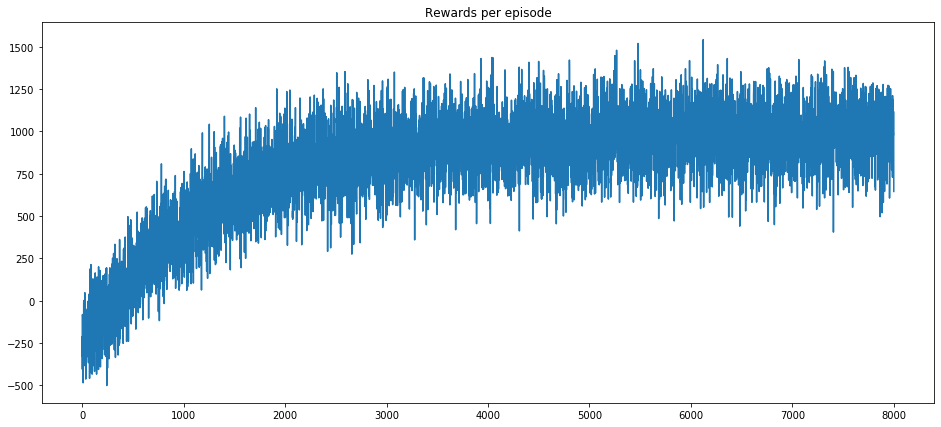

In [49]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)


In [50]:
### DQN for episodes 5000
Episodes = 5000

In [51]:
#Under Test
learning_rate = 0.01
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [2, 7, 6]
episode 0, reward -473.0, memory_length 143, epsilon 0.999, time 729.0, rides 142
Initial State is  [2, 7, 6]
episode 1, reward 39.0, memory_length 283, epsilon 0.998001, time 728.0, rides 139
Initial State is  [2, 7, 6]
episode 2, reward -247.0, memory_length 410, epsilon 0.997002999, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 3, reward -119.0, memory_length 546, epsilon 0.996005996001, time 732.0, rides 135
Initial State is  [2, 7, 6]
episode 4, reward -374.0, memory_length 670, epsilon 0.995009990004999, time 722.0, rides 123
Initial State is  [2, 7, 6]
episode 5, reward 2.0, memory_length 792, epsilon 0.994014980014994, time 731.0, rides 121
Initial State is  [2, 7, 6]
episode 6, reward -367.0, memory_length 912, epsilon 0.993020965034979, time 735.0, rides 119
Initial State is  [2, 7, 6]
episode 7, reward -161.0, memory_length 1050, epsilon 0.9920279440699441, time 722.0, rides 137
Initial State is  [2, 7, 6]
episode 8, reward -54.0, memo

episode 66, reward -307.0, memory_length 2000, epsilon 0.9351638519212846, time 729.0, rides 134
Initial State is  [2, 7, 6]
episode 67, reward -257.0, memory_length 2000, epsilon 0.9342286880693633, time 744.0, rides 130
Initial State is  [2, 7, 6]
episode 68, reward -229.0, memory_length 2000, epsilon 0.933294459381294, time 737.0, rides 117
Initial State is  [2, 7, 6]
episode 69, reward -400.0, memory_length 2000, epsilon 0.9323611649219127, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 70, reward -272.0, memory_length 2000, epsilon 0.9314288037569908, time 726.0, rides 137
Initial State is  [2, 7, 6]
episode 71, reward -183.0, memory_length 2000, epsilon 0.9304973749532338, time 727.0, rides 114
Initial State is  [2, 7, 6]
episode 72, reward -338.0, memory_length 2000, epsilon 0.9295668775782806, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 73, reward -205.0, memory_length 2000, epsilon 0.9286373107007023, time 727.0, rides 117
Initial State is  [2, 7, 6]
e

episode 132, reward -237.0, memory_length 2000, epsilon 0.8754068367770318, time 734.0, rides 138
Initial State is  [2, 7, 6]
episode 133, reward -173.0, memory_length 2000, epsilon 0.8745314299402548, time 730.0, rides 116
Initial State is  [2, 7, 6]
episode 134, reward -371.0, memory_length 2000, epsilon 0.8736568985103146, time 729.0, rides 116
Initial State is  [2, 7, 6]
episode 135, reward -293.0, memory_length 2000, epsilon 0.8727832416118043, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 136, reward -229.0, memory_length 2000, epsilon 0.8719104583701925, time 736.0, rides 130
Initial State is  [2, 7, 6]
episode 137, reward 47.0, memory_length 2000, epsilon 0.8710385479118223, time 725.0, rides 134
Initial State is  [2, 7, 6]
episode 138, reward -167.0, memory_length 2000, epsilon 0.8701675093639105, time 733.0, rides 129
Initial State is  [2, 7, 6]
episode 139, reward -9.0, memory_length 2000, epsilon 0.8692973418545467, time 727.0, rides 144
Initial State is  [2, 7,

episode 198, reward -118.0, memory_length 2000, epsilon 0.8194682977764125, time 729.0, rides 120
Initial State is  [2, 7, 6]
episode 199, reward -89.0, memory_length 2000, epsilon 0.818648829478636, time 728.0, rides 139
Initial State is  [2, 7, 6]
episode 200, reward -167.0, memory_length 2000, epsilon 0.8178301806491574, time 723.0, rides 124
Initial State is  [2, 7, 6]
episode 201, reward -39.0, memory_length 2000, epsilon 0.8170123504685082, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 202, reward 166.0, memory_length 2000, epsilon 0.8161953381180397, time 733.0, rides 125
Initial State is  [2, 7, 6]
episode 203, reward -108.0, memory_length 2000, epsilon 0.8153791427799216, time 726.0, rides 122
Initial State is  [2, 7, 6]
episode 204, reward -138.0, memory_length 2000, epsilon 0.8145637636371417, time 722.0, rides 139
Initial State is  [2, 7, 6]
episode 205, reward -296.0, memory_length 2000, epsilon 0.8137491998735046, time 728.0, rides 122
Initial State is  [2, 7,

episode 264, reward 108.0, memory_length 2000, epsilon 0.7671042341100781, time 723.0, rides 138
Initial State is  [2, 7, 6]
episode 265, reward -338.0, memory_length 2000, epsilon 0.766337129875968, time 727.0, rides 119
Initial State is  [2, 7, 6]
episode 266, reward -263.0, memory_length 2000, epsilon 0.7655707927460921, time 724.0, rides 123
Initial State is  [2, 7, 6]
episode 267, reward 142.0, memory_length 2000, epsilon 0.764805221953346, time 731.0, rides 122
Initial State is  [2, 7, 6]
episode 268, reward 107.0, memory_length 2000, epsilon 0.7640404167313927, time 728.0, rides 126
Initial State is  [2, 7, 6]
episode 269, reward -99.0, memory_length 2000, epsilon 0.7632763763146613, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 270, reward -152.0, memory_length 2000, epsilon 0.7625130999383466, time 729.0, rides 140
Initial State is  [2, 7, 6]
episode 271, reward -107.0, memory_length 2000, epsilon 0.7617505868384082, time 737.0, rides 128
Initial State is  [2, 7, 6

episode 330, reward -232.0, memory_length 2000, epsilon 0.7180862366321393, time 725.0, rides 116
Initial State is  [2, 7, 6]
episode 331, reward 52.0, memory_length 2000, epsilon 0.7173681503955072, time 727.0, rides 116
Initial State is  [2, 7, 6]
episode 332, reward -196.0, memory_length 2000, epsilon 0.7166507822451117, time 729.0, rides 111
Initial State is  [2, 7, 6]
episode 333, reward -185.0, memory_length 2000, epsilon 0.7159341314628666, time 728.0, rides 118
Initial State is  [2, 7, 6]
episode 334, reward -146.0, memory_length 2000, epsilon 0.7152181973314037, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 335, reward 29.0, memory_length 2000, epsilon 0.7145029791340722, time 725.0, rides 110
Initial State is  [2, 7, 6]
episode 336, reward -202.0, memory_length 2000, epsilon 0.7137884761549381, time 726.0, rides 112
Initial State is  [2, 7, 6]
episode 337, reward 123.0, memory_length 2000, epsilon 0.7130746876787832, time 732.0, rides 135
Initial State is  [2, 7, 

episode 396, reward 175.0, memory_length 2000, epsilon 0.6722004915521225, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 397, reward 27.0, memory_length 2000, epsilon 0.6715282910605703, time 738.0, rides 145
Initial State is  [2, 7, 6]
episode 398, reward 113.0, memory_length 2000, epsilon 0.6708567627695098, time 728.0, rides 132
Initial State is  [2, 7, 6]
episode 399, reward 37.0, memory_length 2000, epsilon 0.6701859060067403, time 728.0, rides 132
Initial State is  [2, 7, 6]
episode 400, reward 62.0, memory_length 2000, epsilon 0.6695157201007336, time 728.0, rides 138
Initial State is  [2, 7, 6]
episode 401, reward -128.0, memory_length 2000, epsilon 0.6688462043806328, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 402, reward -129.0, memory_length 2000, epsilon 0.6681773581762521, time 724.0, rides 112
Initial State is  [2, 7, 6]
episode 403, reward 33.0, memory_length 2000, epsilon 0.6675091808180759, time 729.0, rides 124
Initial State is  [2, 7, 6]
ep

episode 462, reward 346.0, memory_length 2000, epsilon 0.6292468477910546, time 739.0, rides 121
Initial State is  [2, 7, 6]
episode 463, reward 5.0, memory_length 2000, epsilon 0.6286176009432635, time 733.0, rides 114
Initial State is  [2, 7, 6]
episode 464, reward 300.0, memory_length 2000, epsilon 0.6279889833423202, time 721.0, rides 127
Initial State is  [2, 7, 6]
episode 465, reward -62.0, memory_length 2000, epsilon 0.6273609943589779, time 734.0, rides 127
Initial State is  [2, 7, 6]
episode 466, reward 142.0, memory_length 2000, epsilon 0.6267336333646188, time 729.0, rides 114
Initial State is  [2, 7, 6]
episode 467, reward 13.0, memory_length 2000, epsilon 0.6261068997312542, time 728.0, rides 126
Initial State is  [2, 7, 6]
episode 468, reward 346.0, memory_length 2000, epsilon 0.6254807928315229, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 469, reward 119.0, memory_length 2000, epsilon 0.6248553120386914, time 740.0, rides 125
Initial State is  [2, 7, 6]
epi

episode 528, reward 146.0, memory_length 2000, epsilon 0.5890379439335424, time 732.0, rides 118
Initial State is  [2, 7, 6]
episode 529, reward 134.0, memory_length 2000, epsilon 0.5884489059896089, time 736.0, rides 121
Initial State is  [2, 7, 6]
episode 530, reward 121.0, memory_length 2000, epsilon 0.5878604570836192, time 724.0, rides 129
Initial State is  [2, 7, 6]
episode 531, reward -54.0, memory_length 2000, epsilon 0.5872725966265356, time 724.0, rides 125
Initial State is  [2, 7, 6]
episode 532, reward 482.0, memory_length 2000, epsilon 0.5866853240299091, time 731.0, rides 132
Initial State is  [2, 7, 6]
episode 533, reward 134.0, memory_length 2000, epsilon 0.5860986387058792, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 534, reward 48.0, memory_length 2000, epsilon 0.5855125400671733, time 730.0, rides 117
Initial State is  [2, 7, 6]
episode 535, reward 138.0, memory_length 2000, epsilon 0.5849270275271061, time 737.0, rides 123
Initial State is  [2, 7, 6]
e

episode 594, reward 229.0, memory_length 2000, epsilon 0.5513983909676525, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 595, reward 109.0, memory_length 2000, epsilon 0.5508469925766849, time 728.0, rides 123
Initial State is  [2, 7, 6]
episode 596, reward 382.0, memory_length 2000, epsilon 0.5502961455841082, time 733.0, rides 122
Initial State is  [2, 7, 6]
episode 597, reward -142.0, memory_length 2000, epsilon 0.5497458494385241, time 736.0, rides 126
Initial State is  [2, 7, 6]
episode 598, reward 267.0, memory_length 2000, epsilon 0.5491961035890855, time 726.0, rides 127
Initial State is  [2, 7, 6]
episode 599, reward 328.0, memory_length 2000, epsilon 0.5486469074854965, time 736.0, rides 124
Initial State is  [2, 7, 6]
episode 600, reward 132.0, memory_length 2000, epsilon 0.548098260578011, time 734.0, rides 136
Initial State is  [2, 7, 6]
episode 601, reward 125.0, memory_length 2000, epsilon 0.547550162317433, time 728.0, rides 122
Initial State is  [2, 7, 6]
e

episode 660, reward 360.0, memory_length 2000, epsilon 0.5161640072477562, time 732.0, rides 125
Initial State is  [2, 7, 6]
episode 661, reward -5.0, memory_length 2000, epsilon 0.5156478432405085, time 725.0, rides 113
Initial State is  [2, 7, 6]
episode 662, reward 135.0, memory_length 2000, epsilon 0.515132195397268, time 726.0, rides 112
Initial State is  [2, 7, 6]
episode 663, reward 393.0, memory_length 2000, epsilon 0.5146170632018707, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 664, reward 157.0, memory_length 2000, epsilon 0.5141024461386688, time 727.0, rides 139
Initial State is  [2, 7, 6]
episode 665, reward 73.0, memory_length 2000, epsilon 0.5135883436925301, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 666, reward 315.0, memory_length 2000, epsilon 0.5130747553488376, time 736.0, rides 123
Initial State is  [2, 7, 6]
episode 667, reward 243.0, memory_length 2000, epsilon 0.5125616805934888, time 727.0, rides 128
Initial State is  [2, 7, 6]
epi

episode 726, reward 92.0, memory_length 2000, epsilon 0.4831811023432807, time 727.0, rides 120
Initial State is  [2, 7, 6]
episode 727, reward 456.0, memory_length 2000, epsilon 0.4826979212409374, time 726.0, rides 136
Initial State is  [2, 7, 6]
episode 728, reward 39.0, memory_length 2000, epsilon 0.48221522331969646, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 729, reward 101.0, memory_length 2000, epsilon 0.48173300809637676, time 726.0, rides 123
Initial State is  [2, 7, 6]
episode 730, reward 375.0, memory_length 2000, epsilon 0.48125127508828036, time 739.0, rides 130
Initial State is  [2, 7, 6]
episode 731, reward 342.0, memory_length 2000, epsilon 0.48077002381319206, time 735.0, rides 131
Initial State is  [2, 7, 6]
episode 732, reward 202.0, memory_length 2000, epsilon 0.48028925378937887, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 733, reward 187.0, memory_length 2000, epsilon 0.47980896453558947, time 728.0, rides 120
Initial State is  [2, 7,

episode 792, reward 667.0, memory_length 2000, epsilon 0.4523058066495642, time 725.0, rides 130
Initial State is  [2, 7, 6]
episode 793, reward 225.0, memory_length 2000, epsilon 0.45185350084291465, time 730.0, rides 133
Initial State is  [2, 7, 6]
episode 794, reward 179.0, memory_length 2000, epsilon 0.4514016473420717, time 733.0, rides 121
Initial State is  [2, 7, 6]
episode 795, reward 393.0, memory_length 2000, epsilon 0.45095024569472963, time 725.0, rides 130
Initial State is  [2, 7, 6]
episode 796, reward 260.0, memory_length 2000, epsilon 0.4504992954490349, time 732.0, rides 127
Initial State is  [2, 7, 6]
episode 797, reward 409.0, memory_length 2000, epsilon 0.45004879615358584, time 735.0, rides 114
Initial State is  [2, 7, 6]
episode 798, reward 110.0, memory_length 2000, epsilon 0.44959874735743227, time 728.0, rides 119
Initial State is  [2, 7, 6]
episode 799, reward 209.0, memory_length 2000, epsilon 0.4491491486100748, time 739.0, rides 132
Initial State is  [2, 7,

episode 858, reward 495.0, memory_length 2000, epsilon 0.4234034438366067, time 736.0, rides 133
Initial State is  [2, 7, 6]
episode 859, reward 174.0, memory_length 2000, epsilon 0.4229800403927701, time 731.0, rides 119
Initial State is  [2, 7, 6]
episode 860, reward 433.0, memory_length 2000, epsilon 0.42255706035237733, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 861, reward 485.0, memory_length 2000, epsilon 0.42213450329202495, time 725.0, rides 123
Initial State is  [2, 7, 6]
episode 862, reward 283.0, memory_length 2000, epsilon 0.4217123687887329, time 723.0, rides 117
Initial State is  [2, 7, 6]
episode 863, reward 236.0, memory_length 2000, epsilon 0.4212906564199442, time 724.0, rides 128
Initial State is  [2, 7, 6]
episode 864, reward 444.0, memory_length 2000, epsilon 0.42086936576352424, time 732.0, rides 141
Initial State is  [2, 7, 6]
episode 865, reward 734.0, memory_length 2000, epsilon 0.4204484963977607, time 739.0, rides 132
Initial State is  [2, 7, 

episode 924, reward 233.0, memory_length 2000, epsilon 0.3963479433983767, time 724.0, rides 122
Initial State is  [2, 7, 6]
episode 925, reward 626.0, memory_length 2000, epsilon 0.3959515954549783, time 728.0, rides 134
Initial State is  [2, 7, 6]
episode 926, reward 516.0, memory_length 2000, epsilon 0.39555564385952335, time 732.0, rides 132
Initial State is  [2, 7, 6]
episode 927, reward 405.0, memory_length 2000, epsilon 0.39516008821566384, time 731.0, rides 136
Initial State is  [2, 7, 6]
episode 928, reward 295.0, memory_length 2000, epsilon 0.3947649281274482, time 729.0, rides 116
Initial State is  [2, 7, 6]
episode 929, reward 461.0, memory_length 2000, epsilon 0.3943701631993207, time 724.0, rides 131
Initial State is  [2, 7, 6]
episode 930, reward 683.0, memory_length 2000, epsilon 0.3939757930361214, time 722.0, rides 122
Initial State is  [2, 7, 6]
episode 931, reward 485.0, memory_length 2000, epsilon 0.3935818172430853, time 730.0, rides 122
Initial State is  [2, 7, 6

episode 990, reward 450.0, memory_length 2000, epsilon 0.37102129074024554, time 724.0, rides 124
Initial State is  [2, 7, 6]
episode 991, reward 388.0, memory_length 2000, epsilon 0.3706502694495053, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 992, reward 257.0, memory_length 2000, epsilon 0.3702796191800558, time 725.0, rides 128
Initial State is  [2, 7, 6]
episode 993, reward 329.0, memory_length 2000, epsilon 0.36990933956087574, time 728.0, rides 120
Initial State is  [2, 7, 6]
episode 994, reward 287.0, memory_length 2000, epsilon 0.36953943022131486, time 723.0, rides 119
Initial State is  [2, 7, 6]
episode 995, reward 442.0, memory_length 2000, epsilon 0.3691698907910935, time 730.0, rides 121
Initial State is  [2, 7, 6]
episode 996, reward 559.0, memory_length 2000, epsilon 0.3688007209003024, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 997, reward 458.0, memory_length 2000, epsilon 0.36843192017940213, time 730.0, rides 125
Initial State is  [2, 7,

episode 1055, reward 555.0, memory_length 2000, epsilon 0.34766067307894, time 728.0, rides 119
Initial State is  [2, 7, 6]
episode 1056, reward 223.0, memory_length 2000, epsilon 0.34731301240586104, time 730.0, rides 123
Initial State is  [2, 7, 6]
episode 1057, reward 576.0, memory_length 2000, epsilon 0.3469656993934552, time 736.0, rides 122
Initial State is  [2, 7, 6]
episode 1058, reward 669.0, memory_length 2000, epsilon 0.3466187336940617, time 732.0, rides 139
Initial State is  [2, 7, 6]
episode 1059, reward 548.0, memory_length 2000, epsilon 0.34627211496036764, time 728.0, rides 116
Initial State is  [2, 7, 6]
episode 1060, reward 702.0, memory_length 2000, epsilon 0.3459258428454073, time 727.0, rides 129
Initial State is  [2, 7, 6]
episode 1061, reward 534.0, memory_length 2000, epsilon 0.34557991700256185, time 731.0, rides 123
Initial State is  [2, 7, 6]
episode 1062, reward 560.0, memory_length 2000, epsilon 0.3452343370855593, time 724.0, rides 121
Initial State is  [

episode 1120, reward 566.0, memory_length 2000, epsilon 0.325770910247633, time 733.0, rides 126
Initial State is  [2, 7, 6]
episode 1121, reward 311.0, memory_length 2000, epsilon 0.32544513933738534, time 738.0, rides 119
Initial State is  [2, 7, 6]
episode 1122, reward 430.0, memory_length 2000, epsilon 0.3251196941980479, time 724.0, rides 127
Initial State is  [2, 7, 6]
episode 1123, reward 609.0, memory_length 2000, epsilon 0.32479457450384985, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 1124, reward 817.0, memory_length 2000, epsilon 0.324469779929346, time 734.0, rides 129
Initial State is  [2, 7, 6]
episode 1125, reward 558.0, memory_length 2000, epsilon 0.32414531014941667, time 730.0, rides 119
Initial State is  [2, 7, 6]
episode 1126, reward 373.0, memory_length 2000, epsilon 0.32382116483926726, time 733.0, rides 133
Initial State is  [2, 7, 6]
episode 1127, reward 747.0, memory_length 2000, epsilon 0.323497343674428, time 730.0, rides 132
Initial State is  [

episode 1185, reward 668.0, memory_length 2000, epsilon 0.30525939279728115, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 1186, reward 452.0, memory_length 2000, epsilon 0.30495413340448385, time 735.0, rides 127
Initial State is  [2, 7, 6]
episode 1187, reward 571.0, memory_length 2000, epsilon 0.3046491792710794, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 1188, reward 536.0, memory_length 2000, epsilon 0.3043445300918083, time 723.0, rides 136
Initial State is  [2, 7, 6]
episode 1189, reward 377.0, memory_length 2000, epsilon 0.30404018556171647, time 730.0, rides 128
Initial State is  [2, 7, 6]
episode 1190, reward 101.0, memory_length 2000, epsilon 0.30373614537615473, time 724.0, rides 115
Initial State is  [2, 7, 6]
episode 1191, reward 711.0, memory_length 2000, epsilon 0.3034324092307786, time 729.0, rides 130
Initial State is  [2, 7, 6]
episode 1192, reward 404.0, memory_length 2000, epsilon 0.3031289768215478, time 725.0, rides 125
Initial State is

episode 1250, reward 472.0, memory_length 2000, epsilon 0.28603934224861294, time 726.0, rides 116
Initial State is  [2, 7, 6]
episode 1251, reward 536.0, memory_length 2000, epsilon 0.2857533029063643, time 737.0, rides 119
Initial State is  [2, 7, 6]
episode 1252, reward 595.0, memory_length 2000, epsilon 0.28546754960345794, time 733.0, rides 120
Initial State is  [2, 7, 6]
episode 1253, reward 731.0, memory_length 2000, epsilon 0.2851820820538545, time 721.0, rides 121
Initial State is  [2, 7, 6]
episode 1254, reward 882.0, memory_length 2000, epsilon 0.2848968999718006, time 727.0, rides 125
Initial State is  [2, 7, 6]
episode 1255, reward 701.0, memory_length 2000, epsilon 0.2846120030718288, time 730.0, rides 121
Initial State is  [2, 7, 6]
episode 1256, reward 583.0, memory_length 2000, epsilon 0.284327391068757, time 728.0, rides 127
Initial State is  [2, 7, 6]
episode 1257, reward 742.0, memory_length 2000, epsilon 0.2840430636776882, time 730.0, rides 130
Initial State is  [

episode 1315, reward 477.0, memory_length 2000, epsilon 0.268029443956713, time 739.0, rides 116
Initial State is  [2, 7, 6]
episode 1316, reward 623.0, memory_length 2000, epsilon 0.2677614145127563, time 731.0, rides 121
Initial State is  [2, 7, 6]
episode 1317, reward 810.0, memory_length 2000, epsilon 0.2674936530982436, time 728.0, rides 132
Initial State is  [2, 7, 6]
episode 1318, reward 811.0, memory_length 2000, epsilon 0.26722615944514533, time 726.0, rides 125
Initial State is  [2, 7, 6]
episode 1319, reward 641.0, memory_length 2000, epsilon 0.2669589332857002, time 737.0, rides 123
Initial State is  [2, 7, 6]
episode 1320, reward 507.0, memory_length 2000, epsilon 0.2666919743524145, time 725.0, rides 121
Initial State is  [2, 7, 6]
episode 1321, reward 648.0, memory_length 2000, epsilon 0.26642528237806207, time 736.0, rides 124
Initial State is  [2, 7, 6]
episode 1322, reward 692.0, memory_length 2000, epsilon 0.266158857095684, time 730.0, rides 124
Initial State is  [2

episode 1380, reward 596.0, memory_length 2000, epsilon 0.25115350309155987, time 741.0, rides 129
Initial State is  [2, 7, 6]
episode 1381, reward 486.0, memory_length 2000, epsilon 0.2509023495884683, time 726.0, rides 127
Initial State is  [2, 7, 6]
episode 1382, reward 781.0, memory_length 2000, epsilon 0.25065144723887983, time 724.0, rides 129
Initial State is  [2, 7, 6]
episode 1383, reward 779.0, memory_length 2000, epsilon 0.25040079579164093, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 1384, reward 415.0, memory_length 2000, epsilon 0.2501503949958493, time 726.0, rides 127
Initial State is  [2, 7, 6]
episode 1385, reward 565.0, memory_length 2000, epsilon 0.24990024460085344, time 724.0, rides 121
Initial State is  [2, 7, 6]
episode 1386, reward 273.0, memory_length 2000, epsilon 0.24965034435625258, time 726.0, rides 122
Initial State is  [2, 7, 6]
episode 1387, reward 757.0, memory_length 2000, epsilon 0.24940069401189632, time 723.0, rides 128
Initial State 

episode 1445, reward 389.0, memory_length 2000, epsilon 0.2353401222790632, time 731.0, rides 117
Initial State is  [2, 7, 6]
episode 1446, reward 673.0, memory_length 2000, epsilon 0.23510478215678413, time 727.0, rides 135
Initial State is  [2, 7, 6]
episode 1447, reward 286.0, memory_length 2000, epsilon 0.23486967737462733, time 730.0, rides 115
Initial State is  [2, 7, 6]
episode 1448, reward 285.0, memory_length 2000, epsilon 0.2346348076972527, time 723.0, rides 140
Initial State is  [2, 7, 6]
episode 1449, reward 448.0, memory_length 2000, epsilon 0.23440017288955545, time 733.0, rides 127
Initial State is  [2, 7, 6]
episode 1450, reward 582.0, memory_length 2000, epsilon 0.2341657727166659, time 727.0, rides 124
Initial State is  [2, 7, 6]
episode 1451, reward 772.0, memory_length 2000, epsilon 0.2339316069439492, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 1452, reward 462.0, memory_length 2000, epsilon 0.23369767533700525, time 736.0, rides 124
Initial State is

episode 1510, reward 705.0, memory_length 2000, epsilon 0.22052239953879277, time 730.0, rides 140
Initial State is  [2, 7, 6]
episode 1511, reward 671.0, memory_length 2000, epsilon 0.22030187713925398, time 730.0, rides 140
Initial State is  [2, 7, 6]
episode 1512, reward 584.0, memory_length 2000, epsilon 0.22008157526211472, time 729.0, rides 131
Initial State is  [2, 7, 6]
episode 1513, reward 353.0, memory_length 2000, epsilon 0.2198614936868526, time 736.0, rides 136
Initial State is  [2, 7, 6]
episode 1514, reward 476.0, memory_length 2000, epsilon 0.21964163219316574, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 1515, reward 607.0, memory_length 2000, epsilon 0.21942199056097256, time 730.0, rides 128
Initial State is  [2, 7, 6]
episode 1516, reward 648.0, memory_length 2000, epsilon 0.2192025685704116, time 722.0, rides 134
Initial State is  [2, 7, 6]
episode 1517, reward 590.0, memory_length 2000, epsilon 0.21898336600184118, time 730.0, rides 132
Initial State 

episode 1575, reward 469.0, memory_length 2000, epsilon 0.20663764524045758, time 726.0, rides 150
Initial State is  [2, 7, 6]
episode 1576, reward 609.0, memory_length 2000, epsilon 0.20643100759521713, time 727.0, rides 114
Initial State is  [2, 7, 6]
episode 1577, reward 541.0, memory_length 2000, epsilon 0.20622457658762192, time 725.0, rides 113
Initial State is  [2, 7, 6]
episode 1578, reward 736.0, memory_length 2000, epsilon 0.2060183520110343, time 734.0, rides 130
Initial State is  [2, 7, 6]
episode 1579, reward 361.0, memory_length 2000, epsilon 0.20581233365902327, time 735.0, rides 122
Initial State is  [2, 7, 6]
episode 1580, reward 556.0, memory_length 2000, epsilon 0.20560652132536425, time 731.0, rides 133
Initial State is  [2, 7, 6]
episode 1581, reward 658.0, memory_length 2000, epsilon 0.20540091480403888, time 728.0, rides 135
Initial State is  [2, 7, 6]
episode 1582, reward 341.0, memory_length 2000, epsilon 0.20519551388923485, time 733.0, rides 114
Initial State

episode 1640, reward 526.0, memory_length 2000, epsilon 0.19362711688165665, time 736.0, rides 132
Initial State is  [2, 7, 6]
episode 1641, reward 890.0, memory_length 2000, epsilon 0.193433489764775, time 728.0, rides 116
Initial State is  [2, 7, 6]
episode 1642, reward 521.0, memory_length 2000, epsilon 0.19324005627501023, time 728.0, rides 122
Initial State is  [2, 7, 6]
episode 1643, reward 460.0, memory_length 2000, epsilon 0.1930468162187352, time 730.0, rides 135
Initial State is  [2, 7, 6]
episode 1644, reward 606.0, memory_length 2000, epsilon 0.19285376940251647, time 728.0, rides 126
Initial State is  [2, 7, 6]
episode 1645, reward 384.0, memory_length 2000, epsilon 0.19266091563311397, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 1646, reward 459.0, memory_length 2000, epsilon 0.19246825471748086, time 732.0, rides 134
Initial State is  [2, 7, 6]
episode 1647, reward 821.0, memory_length 2000, epsilon 0.1922757864627634, time 727.0, rides 133
Initial State is

episode 1705, reward 446.0, memory_length 2000, epsilon 0.1814357705648218, time 725.0, rides 112
Initial State is  [2, 7, 6]
episode 1706, reward 680.0, memory_length 2000, epsilon 0.18125433479425698, time 722.0, rides 119
Initial State is  [2, 7, 6]
episode 1707, reward 990.0, memory_length 2000, epsilon 0.18107308045946272, time 735.0, rides 126
Initial State is  [2, 7, 6]
episode 1708, reward 997.0, memory_length 2000, epsilon 0.18089200737900324, time 729.0, rides 114
Initial State is  [2, 7, 6]
episode 1709, reward 673.0, memory_length 2000, epsilon 0.18071111537162424, time 728.0, rides 123
Initial State is  [2, 7, 6]
episode 1710, reward 1086.0, memory_length 2000, epsilon 0.1805304042562526, time 725.0, rides 133
Initial State is  [2, 7, 6]
episode 1711, reward 880.0, memory_length 2000, epsilon 0.18034987385199636, time 726.0, rides 125
Initial State is  [2, 7, 6]
episode 1712, reward 655.0, memory_length 2000, epsilon 0.18016952397814437, time 726.0, rides 136
Initial State

episode 1770, reward 824.0, memory_length 2000, epsilon 0.17001202812192093, time 724.0, rides 131
Initial State is  [2, 7, 6]
episode 1771, reward 728.0, memory_length 2000, epsilon 0.169842016093799, time 730.0, rides 140
Initial State is  [2, 7, 6]
episode 1772, reward 496.0, memory_length 2000, epsilon 0.1696721740777052, time 724.0, rides 126
Initial State is  [2, 7, 6]
episode 1773, reward 755.0, memory_length 2000, epsilon 0.1695025019036275, time 728.0, rides 136
Initial State is  [2, 7, 6]
episode 1774, reward 525.0, memory_length 2000, epsilon 0.1693329994017239, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 1775, reward 746.0, memory_length 2000, epsilon 0.16916366640232217, time 740.0, rides 137
Initial State is  [2, 7, 6]
episode 1776, reward 482.0, memory_length 2000, epsilon 0.16899450273591984, time 734.0, rides 123
Initial State is  [2, 7, 6]
episode 1777, reward 886.0, memory_length 2000, epsilon 0.16882550823318393, time 724.0, rides 122
Initial State is 

episode 1835, reward 682.0, memory_length 2000, epsilon 0.15930755890168982, time 733.0, rides 112
Initial State is  [2, 7, 6]
episode 1836, reward 546.0, memory_length 2000, epsilon 0.15914825134278812, time 724.0, rides 124
Initial State is  [2, 7, 6]
episode 1837, reward 839.0, memory_length 2000, epsilon 0.15898910309144534, time 732.0, rides 121
Initial State is  [2, 7, 6]
episode 1838, reward 434.0, memory_length 2000, epsilon 0.1588301139883539, time 725.0, rides 136
Initial State is  [2, 7, 6]
episode 1839, reward 484.0, memory_length 2000, epsilon 0.15867128387436555, time 734.0, rides 133
Initial State is  [2, 7, 6]
episode 1840, reward 797.0, memory_length 2000, epsilon 0.15851261259049118, time 722.0, rides 120
Initial State is  [2, 7, 6]
episode 1841, reward 820.0, memory_length 2000, epsilon 0.1583540999779007, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 1842, reward 446.0, memory_length 2000, epsilon 0.1581957458779228, time 727.0, rides 114
Initial State i

episode 1900, reward 312.0, memory_length 2000, epsilon 0.14927707529619813, time 725.0, rides 137
Initial State is  [2, 7, 6]
episode 1901, reward 513.0, memory_length 2000, epsilon 0.14912779822090194, time 727.0, rides 130
Initial State is  [2, 7, 6]
episode 1902, reward 610.0, memory_length 2000, epsilon 0.14897867042268104, time 726.0, rides 125
Initial State is  [2, 7, 6]
episode 1903, reward 541.0, memory_length 2000, epsilon 0.14882969175225835, time 733.0, rides 133
Initial State is  [2, 7, 6]
episode 1904, reward 825.0, memory_length 2000, epsilon 0.1486808620605061, time 731.0, rides 133
Initial State is  [2, 7, 6]
episode 1905, reward 674.0, memory_length 2000, epsilon 0.14853218119844558, time 730.0, rides 119
Initial State is  [2, 7, 6]
episode 1906, reward 1032.0, memory_length 2000, epsilon 0.14838364901724713, time 733.0, rides 124
Initial State is  [2, 7, 6]
episode 1907, reward 833.0, memory_length 2000, epsilon 0.14823526536822987, time 722.0, rides 147
Initial Stat

episode 1965, reward 647.0, memory_length 2000, epsilon 0.1398781411416785, time 727.0, rides 138
Initial State is  [2, 7, 6]
episode 1966, reward 670.0, memory_length 2000, epsilon 0.13973826300053682, time 726.0, rides 137
Initial State is  [2, 7, 6]
episode 1967, reward 925.0, memory_length 2000, epsilon 0.13959852473753628, time 729.0, rides 137
Initial State is  [2, 7, 6]
episode 1968, reward 700.0, memory_length 2000, epsilon 0.13945892621279873, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 1969, reward 564.0, memory_length 2000, epsilon 0.13931946728658592, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 1970, reward 569.0, memory_length 2000, epsilon 0.13918014781929933, time 734.0, rides 126
Initial State is  [2, 7, 6]
episode 1971, reward 849.0, memory_length 2000, epsilon 0.13904096767148003, time 735.0, rides 134
Initial State is  [2, 7, 6]
episode 1972, reward 599.0, memory_length 2000, epsilon 0.13890192670380855, time 734.0, rides 139
Initial State

episode 2030, reward 561.0, memory_length 2000, epsilon 0.13107099218301493, time 722.0, rides 110
Initial State is  [2, 7, 6]
episode 2031, reward 616.0, memory_length 2000, epsilon 0.13093992119083192, time 726.0, rides 124
Initial State is  [2, 7, 6]
episode 2032, reward 769.0, memory_length 2000, epsilon 0.13080898126964108, time 735.0, rides 118
Initial State is  [2, 7, 6]
episode 2033, reward 539.0, memory_length 2000, epsilon 0.13067817228837145, time 728.0, rides 120
Initial State is  [2, 7, 6]
episode 2034, reward 542.0, memory_length 2000, epsilon 0.13054749411608307, time 732.0, rides 130
Initial State is  [2, 7, 6]
episode 2035, reward 400.0, memory_length 2000, epsilon 0.13041694662196698, time 728.0, rides 121
Initial State is  [2, 7, 6]
episode 2036, reward 738.0, memory_length 2000, epsilon 0.13028652967534501, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 2037, reward 840.0, memory_length 2000, epsilon 0.13015624314566968, time 723.0, rides 134
Initial Stat

episode 2095, reward 1072.0, memory_length 2000, epsilon 0.12281836784232969, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 2096, reward 568.0, memory_length 2000, epsilon 0.12269554947448735, time 731.0, rides 118
Initial State is  [2, 7, 6]
episode 2097, reward 695.0, memory_length 2000, epsilon 0.12257285392501287, time 727.0, rides 110
Initial State is  [2, 7, 6]
episode 2098, reward 627.0, memory_length 2000, epsilon 0.12245028107108785, time 725.0, rides 121
Initial State is  [2, 7, 6]
episode 2099, reward 694.0, memory_length 2000, epsilon 0.12232783079001676, time 731.0, rides 132
Initial State is  [2, 7, 6]
episode 2100, reward 746.0, memory_length 2000, epsilon 0.12220550295922675, time 722.0, rides 130
Initial State is  [2, 7, 6]
episode 2101, reward 567.0, memory_length 2000, epsilon 0.12208329745626752, time 726.0, rides 129
Initial State is  [2, 7, 6]
episode 2102, reward 612.0, memory_length 2000, epsilon 0.12196121415881125, time 730.0, rides 112
Initial Sta

episode 2160, reward 516.0, memory_length 2000, epsilon 0.11508535357992454, time 724.0, rides 129
Initial State is  [2, 7, 6]
episode 2161, reward 784.0, memory_length 2000, epsilon 0.11497026822634461, time 728.0, rides 131
Initial State is  [2, 7, 6]
episode 2162, reward 742.0, memory_length 2000, epsilon 0.11485529795811826, time 724.0, rides 138
Initial State is  [2, 7, 6]
episode 2163, reward 741.0, memory_length 2000, epsilon 0.11474044266016015, time 726.0, rides 123
Initial State is  [2, 7, 6]
episode 2164, reward 819.0, memory_length 2000, epsilon 0.11462570221749999, time 731.0, rides 118
Initial State is  [2, 7, 6]
episode 2165, reward 886.0, memory_length 2000, epsilon 0.11451107651528249, time 725.0, rides 136
Initial State is  [2, 7, 6]
episode 2166, reward 594.0, memory_length 2000, epsilon 0.11439656543876721, time 730.0, rides 130
Initial State is  [2, 7, 6]
episode 2167, reward 463.0, memory_length 2000, epsilon 0.11428216887332844, time 721.0, rides 128
Initial Stat

episode 2225, reward 812.0, memory_length 2000, epsilon 0.10783923318065335, time 728.0, rides 121
Initial State is  [2, 7, 6]
episode 2226, reward 1080.0, memory_length 2000, epsilon 0.10773139394747269, time 729.0, rides 130
Initial State is  [2, 7, 6]
episode 2227, reward 566.0, memory_length 2000, epsilon 0.10762366255352522, time 730.0, rides 116
Initial State is  [2, 7, 6]
episode 2228, reward 946.0, memory_length 2000, epsilon 0.1075160388909717, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 2229, reward 812.0, memory_length 2000, epsilon 0.10740852285208072, time 730.0, rides 118
Initial State is  [2, 7, 6]
episode 2230, reward 655.0, memory_length 2000, epsilon 0.10730111432922863, time 732.0, rides 142
Initial State is  [2, 7, 6]
episode 2231, reward 850.0, memory_length 2000, epsilon 0.1071938132148994, time 726.0, rides 140
Initial State is  [2, 7, 6]
episode 2232, reward 782.0, memory_length 2000, epsilon 0.1070866194016845, time 725.0, rides 123
Initial State 

episode 2290, reward 602.0, memory_length 2000, epsilon 0.10104935034078859, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 2291, reward 716.0, memory_length 2000, epsilon 0.1009483009904478, time 727.0, rides 125
Initial State is  [2, 7, 6]
episode 2292, reward 644.0, memory_length 2000, epsilon 0.10084735268945735, time 725.0, rides 128
Initial State is  [2, 7, 6]
episode 2293, reward 493.0, memory_length 2000, epsilon 0.10074650533676789, time 724.0, rides 127
Initial State is  [2, 7, 6]
episode 2294, reward 965.0, memory_length 2000, epsilon 0.10064575883143112, time 735.0, rides 141
Initial State is  [2, 7, 6]
episode 2295, reward 578.0, memory_length 2000, epsilon 0.1005451130725997, time 727.0, rides 121
Initial State is  [2, 7, 6]
episode 2296, reward 745.0, memory_length 2000, epsilon 0.1004445679595271, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 2297, reward 350.0, memory_length 2000, epsilon 0.10034412339156756, time 720.0, rides 137
Initial State i

episode 2355, reward 1188.0, memory_length 2000, epsilon 0.09468697896979585, time 729.0, rides 123
Initial State is  [2, 7, 6]
episode 2356, reward 600.0, memory_length 2000, epsilon 0.09459229199082606, time 737.0, rides 123
Initial State is  [2, 7, 6]
episode 2357, reward 469.0, memory_length 2000, epsilon 0.09449769969883523, time 726.0, rides 117
Initial State is  [2, 7, 6]
episode 2358, reward 1004.0, memory_length 2000, epsilon 0.09440320199913639, time 730.0, rides 130
Initial State is  [2, 7, 6]
episode 2359, reward 989.0, memory_length 2000, epsilon 0.09430879879713726, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 2360, reward 690.0, memory_length 2000, epsilon 0.09421448999834012, time 722.0, rides 128
Initial State is  [2, 7, 6]
episode 2361, reward 434.0, memory_length 2000, epsilon 0.09412027550834177, time 726.0, rides 112
Initial State is  [2, 7, 6]
episode 2362, reward 925.0, memory_length 2000, epsilon 0.09402615523283343, time 731.0, rides 146
Initial St

episode 2420, reward 840.0, memory_length 2000, epsilon 0.0887252016582989, time 721.0, rides 123
Initial State is  [2, 7, 6]
episode 2421, reward 772.0, memory_length 2000, epsilon 0.0886364764566406, time 729.0, rides 139
Initial State is  [2, 7, 6]
episode 2422, reward 545.0, memory_length 2000, epsilon 0.08854783998018396, time 730.0, rides 111
Initial State is  [2, 7, 6]
episode 2423, reward 507.0, memory_length 2000, epsilon 0.08845929214020377, time 733.0, rides 128
Initial State is  [2, 7, 6]
episode 2424, reward 612.0, memory_length 2000, epsilon 0.08837083284806357, time 740.0, rides 127
Initial State is  [2, 7, 6]
episode 2425, reward 723.0, memory_length 2000, epsilon 0.08828246201521552, time 731.0, rides 143
Initial State is  [2, 7, 6]
episode 2426, reward 966.0, memory_length 2000, epsilon 0.0881941795532003, time 743.0, rides 141
Initial State is  [2, 7, 6]
episode 2427, reward 541.0, memory_length 2000, epsilon 0.0881059853736471, time 734.0, rides 122
Initial State is

episode 2485, reward 705.0, memory_length 2000, epsilon 0.08313879579806785, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 2486, reward 784.0, memory_length 2000, epsilon 0.08305565700226979, time 730.0, rides 118
Initial State is  [2, 7, 6]
episode 2487, reward 809.0, memory_length 2000, epsilon 0.08297260134526752, time 727.0, rides 127
Initial State is  [2, 7, 6]
episode 2488, reward 941.0, memory_length 2000, epsilon 0.08288962874392225, time 734.0, rides 135
Initial State is  [2, 7, 6]
episode 2489, reward 496.0, memory_length 2000, epsilon 0.08280673911517833, time 729.0, rides 123
Initial State is  [2, 7, 6]
episode 2490, reward 935.0, memory_length 2000, epsilon 0.08272393237606315, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 2491, reward 276.0, memory_length 2000, epsilon 0.0826412084436871, time 730.0, rides 113
Initial State is  [2, 7, 6]
episode 2492, reward 657.0, memory_length 2000, epsilon 0.08255856723524341, time 732.0, rides 122
Initial State

episode 2550, reward 681.0, memory_length 2000, epsilon 0.07790412687223583, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 2551, reward 655.0, memory_length 2000, epsilon 0.07782622274536359, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 2552, reward 853.0, memory_length 2000, epsilon 0.07774839652261822, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 2553, reward 737.0, memory_length 2000, epsilon 0.0776706481260956, time 734.0, rides 121
Initial State is  [2, 7, 6]
episode 2554, reward 658.0, memory_length 2000, epsilon 0.0775929774779695, time 733.0, rides 137
Initial State is  [2, 7, 6]
episode 2555, reward 809.0, memory_length 2000, epsilon 0.07751538450049153, time 737.0, rides 127
Initial State is  [2, 7, 6]
episode 2556, reward 562.0, memory_length 2000, epsilon 0.07743786911599104, time 724.0, rides 121
Initial State is  [2, 7, 6]
episode 2557, reward 654.0, memory_length 2000, epsilon 0.07736043124687506, time 733.0, rides 125
Initial State 

episode 2615, reward 651.0, memory_length 2000, epsilon 0.07299904846428458, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 2616, reward 757.0, memory_length 2000, epsilon 0.0729260494158203, time 730.0, rides 136
Initial State is  [2, 7, 6]
episode 2617, reward 742.0, memory_length 2000, epsilon 0.07285312336640448, time 727.0, rides 120
Initial State is  [2, 7, 6]
episode 2618, reward 919.0, memory_length 2000, epsilon 0.07278027024303808, time 721.0, rides 118
Initial State is  [2, 7, 6]
episode 2619, reward 978.0, memory_length 2000, epsilon 0.07270748997279504, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 2620, reward 533.0, memory_length 2000, epsilon 0.07263478248282225, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 2621, reward 1005.0, memory_length 2000, epsilon 0.07256214770033943, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 2622, reward 694.0, memory_length 2000, epsilon 0.0724895855526391, time 734.0, rides 118
Initial State

episode 2680, reward 913.0, memory_length 2000, epsilon 0.06840280856276588, time 721.0, rides 140
Initial State is  [2, 7, 6]
episode 2681, reward 854.0, memory_length 2000, epsilon 0.06833440575420312, time 730.0, rides 130
Initial State is  [2, 7, 6]
episode 2682, reward 803.0, memory_length 2000, epsilon 0.06826607134844892, time 734.0, rides 132
Initial State is  [2, 7, 6]
episode 2683, reward 785.0, memory_length 2000, epsilon 0.06819780527710047, time 725.0, rides 129
Initial State is  [2, 7, 6]
episode 2684, reward 690.0, memory_length 2000, epsilon 0.06812960747182337, time 727.0, rides 129
Initial State is  [2, 7, 6]
episode 2685, reward 779.0, memory_length 2000, epsilon 0.06806147786435154, time 730.0, rides 139
Initial State is  [2, 7, 6]
episode 2686, reward 745.0, memory_length 2000, epsilon 0.06799341638648719, time 726.0, rides 140
Initial State is  [2, 7, 6]
episode 2687, reward 1136.0, memory_length 2000, epsilon 0.06792542297010071, time 735.0, rides 135
Initial Sta

episode 2745, reward 869.0, memory_length 2000, epsilon 0.06409596176535942, time 727.0, rides 130
Initial State is  [2, 7, 6]
episode 2746, reward 795.0, memory_length 2000, epsilon 0.06403186580359406, time 722.0, rides 122
Initial State is  [2, 7, 6]
episode 2747, reward 718.0, memory_length 2000, epsilon 0.06396783393779047, time 726.0, rides 120
Initial State is  [2, 7, 6]
episode 2748, reward 436.0, memory_length 2000, epsilon 0.06390386610385268, time 733.0, rides 128
Initial State is  [2, 7, 6]
episode 2749, reward 740.0, memory_length 2000, epsilon 0.06383996223774882, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 2750, reward 605.0, memory_length 2000, epsilon 0.06377612227551108, time 738.0, rides 138
Initial State is  [2, 7, 6]
episode 2751, reward 871.0, memory_length 2000, epsilon 0.06371234615323557, time 724.0, rides 128
Initial State is  [2, 7, 6]
episode 2752, reward 618.0, memory_length 2000, epsilon 0.06364863380708233, time 732.0, rides 113
Initial Stat

episode 2810, reward 835.0, memory_length 2000, epsilon 0.06006028701082751, time 735.0, rides 132
Initial State is  [2, 7, 6]
episode 2811, reward 748.0, memory_length 2000, epsilon 0.060000226723816684, time 723.0, rides 124
Initial State is  [2, 7, 6]
episode 2812, reward 965.0, memory_length 2000, epsilon 0.059940226497092866, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 2813, reward 926.0, memory_length 2000, epsilon 0.05988028627059577, time 736.0, rides 146
Initial State is  [2, 7, 6]
episode 2814, reward 1061.0, memory_length 2000, epsilon 0.05982040598432518, time 728.0, rides 126
Initial State is  [2, 7, 6]
episode 2815, reward 868.0, memory_length 2000, epsilon 0.05976058557834085, time 731.0, rides 123
Initial State is  [2, 7, 6]
episode 2816, reward 945.0, memory_length 2000, epsilon 0.05970082499276251, time 729.0, rides 123
Initial State is  [2, 7, 6]
episode 2817, reward 730.0, memory_length 2000, epsilon 0.059641124167769746, time 734.0, rides 141
Initial 

episode 2875, reward 831.0, memory_length 2000, epsilon 0.05627871049081451, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 2876, reward 850.0, memory_length 2000, epsilon 0.0562224317803237, time 722.0, rides 121
Initial State is  [2, 7, 6]
episode 2877, reward 1042.0, memory_length 2000, epsilon 0.056166209348543376, time 724.0, rides 124
Initial State is  [2, 7, 6]
episode 2878, reward 945.0, memory_length 2000, epsilon 0.056110043139194835, time 725.0, rides 131
Initial State is  [2, 7, 6]
episode 2879, reward 779.0, memory_length 2000, epsilon 0.05605393309605564, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 2880, reward 845.0, memory_length 2000, epsilon 0.055997879162959584, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 2881, reward 732.0, memory_length 2000, epsilon 0.055941881283796624, time 735.0, rides 131
Initial State is  [2, 7, 6]
episode 2882, reward 639.0, memory_length 2000, epsilon 0.055885939402512824, time 733.0, rides 126
Initial

episode 2940, reward 1074.0, memory_length 2000, epsilon 0.052735233415350184, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 2941, reward 1152.0, memory_length 2000, epsilon 0.052682498181934836, time 728.0, rides 117
Initial State is  [2, 7, 6]
episode 2942, reward 947.0, memory_length 2000, epsilon 0.052629815683752905, time 729.0, rides 136
Initial State is  [2, 7, 6]
episode 2943, reward 927.0, memory_length 2000, epsilon 0.05257718586806915, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 2944, reward 707.0, memory_length 2000, epsilon 0.05252460868220108, time 733.0, rides 125
Initial State is  [2, 7, 6]
episode 2945, reward 663.0, memory_length 2000, epsilon 0.05247208407351888, time 727.0, rides 118
Initial State is  [2, 7, 6]
episode 2946, reward 779.0, memory_length 2000, epsilon 0.052419611989445364, time 729.0, rides 142
Initial State is  [2, 7, 6]
episode 2947, reward 633.0, memory_length 2000, epsilon 0.05236719237745592, time 740.0, rides 125
Initia

episode 3005, reward 873.0, memory_length 2000, epsilon 0.04941486432645551, time 723.0, rides 126
Initial State is  [2, 7, 6]
episode 3006, reward 552.0, memory_length 2000, epsilon 0.049365449462129056, time 729.0, rides 119
Initial State is  [2, 7, 6]
episode 3007, reward 820.0, memory_length 2000, epsilon 0.049316084012666926, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 3008, reward 744.0, memory_length 2000, epsilon 0.04926676792865426, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 3009, reward 768.0, memory_length 2000, epsilon 0.0492175011607256, time 737.0, rides 118
Initial State is  [2, 7, 6]
episode 3010, reward 623.0, memory_length 2000, epsilon 0.049168283659564875, time 724.0, rides 120
Initial State is  [2, 7, 6]
episode 3011, reward 930.0, memory_length 2000, epsilon 0.04911911537590531, time 721.0, rides 126
Initial State is  [2, 7, 6]
episode 3012, reward 600.0, memory_length 2000, epsilon 0.04906999626052941, time 734.0, rides 120
Initial St

episode 3070, reward 493.0, memory_length 2000, epsilon 0.04630355567348711, time 727.0, rides 117
Initial State is  [2, 7, 6]
episode 3071, reward 750.0, memory_length 2000, epsilon 0.046257252117813626, time 739.0, rides 125
Initial State is  [2, 7, 6]
episode 3072, reward 631.0, memory_length 2000, epsilon 0.04621099486569581, time 728.0, rides 122
Initial State is  [2, 7, 6]
episode 3073, reward 717.0, memory_length 2000, epsilon 0.04616478387083012, time 724.0, rides 133
Initial State is  [2, 7, 6]
episode 3074, reward 728.0, memory_length 2000, epsilon 0.04611861908695929, time 730.0, rides 132
Initial State is  [2, 7, 6]
episode 3075, reward 810.0, memory_length 2000, epsilon 0.04607250046787233, time 723.0, rides 133
Initial State is  [2, 7, 6]
episode 3076, reward 779.0, memory_length 2000, epsilon 0.04602642796740446, time 725.0, rides 123
Initial State is  [2, 7, 6]
episode 3077, reward 743.0, memory_length 2000, epsilon 0.045980401539437055, time 730.0, rides 109
Initial St

episode 3135, reward 1170.0, memory_length 2000, epsilon 0.04338814438188925, time 726.0, rides 130
Initial State is  [2, 7, 6]
episode 3136, reward 1036.0, memory_length 2000, epsilon 0.043344756237507366, time 732.0, rides 130
Initial State is  [2, 7, 6]
episode 3137, reward 654.0, memory_length 2000, epsilon 0.043301411481269855, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 3138, reward 911.0, memory_length 2000, epsilon 0.04325811006978859, time 735.0, rides 129
Initial State is  [2, 7, 6]
episode 3139, reward 891.0, memory_length 2000, epsilon 0.043214851959718796, time 726.0, rides 121
Initial State is  [2, 7, 6]
episode 3140, reward 1122.0, memory_length 2000, epsilon 0.04317163710775908, time 727.0, rides 133
Initial State is  [2, 7, 6]
episode 3141, reward 856.0, memory_length 2000, epsilon 0.04312846547065132, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 3142, reward 678.0, memory_length 2000, epsilon 0.04308533700518067, time 731.0, rides 131
Initia

episode 3200, reward 575.0, memory_length 2000, epsilon 0.04065629616391608, time 734.0, rides 128
Initial State is  [2, 7, 6]
episode 3201, reward 733.0, memory_length 2000, epsilon 0.040615639867752164, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 3202, reward 995.0, memory_length 2000, epsilon 0.040575024227884414, time 728.0, rides 131
Initial State is  [2, 7, 6]
episode 3203, reward 1006.0, memory_length 2000, epsilon 0.04053444920365653, time 728.0, rides 136
Initial State is  [2, 7, 6]
episode 3204, reward 824.0, memory_length 2000, epsilon 0.040493914754452874, time 737.0, rides 135
Initial State is  [2, 7, 6]
episode 3205, reward 993.0, memory_length 2000, epsilon 0.04045342083969842, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 3206, reward 775.0, memory_length 2000, epsilon 0.04041296741885872, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 3207, reward 860.0, memory_length 2000, epsilon 0.04037255445143986, time 724.0, rides 131
Initial 

episode 3265, reward 950.0, memory_length 2000, epsilon 0.03809645333571841, time 726.0, rides 123
Initial State is  [2, 7, 6]
episode 3266, reward 833.0, memory_length 2000, epsilon 0.03805835688238269, time 725.0, rides 133
Initial State is  [2, 7, 6]
episode 3267, reward 813.0, memory_length 2000, epsilon 0.038020298525500304, time 730.0, rides 126
Initial State is  [2, 7, 6]
episode 3268, reward 897.0, memory_length 2000, epsilon 0.0379822782269748, time 724.0, rides 130
Initial State is  [2, 7, 6]
episode 3269, reward 1002.0, memory_length 2000, epsilon 0.037944295948747826, time 729.0, rides 124
Initial State is  [2, 7, 6]
episode 3270, reward 858.0, memory_length 2000, epsilon 0.03790635165279908, time 728.0, rides 139
Initial State is  [2, 7, 6]
episode 3271, reward 553.0, memory_length 2000, epsilon 0.037868445301146275, time 732.0, rides 120
Initial State is  [2, 7, 6]
episode 3272, reward 815.0, memory_length 2000, epsilon 0.03783057685584513, time 723.0, rides 130
Initial S

episode 3330, reward 1088.0, memory_length 2000, epsilon 0.035697785920024, time 730.0, rides 137
Initial State is  [2, 7, 6]
episode 3331, reward 1018.0, memory_length 2000, epsilon 0.03566208813410397, time 727.0, rides 147
Initial State is  [2, 7, 6]
episode 3332, reward 1054.0, memory_length 2000, epsilon 0.03562642604596987, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 3333, reward 625.0, memory_length 2000, epsilon 0.035590799619923896, time 729.0, rides 126
Initial State is  [2, 7, 6]
episode 3334, reward 921.0, memory_length 2000, epsilon 0.035555208820303975, time 725.0, rides 126
Initial State is  [2, 7, 6]
episode 3335, reward 701.0, memory_length 2000, epsilon 0.035519653611483674, time 726.0, rides 125
Initial State is  [2, 7, 6]
episode 3336, reward 589.0, memory_length 2000, epsilon 0.03548413395787219, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 3337, reward 1114.0, memory_length 2000, epsilon 0.03544864982391432, time 730.0, rides 132
Initial

episode 3395, reward 791.0, memory_length 2000, epsilon 0.03345014582754029, time 726.0, rides 139
Initial State is  [2, 7, 6]
episode 3396, reward 797.0, memory_length 2000, epsilon 0.033416695681712745, time 727.0, rides 128
Initial State is  [2, 7, 6]
episode 3397, reward 965.0, memory_length 2000, epsilon 0.03338327898603103, time 725.0, rides 144
Initial State is  [2, 7, 6]
episode 3398, reward 1246.0, memory_length 2000, epsilon 0.033349895707044996, time 735.0, rides 128
Initial State is  [2, 7, 6]
episode 3399, reward 849.0, memory_length 2000, epsilon 0.03331654581133795, time 730.0, rides 134
Initial State is  [2, 7, 6]
episode 3400, reward 583.0, memory_length 2000, epsilon 0.03328322926552661, time 727.0, rides 125
Initial State is  [2, 7, 6]
episode 3401, reward 602.0, memory_length 2000, epsilon 0.03324994603626109, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 3402, reward 877.0, memory_length 2000, epsilon 0.033216696090224825, time 720.0, rides 129
Initial 

episode 3460, reward 1110.0, memory_length 2000, epsilon 0.03134402392323381, time 724.0, rides 130
Initial State is  [2, 7, 6]
episode 3461, reward 1059.0, memory_length 2000, epsilon 0.03131267989931057, time 722.0, rides 139
Initial State is  [2, 7, 6]
episode 3462, reward 1066.0, memory_length 2000, epsilon 0.031281367219411264, time 726.0, rides 139
Initial State is  [2, 7, 6]
episode 3463, reward 886.0, memory_length 2000, epsilon 0.031250085852191856, time 725.0, rides 134
Initial State is  [2, 7, 6]
episode 3464, reward 627.0, memory_length 2000, epsilon 0.031218835766339662, time 726.0, rides 126
Initial State is  [2, 7, 6]
episode 3465, reward 947.0, memory_length 2000, epsilon 0.03118761693057332, time 729.0, rides 134
Initial State is  [2, 7, 6]
episode 3466, reward 724.0, memory_length 2000, epsilon 0.031156429313642747, time 733.0, rides 125
Initial State is  [2, 7, 6]
episode 3467, reward 854.0, memory_length 2000, epsilon 0.031125272884329105, time 726.0, rides 131
Init

episode 3525, reward 1199.0, memory_length 2000, epsilon 0.02937050979584611, time 727.0, rides 131
Initial State is  [2, 7, 6]
episode 3526, reward 883.0, memory_length 2000, epsilon 0.029341139286050266, time 723.0, rides 125
Initial State is  [2, 7, 6]
episode 3527, reward 840.0, memory_length 2000, epsilon 0.029311798146764215, time 732.0, rides 126
Initial State is  [2, 7, 6]
episode 3528, reward 971.0, memory_length 2000, epsilon 0.02928248634861745, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 3529, reward 900.0, memory_length 2000, epsilon 0.029253203862268835, time 732.0, rides 126
Initial State is  [2, 7, 6]
episode 3530, reward 762.0, memory_length 2000, epsilon 0.029223950658406567, time 728.0, rides 136
Initial State is  [2, 7, 6]
episode 3531, reward 716.0, memory_length 2000, epsilon 0.02919472670774816, time 729.0, rides 137
Initial State is  [2, 7, 6]
episode 3532, reward 724.0, memory_length 2000, epsilon 0.02916553198104041, time 722.0, rides 128
Initial

episode 3590, reward 877.0, memory_length 2000, epsilon 0.027521254060442087, time 724.0, rides 127
Initial State is  [2, 7, 6]
episode 3591, reward 746.0, memory_length 2000, epsilon 0.027493732806381645, time 728.0, rides 120
Initial State is  [2, 7, 6]
episode 3592, reward 955.0, memory_length 2000, epsilon 0.027466239073575264, time 739.0, rides 128
Initial State is  [2, 7, 6]
episode 3593, reward 946.0, memory_length 2000, epsilon 0.02743877283450169, time 727.0, rides 135
Initial State is  [2, 7, 6]
episode 3594, reward 859.0, memory_length 2000, epsilon 0.027411334061667188, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 3595, reward 901.0, memory_length 2000, epsilon 0.02738392272760552, time 723.0, rides 138
Initial State is  [2, 7, 6]
episode 3596, reward 858.0, memory_length 2000, epsilon 0.027356538804877914, time 730.0, rides 143
Initial State is  [2, 7, 6]
episode 3597, reward 818.0, memory_length 2000, epsilon 0.027329182266073036, time 721.0, rides 132
Initia

episode 3655, reward 760.0, memory_length 2000, epsilon 0.025788433034503296, time 733.0, rides 131
Initial State is  [2, 7, 6]
episode 3656, reward 987.0, memory_length 2000, epsilon 0.025762644601468793, time 733.0, rides 125
Initial State is  [2, 7, 6]
episode 3657, reward 885.0, memory_length 2000, epsilon 0.025736881956867325, time 727.0, rides 131
Initial State is  [2, 7, 6]
episode 3658, reward 1194.0, memory_length 2000, epsilon 0.025711145074910458, time 727.0, rides 144
Initial State is  [2, 7, 6]
episode 3659, reward 1206.0, memory_length 2000, epsilon 0.025685433929835546, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 3660, reward 919.0, memory_length 2000, epsilon 0.025659748495905712, time 726.0, rides 135
Initial State is  [2, 7, 6]
episode 3661, reward 800.0, memory_length 2000, epsilon 0.025634088747409807, time 734.0, rides 123
Initial State is  [2, 7, 6]
episode 3662, reward 1100.0, memory_length 2000, epsilon 0.025608454658662398, time 729.0, rides 115
I

episode 3720, reward 746.0, memory_length 2000, epsilon 0.024164715638120806, time 726.0, rides 146
Initial State is  [2, 7, 6]
episode 3721, reward 724.0, memory_length 2000, epsilon 0.024140550922482684, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 3722, reward 717.0, memory_length 2000, epsilon 0.0241164103715602, time 731.0, rides 139
Initial State is  [2, 7, 6]
episode 3723, reward 1159.0, memory_length 2000, epsilon 0.02409229396118864, time 734.0, rides 137
Initial State is  [2, 7, 6]
episode 3724, reward 849.0, memory_length 2000, epsilon 0.02406820166722745, time 728.0, rides 127
Initial State is  [2, 7, 6]
episode 3725, reward 839.0, memory_length 2000, epsilon 0.024044133465560225, time 731.0, rides 136
Initial State is  [2, 7, 6]
episode 3726, reward 893.0, memory_length 2000, epsilon 0.024020089332094666, time 726.0, rides 144
Initial State is  [2, 7, 6]
episode 3727, reward 1074.0, memory_length 2000, epsilon 0.023996069242762572, time 723.0, rides 133
Initia

episode 3785, reward 1112.0, memory_length 2000, epsilon 0.022643232378251683, time 736.0, rides 135
Initial State is  [2, 7, 6]
episode 3786, reward 911.0, memory_length 2000, epsilon 0.02262058914587343, time 732.0, rides 123
Initial State is  [2, 7, 6]
episode 3787, reward 681.0, memory_length 2000, epsilon 0.02259796855672756, time 726.0, rides 136
Initial State is  [2, 7, 6]
episode 3788, reward 1088.0, memory_length 2000, epsilon 0.022575370588170832, time 730.0, rides 125
Initial State is  [2, 7, 6]
episode 3789, reward 925.0, memory_length 2000, epsilon 0.02255279521758266, time 727.0, rides 141
Initial State is  [2, 7, 6]
episode 3790, reward 944.0, memory_length 2000, epsilon 0.02253024242236508, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 3791, reward 950.0, memory_length 2000, epsilon 0.022507712179942713, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 3792, reward 708.0, memory_length 2000, epsilon 0.02248520446776277, time 726.0, rides 134
Initial

episode 3850, reward 962.0, memory_length 2000, epsilon 0.021217546285819937, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 3851, reward 1123.0, memory_length 2000, epsilon 0.02119632873953412, time 738.0, rides 129
Initial State is  [2, 7, 6]
episode 3852, reward 631.0, memory_length 2000, epsilon 0.021175132410794585, time 736.0, rides 131
Initial State is  [2, 7, 6]
episode 3853, reward 838.0, memory_length 2000, epsilon 0.02115395727838379, time 730.0, rides 121
Initial State is  [2, 7, 6]
episode 3854, reward 805.0, memory_length 2000, epsilon 0.021132803321105405, time 721.0, rides 125
Initial State is  [2, 7, 6]
episode 3855, reward 857.0, memory_length 2000, epsilon 0.0211116705177843, time 727.0, rides 136
Initial State is  [2, 7, 6]
episode 3856, reward 854.0, memory_length 2000, epsilon 0.021090558847266516, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 3857, reward 976.0, memory_length 2000, epsilon 0.02106946828841925, time 730.0, rides 132
Initial 

episode 3915, reward 1055.0, memory_length 2000, epsilon 0.019881625682705233, time 728.0, rides 136
Initial State is  [2, 7, 6]
episode 3916, reward 941.0, memory_length 2000, epsilon 0.019861744057022526, time 727.0, rides 143
Initial State is  [2, 7, 6]
episode 3917, reward 938.0, memory_length 2000, epsilon 0.019841882312965502, time 730.0, rides 126
Initial State is  [2, 7, 6]
episode 3918, reward 1007.0, memory_length 2000, epsilon 0.019822040430652537, time 721.0, rides 135
Initial State is  [2, 7, 6]
episode 3919, reward 811.0, memory_length 2000, epsilon 0.019802218390221886, time 726.0, rides 135
Initial State is  [2, 7, 6]
episode 3920, reward 1038.0, memory_length 2000, epsilon 0.019782416171831664, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 3921, reward 648.0, memory_length 2000, epsilon 0.01976263375565983, time 728.0, rides 139
Initial State is  [2, 7, 6]
episode 3922, reward 875.0, memory_length 2000, epsilon 0.019742871121904173, time 730.0, rides 142
In

episode 3980, reward 884.0, memory_length 2000, epsilon 0.018629818663403915, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 3981, reward 917.0, memory_length 2000, epsilon 0.01861118884474051, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 3982, reward 834.0, memory_length 2000, epsilon 0.01859257765589577, time 727.0, rides 131
Initial State is  [2, 7, 6]
episode 3983, reward 1116.0, memory_length 2000, epsilon 0.018573985078239874, time 726.0, rides 134
Initial State is  [2, 7, 6]
episode 3984, reward 989.0, memory_length 2000, epsilon 0.018555411093161635, time 724.0, rides 132
Initial State is  [2, 7, 6]
episode 3985, reward 611.0, memory_length 2000, epsilon 0.018536855682068473, time 735.0, rides 126
Initial State is  [2, 7, 6]
episode 3986, reward 974.0, memory_length 2000, epsilon 0.018518318826386403, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 3987, reward 748.0, memory_length 2000, epsilon 0.018499800507560015, time 730.0, rides 125
Initi

episode 4045, reward 638.0, memory_length 2000, epsilon 0.017456829183401443, time 727.0, rides 131
Initial State is  [2, 7, 6]
episode 4046, reward 956.0, memory_length 2000, epsilon 0.017439372354218042, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 4047, reward 1165.0, memory_length 2000, epsilon 0.017421932981863824, time 743.0, rides 128
Initial State is  [2, 7, 6]
episode 4048, reward 925.0, memory_length 2000, epsilon 0.01740451104888196, time 733.0, rides 133
Initial State is  [2, 7, 6]
episode 4049, reward 1028.0, memory_length 2000, epsilon 0.017387106537833076, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 4050, reward 905.0, memory_length 2000, epsilon 0.01736971943129524, time 731.0, rides 142
Initial State is  [2, 7, 6]
episode 4051, reward 828.0, memory_length 2000, epsilon 0.017352349711863946, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 4052, reward 675.0, memory_length 2000, epsilon 0.01733499736215208, time 724.0, rides 124
Initi

episode 4110, reward 950.0, memory_length 2000, epsilon 0.01635769465309312, time 727.0, rides 122
Initial State is  [2, 7, 6]
episode 4111, reward 781.0, memory_length 2000, epsilon 0.016341336958440027, time 740.0, rides 135
Initial State is  [2, 7, 6]
episode 4112, reward 873.0, memory_length 2000, epsilon 0.016324995621481587, time 728.0, rides 131
Initial State is  [2, 7, 6]
episode 4113, reward 850.0, memory_length 2000, epsilon 0.016308670625860104, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 4114, reward 691.0, memory_length 2000, epsilon 0.016292361955234244, time 732.0, rides 127
Initial State is  [2, 7, 6]
episode 4115, reward 1039.0, memory_length 2000, epsilon 0.01627606959327901, time 732.0, rides 123
Initial State is  [2, 7, 6]
episode 4116, reward 616.0, memory_length 2000, epsilon 0.016259793523685732, time 725.0, rides 122
Initial State is  [2, 7, 6]
episode 4117, reward 963.0, memory_length 2000, epsilon 0.016243533730162046, time 734.0, rides 129
Initi

episode 4175, reward 751.0, memory_length 2000, epsilon 0.015327764942458738, time 727.0, rides 130
Initial State is  [2, 7, 6]
episode 4176, reward 714.0, memory_length 2000, epsilon 0.01531243717751628, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 4177, reward 796.0, memory_length 2000, epsilon 0.015297124740338763, time 732.0, rides 118
Initial State is  [2, 7, 6]
episode 4178, reward 746.0, memory_length 2000, epsilon 0.015281827615598424, time 722.0, rides 144
Initial State is  [2, 7, 6]
episode 4179, reward 781.0, memory_length 2000, epsilon 0.015266545787982826, time 734.0, rides 115
Initial State is  [2, 7, 6]
episode 4180, reward 896.0, memory_length 2000, epsilon 0.015251279242194844, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 4181, reward 687.0, memory_length 2000, epsilon 0.015236027962952649, time 726.0, rides 128
Initial State is  [2, 7, 6]
episode 4182, reward 743.0, memory_length 2000, epsilon 0.015220791934989696, time 728.0, rides 121
Initi

episode 4240, reward 1000.0, memory_length 2000, epsilon 0.014362682707666368, time 726.0, rides 126
Initial State is  [2, 7, 6]
episode 4241, reward 861.0, memory_length 2000, epsilon 0.014348320024958701, time 727.0, rides 138
Initial State is  [2, 7, 6]
episode 4242, reward 703.0, memory_length 2000, epsilon 0.014333971704933742, time 731.0, rides 130
Initial State is  [2, 7, 6]
episode 4243, reward 918.0, memory_length 2000, epsilon 0.014319637733228809, time 730.0, rides 118
Initial State is  [2, 7, 6]
episode 4244, reward 885.0, memory_length 2000, epsilon 0.01430531809549558, time 725.0, rides 122
Initial State is  [2, 7, 6]
episode 4245, reward 923.0, memory_length 2000, epsilon 0.014291012777400084, time 734.0, rides 139
Initial State is  [2, 7, 6]
episode 4246, reward 816.0, memory_length 2000, epsilon 0.014276721764622684, time 736.0, rides 121
Initial State is  [2, 7, 6]
episode 4247, reward 930.0, memory_length 2000, epsilon 0.014262445042858061, time 740.0, rides 131
Init

episode 4304, reward 1116.0, memory_length 2000, epsilon 0.01347183679316546, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 4305, reward 1030.0, memory_length 2000, epsilon 0.013458364956372294, time 729.0, rides 130
Initial State is  [2, 7, 6]
episode 4306, reward 1030.0, memory_length 2000, epsilon 0.013444906591415923, time 730.0, rides 135
Initial State is  [2, 7, 6]
episode 4307, reward 1152.0, memory_length 2000, epsilon 0.013431461684824507, time 729.0, rides 131
Initial State is  [2, 7, 6]
episode 4308, reward 726.0, memory_length 2000, epsilon 0.013418030223139681, time 726.0, rides 130
Initial State is  [2, 7, 6]
episode 4309, reward 1049.0, memory_length 2000, epsilon 0.013404612192916542, time 728.0, rides 141
Initial State is  [2, 7, 6]
episode 4310, reward 629.0, memory_length 2000, epsilon 0.013391207580723626, time 726.0, rides 140
Initial State is  [2, 7, 6]
episode 4311, reward 1203.0, memory_length 2000, epsilon 0.013377816373142903, time 723.0, rides 131

episode 4369, reward 752.0, memory_length 2000, epsilon 0.012623609383108334, time 727.0, rides 138
Initial State is  [2, 7, 6]
episode 4370, reward 658.0, memory_length 2000, epsilon 0.012610985773725226, time 727.0, rides 124
Initial State is  [2, 7, 6]
episode 4371, reward 1086.0, memory_length 2000, epsilon 0.012598374787951502, time 727.0, rides 128
Initial State is  [2, 7, 6]
episode 4372, reward 909.0, memory_length 2000, epsilon 0.01258577641316355, time 734.0, rides 133
Initial State is  [2, 7, 6]
episode 4373, reward 799.0, memory_length 2000, epsilon 0.012573190636750387, time 730.0, rides 129
Initial State is  [2, 7, 6]
episode 4374, reward 874.0, memory_length 2000, epsilon 0.012560617446113637, time 733.0, rides 135
Initial State is  [2, 7, 6]
episode 4375, reward 1072.0, memory_length 2000, epsilon 0.012548056828667524, time 736.0, rides 128
Initial State is  [2, 7, 6]
episode 4376, reward 841.0, memory_length 2000, epsilon 0.012535508771838856, time 730.0, rides 143
Ini

episode 4433, reward 1250.0, memory_length 2000, epsilon 0.011840629554472647, time 726.0, rides 133
Initial State is  [2, 7, 6]
episode 4434, reward 669.0, memory_length 2000, epsilon 0.011828788924918175, time 724.0, rides 134
Initial State is  [2, 7, 6]
episode 4435, reward 919.0, memory_length 2000, epsilon 0.011816960135993256, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 4436, reward 851.0, memory_length 2000, epsilon 0.011805143175857263, time 726.0, rides 116
Initial State is  [2, 7, 6]
episode 4437, reward 997.0, memory_length 2000, epsilon 0.011793338032681407, time 726.0, rides 128
Initial State is  [2, 7, 6]
episode 4438, reward 779.0, memory_length 2000, epsilon 0.011781544694648725, time 733.0, rides 121
Initial State is  [2, 7, 6]
episode 4439, reward 904.0, memory_length 2000, epsilon 0.011769763149954076, time 724.0, rides 140
Initial State is  [2, 7, 6]
episode 4440, reward 899.0, memory_length 2000, epsilon 0.011757993386804121, time 728.0, rides 127
Ini

episode 4498, reward 873.0, memory_length 2000, epsilon 0.011095107863953686, time 722.0, rides 139
Initial State is  [2, 7, 6]
episode 4499, reward 1056.0, memory_length 2000, epsilon 0.011084012756089733, time 723.0, rides 117
Initial State is  [2, 7, 6]
episode 4500, reward 894.0, memory_length 2000, epsilon 0.011072928743333644, time 726.0, rides 117
Initial State is  [2, 7, 6]
episode 4501, reward 746.0, memory_length 2000, epsilon 0.01106185581459031, time 728.0, rides 126
Initial State is  [2, 7, 6]
episode 4502, reward 765.0, memory_length 2000, epsilon 0.01105079395877572, time 728.0, rides 127
Initial State is  [2, 7, 6]
episode 4503, reward 721.0, memory_length 2000, epsilon 0.011039743164816944, time 721.0, rides 149
Initial State is  [2, 7, 6]
episode 4504, reward 966.0, memory_length 2000, epsilon 0.011028703421652127, time 729.0, rides 139
Initial State is  [2, 7, 6]
episode 4505, reward 989.0, memory_length 2000, epsilon 0.011017674718230475, time 732.0, rides 131
Initi

episode 4562, reward 758.0, memory_length 2000, epsilon 0.01040693339733582, time 722.0, rides 119
Initial State is  [2, 7, 6]
episode 4563, reward 1047.0, memory_length 2000, epsilon 0.010396526463938485, time 724.0, rides 143
Initial State is  [2, 7, 6]
episode 4564, reward 925.0, memory_length 2000, epsilon 0.010386129937474547, time 726.0, rides 137
Initial State is  [2, 7, 6]
episode 4565, reward 933.0, memory_length 2000, epsilon 0.010375743807537072, time 735.0, rides 135
Initial State is  [2, 7, 6]
episode 4566, reward 952.0, memory_length 2000, epsilon 0.010365368063729535, time 729.0, rides 139
Initial State is  [2, 7, 6]
episode 4567, reward 843.0, memory_length 2000, epsilon 0.010355002695665807, time 731.0, rides 119
Initial State is  [2, 7, 6]
episode 4568, reward 906.0, memory_length 2000, epsilon 0.010344647692970142, time 732.0, rides 124
Initial State is  [2, 7, 6]
episode 4569, reward 1055.0, memory_length 2000, epsilon 0.010334303045277172, time 736.0, rides 126
Ini

episode 4626, reward 905.0, memory_length 2000, epsilon 0.00976144297690405, time 725.0, rides 141
Initial State is  [2, 7, 6]
episode 4627, reward 963.0, memory_length 2000, epsilon 0.009751681533927145, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 4628, reward 1000.0, memory_length 2000, epsilon 0.009741929852393218, time 725.0, rides 123
Initial State is  [2, 7, 6]
episode 4629, reward 1005.0, memory_length 2000, epsilon 0.009732187922540825, time 734.0, rides 120
Initial State is  [2, 7, 6]
episode 4630, reward 1103.0, memory_length 2000, epsilon 0.009722455734618284, time 727.0, rides 130
Initial State is  [2, 7, 6]
episode 4631, reward 862.0, memory_length 2000, epsilon 0.009712733278883666, time 731.0, rides 122
Initial State is  [2, 7, 6]
episode 4632, reward 935.0, memory_length 2000, epsilon 0.009703020545604782, time 722.0, rides 122
Initial State is  [2, 7, 6]
episode 4633, reward 545.0, memory_length 2000, epsilon 0.009693317525059177, time 726.0, rides 110
In

episode 4690, reward 760.0, memory_length 2000, epsilon 0.009155989123149633, time 726.0, rides 119
Initial State is  [2, 7, 6]
episode 4691, reward 978.0, memory_length 2000, epsilon 0.009146833134026483, time 728.0, rides 137
Initial State is  [2, 7, 6]
episode 4692, reward 1107.0, memory_length 2000, epsilon 0.009137686300892456, time 729.0, rides 130
Initial State is  [2, 7, 6]
episode 4693, reward 1063.0, memory_length 2000, epsilon 0.009128548614591564, time 732.0, rides 133
Initial State is  [2, 7, 6]
episode 4694, reward 789.0, memory_length 2000, epsilon 0.009119420065976972, time 728.0, rides 120
Initial State is  [2, 7, 6]
episode 4695, reward 954.0, memory_length 2000, epsilon 0.009110300645910995, time 731.0, rides 138
Initial State is  [2, 7, 6]
episode 4696, reward 682.0, memory_length 2000, epsilon 0.009101190345265084, time 729.0, rides 121
Initial State is  [2, 7, 6]
episode 4697, reward 1218.0, memory_length 2000, epsilon 0.00909208915491982, time 731.0, rides 132
In

episode 4754, reward 831.0, memory_length 2000, epsilon 0.00858808856657611, time 731.0, rides 134
Initial State is  [2, 7, 6]
episode 4755, reward 1259.0, memory_length 2000, epsilon 0.008579500478009533, time 726.0, rides 148
Initial State is  [2, 7, 6]
episode 4756, reward 526.0, memory_length 2000, epsilon 0.008570920977531524, time 722.0, rides 132
Initial State is  [2, 7, 6]
episode 4757, reward 839.0, memory_length 2000, epsilon 0.008562350056553992, time 725.0, rides 136
Initial State is  [2, 7, 6]
episode 4758, reward 1165.0, memory_length 2000, epsilon 0.008553787706497439, time 738.0, rides 133
Initial State is  [2, 7, 6]
episode 4759, reward 1050.0, memory_length 2000, epsilon 0.008545233918790942, time 732.0, rides 134
Initial State is  [2, 7, 6]
episode 4760, reward 861.0, memory_length 2000, epsilon 0.008536688684872151, time 734.0, rides 139
Initial State is  [2, 7, 6]
episode 4761, reward 769.0, memory_length 2000, epsilon 0.008528151996187278, time 728.0, rides 136
In

episode 4818, reward 753.0, memory_length 2000, epsilon 0.00805541206256738, time 726.0, rides 128
Initial State is  [2, 7, 6]
episode 4819, reward 902.0, memory_length 2000, epsilon 0.008047356650504812, time 728.0, rides 135
Initial State is  [2, 7, 6]
episode 4820, reward 1035.0, memory_length 2000, epsilon 0.008039309293854307, time 724.0, rides 132
Initial State is  [2, 7, 6]
episode 4821, reward 867.0, memory_length 2000, epsilon 0.008031269984560453, time 728.0, rides 139
Initial State is  [2, 7, 6]
episode 4822, reward 745.0, memory_length 2000, epsilon 0.008023238714575892, time 726.0, rides 124
Initial State is  [2, 7, 6]
episode 4823, reward 1173.0, memory_length 2000, epsilon 0.008015215475861317, time 722.0, rides 137
Initial State is  [2, 7, 6]
episode 4824, reward 1021.0, memory_length 2000, epsilon 0.008007200260385455, time 730.0, rides 141
Initial State is  [2, 7, 6]
episode 4825, reward 890.0, memory_length 2000, epsilon 0.00799919306012507, time 733.0, rides 140
Ini

episode 4882, reward 793.0, memory_length 2000, epsilon 0.00755577483798892, time 722.0, rides 124
Initial State is  [2, 7, 6]
episode 4883, reward 1073.0, memory_length 2000, epsilon 0.007548219063150931, time 723.0, rides 128
Initial State is  [2, 7, 6]
episode 4884, reward 925.0, memory_length 2000, epsilon 0.00754067084408778, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 4885, reward 877.0, memory_length 2000, epsilon 0.007533130173243692, time 736.0, rides 127
Initial State is  [2, 7, 6]
episode 4886, reward 658.0, memory_length 2000, epsilon 0.0075255970430704484, time 731.0, rides 121
Initial State is  [2, 7, 6]
episode 4887, reward 990.0, memory_length 2000, epsilon 0.007518071446027378, time 721.0, rides 138
Initial State is  [2, 7, 6]
episode 4888, reward 878.0, memory_length 2000, epsilon 0.00751055337458135, time 724.0, rides 128
Initial State is  [2, 7, 6]
episode 4889, reward 1000.0, memory_length 2000, epsilon 0.007503042821206769, time 723.0, rides 114
Init

episode 4946, reward 1011.0, memory_length 2000, epsilon 0.0070871276303388865, time 738.0, rides 137
Initial State is  [2, 7, 6]
episode 4947, reward 1111.0, memory_length 2000, epsilon 0.007080040502708548, time 729.0, rides 113
Initial State is  [2, 7, 6]
episode 4948, reward 847.0, memory_length 2000, epsilon 0.007072960462205839, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 4949, reward 1145.0, memory_length 2000, epsilon 0.0070658875017436335, time 737.0, rides 133
Initial State is  [2, 7, 6]
episode 4950, reward 1218.0, memory_length 2000, epsilon 0.00705882161424189, time 724.0, rides 132
Initial State is  [2, 7, 6]
episode 4951, reward 1170.0, memory_length 2000, epsilon 0.007051762792627648, time 727.0, rides 133
Initial State is  [2, 7, 6]
episode 4952, reward 1230.0, memory_length 2000, epsilon 0.00704471102983502, time 726.0, rides 140
Initial State is  [2, 7, 6]
episode 4953, reward 991.0, memory_length 2000, epsilon 0.007037666318805185, time 727.0, rides 12

In [52]:
agent.memory

deque([(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
               0., 0.]),
        4,
        16.0,
        array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        0,
        -5,
        array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
               0., 0.]),
        False),
       (array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.

### Tracking Convergence

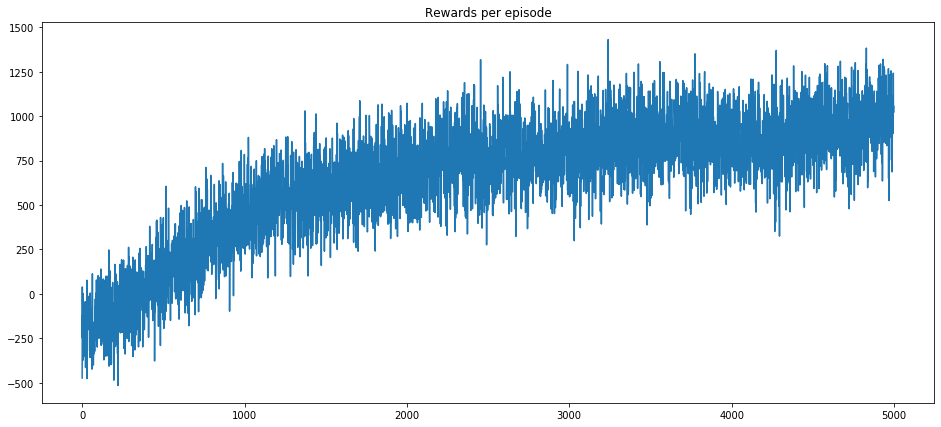

In [53]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)

In [54]:
#time = np.arange(0,10000)
#epsilon = []
#for i in range(0,10000):
#    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [55]:
#plt.plot(time, epsilon)
#plt.show()

In [56]:
### Reducing Learning rate Further

In [57]:
#### Final DQN block LR 0.001 and Episodes 5000

In [58]:
#Under Test
learning_rate = 0.001
agent = DQNAgent(36,21,learning_rate)
rewards_per_episode, episodes = [], []

for episode in range(Episodes):

    # Write code here
   
    # Call all the initialised variables of the environment
    state_space = env.state_space
    action_space = env.action_space
    state = env.state_init
    print("Initial State is ",state)
    time = 0
    #Call the DQN agent
    terminal_state = False
    score = 0
    action = agent.get_action(env.state_encod_arch1(state),env)
    score += env.reward_func(state,action_space[action],Time_matrix)
    next_state,ride_time = env.next_state_func(state,action_space[action],Time_matrix)
    time += ride_time
    if time >= 24*30:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),True)
    else:
        agent.append_sample(env.state_encod_arch1(state),action,score,env.state_encod_arch1(next_state),False)
    loop = 0
    while not terminal_state:
        
        # Write your code here
        
        if time >= 24*30:
            terminal_state = True
            pass
        state = next_state
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(env.state_encod_arch1(state),env)
        # 2. Evaluate your reward and next state
        reward_curr_ride = env.reward_func(state,action_space[action],Time_matrix)
        score+= reward_curr_ride
        next_state,ride_time = env.next_state_func(next_state,action_space[action],Time_matrix)
        time += ride_time
        # 3. Append the experience to the memory
        if time >= 24*30:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),True)
        else:
            agent.append_sample(env.state_encod_arch1(state),action,reward_curr_ride,env.state_encod_arch1(next_state),False)
        # 4. Train the model by calling function agent.train_model
        agent.train_model(env)
        #print('Time elapsed {} and current loop {}'.format(time,loop))
        loop+= 1
        # 5. Keep a track of rewards, Q-values, loss
    
    rewards_per_episode.append(score)   
    episodes.append(episode)
    
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
# every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon,time,loop))
    # every few episodes:
        # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    if episode % 1000 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()

        # save model weights
        agent.save(name="model_weights.h5")

Initial State is  [2, 7, 6]
episode 0, reward -208.0, memory_length 139, epsilon 0.999, time 729.0, rides 138
Initial State is  [2, 7, 6]
episode 1, reward -134.0, memory_length 270, epsilon 0.998001, time 725.0, rides 130
Initial State is  [2, 7, 6]
episode 2, reward -81.0, memory_length 411, epsilon 0.997002999, time 730.0, rides 140
Initial State is  [2, 7, 6]
episode 3, reward -607.0, memory_length 527, epsilon 0.996005996001, time 725.0, rides 115
Initial State is  [2, 7, 6]
episode 4, reward -171.0, memory_length 664, epsilon 0.995009990004999, time 720.0, rides 136
Initial State is  [2, 7, 6]
episode 5, reward -518.0, memory_length 802, epsilon 0.994014980014994, time 739.0, rides 137
Initial State is  [2, 7, 6]
episode 6, reward -70.0, memory_length 931, epsilon 0.993020965034979, time 725.0, rides 128
Initial State is  [2, 7, 6]
episode 7, reward -177.0, memory_length 1056, epsilon 0.9920279440699441, time 724.0, rides 124
Initial State is  [2, 7, 6]
episode 8, reward -532.0, 

episode 66, reward -100.0, memory_length 2000, epsilon 0.9351638519212846, time 724.0, rides 119
Initial State is  [2, 7, 6]
episode 67, reward -24.0, memory_length 2000, epsilon 0.9342286880693633, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 68, reward -37.0, memory_length 2000, epsilon 0.933294459381294, time 729.0, rides 123
Initial State is  [2, 7, 6]
episode 69, reward -96.0, memory_length 2000, epsilon 0.9323611649219127, time 733.0, rides 118
Initial State is  [2, 7, 6]
episode 70, reward -114.0, memory_length 2000, epsilon 0.9314288037569908, time 722.0, rides 135
Initial State is  [2, 7, 6]
episode 71, reward -340.0, memory_length 2000, epsilon 0.9304973749532338, time 730.0, rides 116
Initial State is  [2, 7, 6]
episode 72, reward -344.0, memory_length 2000, epsilon 0.9295668775782806, time 723.0, rides 120
Initial State is  [2, 7, 6]
episode 73, reward -88.0, memory_length 2000, epsilon 0.9286373107007023, time 731.0, rides 123
Initial State is  [2, 7, 6]
episo

episode 132, reward -278.0, memory_length 2000, epsilon 0.8754068367770318, time 732.0, rides 130
Initial State is  [2, 7, 6]
episode 133, reward -84.0, memory_length 2000, epsilon 0.8745314299402548, time 741.0, rides 120
Initial State is  [2, 7, 6]
episode 134, reward 353.0, memory_length 2000, epsilon 0.8736568985103146, time 732.0, rides 142
Initial State is  [2, 7, 6]
episode 135, reward -60.0, memory_length 2000, epsilon 0.8727832416118043, time 722.0, rides 119
Initial State is  [2, 7, 6]
episode 136, reward -109.0, memory_length 2000, epsilon 0.8719104583701925, time 732.0, rides 124
Initial State is  [2, 7, 6]
episode 137, reward -222.0, memory_length 2000, epsilon 0.8710385479118223, time 740.0, rides 127
Initial State is  [2, 7, 6]
episode 138, reward -75.0, memory_length 2000, epsilon 0.8701675093639105, time 721.0, rides 113
Initial State is  [2, 7, 6]
episode 139, reward -83.0, memory_length 2000, epsilon 0.8692973418545467, time 729.0, rides 125
Initial State is  [2, 7, 

episode 198, reward -182.0, memory_length 2000, epsilon 0.8194682977764125, time 726.0, rides 116
Initial State is  [2, 7, 6]
episode 199, reward 228.0, memory_length 2000, epsilon 0.818648829478636, time 723.0, rides 136
Initial State is  [2, 7, 6]
episode 200, reward -93.0, memory_length 2000, epsilon 0.8178301806491574, time 731.0, rides 109
Initial State is  [2, 7, 6]
episode 201, reward -188.0, memory_length 2000, epsilon 0.8170123504685082, time 729.0, rides 120
Initial State is  [2, 7, 6]
episode 202, reward -51.0, memory_length 2000, epsilon 0.8161953381180397, time 727.0, rides 115
Initial State is  [2, 7, 6]
episode 203, reward 3.0, memory_length 2000, epsilon 0.8153791427799216, time 734.0, rides 122
Initial State is  [2, 7, 6]
episode 204, reward 169.0, memory_length 2000, epsilon 0.8145637636371417, time 724.0, rides 131
Initial State is  [2, 7, 6]
episode 205, reward 97.0, memory_length 2000, epsilon 0.8137491998735046, time 732.0, rides 122
Initial State is  [2, 7, 6]
ep

episode 264, reward -13.0, memory_length 2000, epsilon 0.7671042341100781, time 726.0, rides 129
Initial State is  [2, 7, 6]
episode 265, reward -104.0, memory_length 2000, epsilon 0.766337129875968, time 741.0, rides 136
Initial State is  [2, 7, 6]
episode 266, reward 121.0, memory_length 2000, epsilon 0.7655707927460921, time 741.0, rides 131
Initial State is  [2, 7, 6]
episode 267, reward 52.0, memory_length 2000, epsilon 0.764805221953346, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 268, reward -124.0, memory_length 2000, epsilon 0.7640404167313927, time 730.0, rides 106
Initial State is  [2, 7, 6]
episode 269, reward -50.0, memory_length 2000, epsilon 0.7632763763146613, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 270, reward -242.0, memory_length 2000, epsilon 0.7625130999383466, time 729.0, rides 117
Initial State is  [2, 7, 6]
episode 271, reward 4.0, memory_length 2000, epsilon 0.7617505868384082, time 738.0, rides 108
Initial State is  [2, 7, 6]
ep

episode 330, reward 314.0, memory_length 2000, epsilon 0.7180862366321393, time 725.0, rides 123
Initial State is  [2, 7, 6]
episode 331, reward 165.0, memory_length 2000, epsilon 0.7173681503955072, time 725.0, rides 116
Initial State is  [2, 7, 6]
episode 332, reward 117.0, memory_length 2000, epsilon 0.7166507822451117, time 722.0, rides 129
Initial State is  [2, 7, 6]
episode 333, reward 353.0, memory_length 2000, epsilon 0.7159341314628666, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 334, reward 50.0, memory_length 2000, epsilon 0.7152181973314037, time 723.0, rides 137
Initial State is  [2, 7, 6]
episode 335, reward 425.0, memory_length 2000, epsilon 0.7145029791340722, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 336, reward -65.0, memory_length 2000, epsilon 0.7137884761549381, time 728.0, rides 114
Initial State is  [2, 7, 6]
episode 337, reward 40.0, memory_length 2000, epsilon 0.7130746876787832, time 726.0, rides 126
Initial State is  [2, 7, 6]
ep

episode 396, reward 46.0, memory_length 2000, epsilon 0.6722004915521225, time 733.0, rides 133
Initial State is  [2, 7, 6]
episode 397, reward 305.0, memory_length 2000, epsilon 0.6715282910605703, time 732.0, rides 135
Initial State is  [2, 7, 6]
episode 398, reward 11.0, memory_length 2000, epsilon 0.6708567627695098, time 727.0, rides 133
Initial State is  [2, 7, 6]
episode 399, reward -229.0, memory_length 2000, epsilon 0.6701859060067403, time 741.0, rides 134
Initial State is  [2, 7, 6]
episode 400, reward 98.0, memory_length 2000, epsilon 0.6695157201007336, time 724.0, rides 119
Initial State is  [2, 7, 6]
episode 401, reward 125.0, memory_length 2000, epsilon 0.6688462043806328, time 733.0, rides 121
Initial State is  [2, 7, 6]
episode 402, reward 166.0, memory_length 2000, epsilon 0.6681773581762521, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 403, reward 185.0, memory_length 2000, epsilon 0.6675091808180759, time 742.0, rides 136
Initial State is  [2, 7, 6]
ep

episode 462, reward 110.0, memory_length 2000, epsilon 0.6292468477910546, time 730.0, rides 108
Initial State is  [2, 7, 6]
episode 463, reward 169.0, memory_length 2000, epsilon 0.6286176009432635, time 737.0, rides 135
Initial State is  [2, 7, 6]
episode 464, reward 379.0, memory_length 2000, epsilon 0.6279889833423202, time 730.0, rides 130
Initial State is  [2, 7, 6]
episode 465, reward 325.0, memory_length 2000, epsilon 0.6273609943589779, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 466, reward 262.0, memory_length 2000, epsilon 0.6267336333646188, time 738.0, rides 121
Initial State is  [2, 7, 6]
episode 467, reward 191.0, memory_length 2000, epsilon 0.6261068997312542, time 729.0, rides 119
Initial State is  [2, 7, 6]
episode 468, reward 220.0, memory_length 2000, epsilon 0.6254807928315229, time 731.0, rides 116
Initial State is  [2, 7, 6]
episode 469, reward 17.0, memory_length 2000, epsilon 0.6248553120386914, time 742.0, rides 124
Initial State is  [2, 7, 6]
e

episode 528, reward 462.0, memory_length 2000, epsilon 0.5890379439335424, time 733.0, rides 148
Initial State is  [2, 7, 6]
episode 529, reward -39.0, memory_length 2000, epsilon 0.5884489059896089, time 738.0, rides 128
Initial State is  [2, 7, 6]
episode 530, reward 232.0, memory_length 2000, epsilon 0.5878604570836192, time 730.0, rides 125
Initial State is  [2, 7, 6]
episode 531, reward 90.0, memory_length 2000, epsilon 0.5872725966265356, time 731.0, rides 125
Initial State is  [2, 7, 6]
episode 532, reward 179.0, memory_length 2000, epsilon 0.5866853240299091, time 723.0, rides 124
Initial State is  [2, 7, 6]
episode 533, reward 146.0, memory_length 2000, epsilon 0.5860986387058792, time 728.0, rides 114
Initial State is  [2, 7, 6]
episode 534, reward 97.0, memory_length 2000, epsilon 0.5855125400671733, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 535, reward 390.0, memory_length 2000, epsilon 0.5849270275271061, time 732.0, rides 133
Initial State is  [2, 7, 6]
ep

episode 594, reward 420.0, memory_length 2000, epsilon 0.5513983909676525, time 738.0, rides 123
Initial State is  [2, 7, 6]
episode 595, reward 100.0, memory_length 2000, epsilon 0.5508469925766849, time 737.0, rides 129
Initial State is  [2, 7, 6]
episode 596, reward 116.0, memory_length 2000, epsilon 0.5502961455841082, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 597, reward 185.0, memory_length 2000, epsilon 0.5497458494385241, time 734.0, rides 120
Initial State is  [2, 7, 6]
episode 598, reward 136.0, memory_length 2000, epsilon 0.5491961035890855, time 733.0, rides 124
Initial State is  [2, 7, 6]
episode 599, reward 414.0, memory_length 2000, epsilon 0.5486469074854965, time 733.0, rides 134
Initial State is  [2, 7, 6]
episode 600, reward 249.0, memory_length 2000, epsilon 0.548098260578011, time 734.0, rides 128
Initial State is  [2, 7, 6]
episode 601, reward 335.0, memory_length 2000, epsilon 0.547550162317433, time 732.0, rides 120
Initial State is  [2, 7, 6]
ep

episode 660, reward 326.0, memory_length 2000, epsilon 0.5161640072477562, time 726.0, rides 121
Initial State is  [2, 7, 6]
episode 661, reward 127.0, memory_length 2000, epsilon 0.5156478432405085, time 726.0, rides 130
Initial State is  [2, 7, 6]
episode 662, reward 233.0, memory_length 2000, epsilon 0.515132195397268, time 732.0, rides 124
Initial State is  [2, 7, 6]
episode 663, reward 186.0, memory_length 2000, epsilon 0.5146170632018707, time 723.0, rides 117
Initial State is  [2, 7, 6]
episode 664, reward 438.0, memory_length 2000, epsilon 0.5141024461386688, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 665, reward 162.0, memory_length 2000, epsilon 0.5135883436925301, time 724.0, rides 122
Initial State is  [2, 7, 6]
episode 666, reward 47.0, memory_length 2000, epsilon 0.5130747553488376, time 724.0, rides 126
Initial State is  [2, 7, 6]
episode 667, reward 380.0, memory_length 2000, epsilon 0.5125616805934888, time 734.0, rides 132
Initial State is  [2, 7, 6]
ep

episode 726, reward 431.0, memory_length 2000, epsilon 0.4831811023432807, time 727.0, rides 127
Initial State is  [2, 7, 6]
episode 727, reward 296.0, memory_length 2000, epsilon 0.4826979212409374, time 733.0, rides 118
Initial State is  [2, 7, 6]
episode 728, reward 327.0, memory_length 2000, epsilon 0.48221522331969646, time 725.0, rides 124
Initial State is  [2, 7, 6]
episode 729, reward 172.0, memory_length 2000, epsilon 0.48173300809637676, time 727.0, rides 114
Initial State is  [2, 7, 6]
episode 730, reward 566.0, memory_length 2000, epsilon 0.48125127508828036, time 724.0, rides 130
Initial State is  [2, 7, 6]
episode 731, reward 302.0, memory_length 2000, epsilon 0.48077002381319206, time 726.0, rides 137
Initial State is  [2, 7, 6]
episode 732, reward 351.0, memory_length 2000, epsilon 0.48028925378937887, time 735.0, rides 146
Initial State is  [2, 7, 6]
episode 733, reward 196.0, memory_length 2000, epsilon 0.47980896453558947, time 729.0, rides 123
Initial State is  [2, 

episode 792, reward 180.0, memory_length 2000, epsilon 0.4523058066495642, time 734.0, rides 130
Initial State is  [2, 7, 6]
episode 793, reward 135.0, memory_length 2000, epsilon 0.45185350084291465, time 726.0, rides 123
Initial State is  [2, 7, 6]
episode 794, reward 693.0, memory_length 2000, epsilon 0.4514016473420717, time 730.0, rides 134
Initial State is  [2, 7, 6]
episode 795, reward 530.0, memory_length 2000, epsilon 0.45095024569472963, time 724.0, rides 133
Initial State is  [2, 7, 6]
episode 796, reward 615.0, memory_length 2000, epsilon 0.4504992954490349, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 797, reward 410.0, memory_length 2000, epsilon 0.45004879615358584, time 729.0, rides 130
Initial State is  [2, 7, 6]
episode 798, reward 554.0, memory_length 2000, epsilon 0.44959874735743227, time 722.0, rides 124
Initial State is  [2, 7, 6]
episode 799, reward 543.0, memory_length 2000, epsilon 0.4491491486100748, time 731.0, rides 126
Initial State is  [2, 7,

episode 858, reward 587.0, memory_length 2000, epsilon 0.4234034438366067, time 735.0, rides 136
Initial State is  [2, 7, 6]
episode 859, reward 305.0, memory_length 2000, epsilon 0.4229800403927701, time 733.0, rides 136
Initial State is  [2, 7, 6]
episode 860, reward 545.0, memory_length 2000, epsilon 0.42255706035237733, time 724.0, rides 118
Initial State is  [2, 7, 6]
episode 861, reward 734.0, memory_length 2000, epsilon 0.42213450329202495, time 727.0, rides 140
Initial State is  [2, 7, 6]
episode 862, reward 727.0, memory_length 2000, epsilon 0.4217123687887329, time 738.0, rides 133
Initial State is  [2, 7, 6]
episode 863, reward 199.0, memory_length 2000, epsilon 0.4212906564199442, time 733.0, rides 128
Initial State is  [2, 7, 6]
episode 864, reward 300.0, memory_length 2000, epsilon 0.42086936576352424, time 725.0, rides 132
Initial State is  [2, 7, 6]
episode 865, reward 664.0, memory_length 2000, epsilon 0.4204484963977607, time 728.0, rides 113
Initial State is  [2, 7, 

episode 924, reward 399.0, memory_length 2000, epsilon 0.3963479433983767, time 745.0, rides 117
Initial State is  [2, 7, 6]
episode 925, reward 561.0, memory_length 2000, epsilon 0.3959515954549783, time 722.0, rides 138
Initial State is  [2, 7, 6]
episode 926, reward 510.0, memory_length 2000, epsilon 0.39555564385952335, time 733.0, rides 126
Initial State is  [2, 7, 6]
episode 927, reward 345.0, memory_length 2000, epsilon 0.39516008821566384, time 731.0, rides 118
Initial State is  [2, 7, 6]
episode 928, reward 623.0, memory_length 2000, epsilon 0.3947649281274482, time 725.0, rides 130
Initial State is  [2, 7, 6]
episode 929, reward 419.0, memory_length 2000, epsilon 0.3943701631993207, time 729.0, rides 121
Initial State is  [2, 7, 6]
episode 930, reward 631.0, memory_length 2000, epsilon 0.3939757930361214, time 733.0, rides 122
Initial State is  [2, 7, 6]
episode 931, reward 476.0, memory_length 2000, epsilon 0.3935818172430853, time 736.0, rides 128
Initial State is  [2, 7, 6

episode 990, reward 735.0, memory_length 2000, epsilon 0.37102129074024554, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 991, reward 515.0, memory_length 2000, epsilon 0.3706502694495053, time 725.0, rides 115
Initial State is  [2, 7, 6]
episode 992, reward 720.0, memory_length 2000, epsilon 0.3702796191800558, time 731.0, rides 132
Initial State is  [2, 7, 6]
episode 993, reward 527.0, memory_length 2000, epsilon 0.36990933956087574, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 994, reward 433.0, memory_length 2000, epsilon 0.36953943022131486, time 732.0, rides 119
Initial State is  [2, 7, 6]
episode 995, reward 721.0, memory_length 2000, epsilon 0.3691698907910935, time 727.0, rides 120
Initial State is  [2, 7, 6]
episode 996, reward 379.0, memory_length 2000, epsilon 0.3688007209003024, time 732.0, rides 138
Initial State is  [2, 7, 6]
episode 997, reward 237.0, memory_length 2000, epsilon 0.36843192017940213, time 724.0, rides 113
Initial State is  [2, 7,

episode 1055, reward 727.0, memory_length 2000, epsilon 0.34766067307894, time 728.0, rides 140
Initial State is  [2, 7, 6]
episode 1056, reward 664.0, memory_length 2000, epsilon 0.34731301240586104, time 729.0, rides 118
Initial State is  [2, 7, 6]
episode 1057, reward 760.0, memory_length 2000, epsilon 0.3469656993934552, time 733.0, rides 121
Initial State is  [2, 7, 6]
episode 1058, reward 340.0, memory_length 2000, epsilon 0.3466187336940617, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 1059, reward 860.0, memory_length 2000, epsilon 0.34627211496036764, time 726.0, rides 123
Initial State is  [2, 7, 6]
episode 1060, reward 577.0, memory_length 2000, epsilon 0.3459258428454073, time 729.0, rides 135
Initial State is  [2, 7, 6]
episode 1061, reward 537.0, memory_length 2000, epsilon 0.34557991700256185, time 728.0, rides 137
Initial State is  [2, 7, 6]
episode 1062, reward 372.0, memory_length 2000, epsilon 0.3452343370855593, time 725.0, rides 127
Initial State is  [

episode 1120, reward 733.0, memory_length 2000, epsilon 0.325770910247633, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 1121, reward 301.0, memory_length 2000, epsilon 0.32544513933738534, time 728.0, rides 122
Initial State is  [2, 7, 6]
episode 1122, reward 660.0, memory_length 2000, epsilon 0.3251196941980479, time 724.0, rides 123
Initial State is  [2, 7, 6]
episode 1123, reward 670.0, memory_length 2000, epsilon 0.32479457450384985, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 1124, reward 600.0, memory_length 2000, epsilon 0.324469779929346, time 736.0, rides 111
Initial State is  [2, 7, 6]
episode 1125, reward 328.0, memory_length 2000, epsilon 0.32414531014941667, time 740.0, rides 135
Initial State is  [2, 7, 6]
episode 1126, reward 573.0, memory_length 2000, epsilon 0.32382116483926726, time 727.0, rides 118
Initial State is  [2, 7, 6]
episode 1127, reward 319.0, memory_length 2000, epsilon 0.323497343674428, time 737.0, rides 119
Initial State is  [

episode 1185, reward 1001.0, memory_length 2000, epsilon 0.30525939279728115, time 725.0, rides 124
Initial State is  [2, 7, 6]
episode 1186, reward 703.0, memory_length 2000, epsilon 0.30495413340448385, time 728.0, rides 118
Initial State is  [2, 7, 6]
episode 1187, reward 629.0, memory_length 2000, epsilon 0.3046491792710794, time 725.0, rides 129
Initial State is  [2, 7, 6]
episode 1188, reward 636.0, memory_length 2000, epsilon 0.3043445300918083, time 739.0, rides 123
Initial State is  [2, 7, 6]
episode 1189, reward 603.0, memory_length 2000, epsilon 0.30404018556171647, time 727.0, rides 119
Initial State is  [2, 7, 6]
episode 1190, reward 193.0, memory_length 2000, epsilon 0.30373614537615473, time 729.0, rides 111
Initial State is  [2, 7, 6]
episode 1191, reward 821.0, memory_length 2000, epsilon 0.3034324092307786, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 1192, reward 611.0, memory_length 2000, epsilon 0.3031289768215478, time 724.0, rides 127
Initial State i

episode 1250, reward 787.0, memory_length 2000, epsilon 0.28603934224861294, time 731.0, rides 125
Initial State is  [2, 7, 6]
episode 1251, reward 607.0, memory_length 2000, epsilon 0.2857533029063643, time 722.0, rides 131
Initial State is  [2, 7, 6]
episode 1252, reward 535.0, memory_length 2000, epsilon 0.28546754960345794, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 1253, reward 390.0, memory_length 2000, epsilon 0.2851820820538545, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 1254, reward 814.0, memory_length 2000, epsilon 0.2848968999718006, time 733.0, rides 121
Initial State is  [2, 7, 6]
episode 1255, reward 545.0, memory_length 2000, epsilon 0.2846120030718288, time 727.0, rides 125
Initial State is  [2, 7, 6]
episode 1256, reward 493.0, memory_length 2000, epsilon 0.284327391068757, time 722.0, rides 129
Initial State is  [2, 7, 6]
episode 1257, reward 532.0, memory_length 2000, epsilon 0.2840430636776882, time 733.0, rides 120
Initial State is  [

episode 1315, reward 617.0, memory_length 2000, epsilon 0.268029443956713, time 730.0, rides 141
Initial State is  [2, 7, 6]
episode 1316, reward 380.0, memory_length 2000, epsilon 0.2677614145127563, time 726.0, rides 117
Initial State is  [2, 7, 6]
episode 1317, reward 681.0, memory_length 2000, epsilon 0.2674936530982436, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 1318, reward 686.0, memory_length 2000, epsilon 0.26722615944514533, time 734.0, rides 124
Initial State is  [2, 7, 6]
episode 1319, reward 751.0, memory_length 2000, epsilon 0.2669589332857002, time 722.0, rides 126
Initial State is  [2, 7, 6]
episode 1320, reward 692.0, memory_length 2000, epsilon 0.2666919743524145, time 732.0, rides 123
Initial State is  [2, 7, 6]
episode 1321, reward 778.0, memory_length 2000, epsilon 0.26642528237806207, time 727.0, rides 133
Initial State is  [2, 7, 6]
episode 1322, reward 547.0, memory_length 2000, epsilon 0.266158857095684, time 734.0, rides 112
Initial State is  [2

episode 1380, reward 610.0, memory_length 2000, epsilon 0.25115350309155987, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 1381, reward 594.0, memory_length 2000, epsilon 0.2509023495884683, time 733.0, rides 124
Initial State is  [2, 7, 6]
episode 1382, reward 784.0, memory_length 2000, epsilon 0.25065144723887983, time 730.0, rides 120
Initial State is  [2, 7, 6]
episode 1383, reward 821.0, memory_length 2000, epsilon 0.25040079579164093, time 727.0, rides 118
Initial State is  [2, 7, 6]
episode 1384, reward 786.0, memory_length 2000, epsilon 0.2501503949958493, time 721.0, rides 134
Initial State is  [2, 7, 6]
episode 1385, reward 539.0, memory_length 2000, epsilon 0.24990024460085344, time 722.0, rides 123
Initial State is  [2, 7, 6]
episode 1386, reward 927.0, memory_length 2000, epsilon 0.24965034435625258, time 727.0, rides 124
Initial State is  [2, 7, 6]
episode 1387, reward 738.0, memory_length 2000, epsilon 0.24940069401189632, time 730.0, rides 126
Initial State 

episode 1445, reward 775.0, memory_length 2000, epsilon 0.2353401222790632, time 725.0, rides 126
Initial State is  [2, 7, 6]
episode 1446, reward 922.0, memory_length 2000, epsilon 0.23510478215678413, time 729.0, rides 143
Initial State is  [2, 7, 6]
episode 1447, reward 931.0, memory_length 2000, epsilon 0.23486967737462733, time 728.0, rides 132
Initial State is  [2, 7, 6]
episode 1448, reward 746.0, memory_length 2000, epsilon 0.2346348076972527, time 728.0, rides 112
Initial State is  [2, 7, 6]
episode 1449, reward 559.0, memory_length 2000, epsilon 0.23440017288955545, time 724.0, rides 125
Initial State is  [2, 7, 6]
episode 1450, reward 655.0, memory_length 2000, epsilon 0.2341657727166659, time 724.0, rides 124
Initial State is  [2, 7, 6]
episode 1451, reward 547.0, memory_length 2000, epsilon 0.2339316069439492, time 721.0, rides 125
Initial State is  [2, 7, 6]
episode 1452, reward 828.0, memory_length 2000, epsilon 0.23369767533700525, time 735.0, rides 125
Initial State is

episode 1510, reward 749.0, memory_length 2000, epsilon 0.22052239953879277, time 731.0, rides 120
Initial State is  [2, 7, 6]
episode 1511, reward 650.0, memory_length 2000, epsilon 0.22030187713925398, time 724.0, rides 133
Initial State is  [2, 7, 6]
episode 1512, reward 475.0, memory_length 2000, epsilon 0.22008157526211472, time 739.0, rides 118
Initial State is  [2, 7, 6]
episode 1513, reward 804.0, memory_length 2000, epsilon 0.2198614936868526, time 740.0, rides 125
Initial State is  [2, 7, 6]
episode 1514, reward 747.0, memory_length 2000, epsilon 0.21964163219316574, time 737.0, rides 123
Initial State is  [2, 7, 6]
episode 1515, reward 664.0, memory_length 2000, epsilon 0.21942199056097256, time 736.0, rides 139
Initial State is  [2, 7, 6]
episode 1516, reward 586.0, memory_length 2000, epsilon 0.2192025685704116, time 730.0, rides 131
Initial State is  [2, 7, 6]
episode 1517, reward 750.0, memory_length 2000, epsilon 0.21898336600184118, time 734.0, rides 122
Initial State 

episode 1575, reward 480.0, memory_length 2000, epsilon 0.20663764524045758, time 725.0, rides 137
Initial State is  [2, 7, 6]
episode 1576, reward 760.0, memory_length 2000, epsilon 0.20643100759521713, time 729.0, rides 124
Initial State is  [2, 7, 6]
episode 1577, reward 516.0, memory_length 2000, epsilon 0.20622457658762192, time 725.0, rides 134
Initial State is  [2, 7, 6]
episode 1578, reward 595.0, memory_length 2000, epsilon 0.2060183520110343, time 725.0, rides 122
Initial State is  [2, 7, 6]
episode 1579, reward 631.0, memory_length 2000, epsilon 0.20581233365902327, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 1580, reward 979.0, memory_length 2000, epsilon 0.20560652132536425, time 737.0, rides 132
Initial State is  [2, 7, 6]
episode 1581, reward 808.0, memory_length 2000, epsilon 0.20540091480403888, time 727.0, rides 127
Initial State is  [2, 7, 6]
episode 1582, reward 985.0, memory_length 2000, epsilon 0.20519551388923485, time 727.0, rides 119
Initial State

episode 1640, reward 762.0, memory_length 2000, epsilon 0.19362711688165665, time 727.0, rides 131
Initial State is  [2, 7, 6]
episode 1641, reward 857.0, memory_length 2000, epsilon 0.193433489764775, time 730.0, rides 127
Initial State is  [2, 7, 6]
episode 1642, reward 781.0, memory_length 2000, epsilon 0.19324005627501023, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 1643, reward 799.0, memory_length 2000, epsilon 0.1930468162187352, time 730.0, rides 133
Initial State is  [2, 7, 6]
episode 1644, reward 803.0, memory_length 2000, epsilon 0.19285376940251647, time 730.0, rides 117
Initial State is  [2, 7, 6]
episode 1645, reward 579.0, memory_length 2000, epsilon 0.19266091563311397, time 724.0, rides 117
Initial State is  [2, 7, 6]
episode 1646, reward 827.0, memory_length 2000, epsilon 0.19246825471748086, time 732.0, rides 131
Initial State is  [2, 7, 6]
episode 1647, reward 710.0, memory_length 2000, epsilon 0.1922757864627634, time 731.0, rides 136
Initial State is

episode 1705, reward 536.0, memory_length 2000, epsilon 0.1814357705648218, time 730.0, rides 121
Initial State is  [2, 7, 6]
episode 1706, reward 541.0, memory_length 2000, epsilon 0.18125433479425698, time 726.0, rides 118
Initial State is  [2, 7, 6]
episode 1707, reward 976.0, memory_length 2000, epsilon 0.18107308045946272, time 726.0, rides 114
Initial State is  [2, 7, 6]
episode 1708, reward 802.0, memory_length 2000, epsilon 0.18089200737900324, time 727.0, rides 118
Initial State is  [2, 7, 6]
episode 1709, reward 682.0, memory_length 2000, epsilon 0.18071111537162424, time 724.0, rides 120
Initial State is  [2, 7, 6]
episode 1710, reward 887.0, memory_length 2000, epsilon 0.1805304042562526, time 725.0, rides 129
Initial State is  [2, 7, 6]
episode 1711, reward 880.0, memory_length 2000, epsilon 0.18034987385199636, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 1712, reward 627.0, memory_length 2000, epsilon 0.18016952397814437, time 724.0, rides 124
Initial State 

episode 1770, reward 765.0, memory_length 2000, epsilon 0.17001202812192093, time 731.0, rides 134
Initial State is  [2, 7, 6]
episode 1771, reward 658.0, memory_length 2000, epsilon 0.169842016093799, time 725.0, rides 136
Initial State is  [2, 7, 6]
episode 1772, reward 871.0, memory_length 2000, epsilon 0.1696721740777052, time 734.0, rides 124
Initial State is  [2, 7, 6]
episode 1773, reward 888.0, memory_length 2000, epsilon 0.1695025019036275, time 732.0, rides 126
Initial State is  [2, 7, 6]
episode 1774, reward 697.0, memory_length 2000, epsilon 0.1693329994017239, time 724.0, rides 123
Initial State is  [2, 7, 6]
episode 1775, reward 884.0, memory_length 2000, epsilon 0.16916366640232217, time 728.0, rides 127
Initial State is  [2, 7, 6]
episode 1776, reward 580.0, memory_length 2000, epsilon 0.16899450273591984, time 732.0, rides 139
Initial State is  [2, 7, 6]
episode 1777, reward 646.0, memory_length 2000, epsilon 0.16882550823318393, time 724.0, rides 123
Initial State is 

episode 1835, reward 624.0, memory_length 2000, epsilon 0.15930755890168982, time 733.0, rides 115
Initial State is  [2, 7, 6]
episode 1836, reward 800.0, memory_length 2000, epsilon 0.15914825134278812, time 725.0, rides 121
Initial State is  [2, 7, 6]
episode 1837, reward 832.0, memory_length 2000, epsilon 0.15898910309144534, time 730.0, rides 133
Initial State is  [2, 7, 6]
episode 1838, reward 697.0, memory_length 2000, epsilon 0.1588301139883539, time 730.0, rides 136
Initial State is  [2, 7, 6]
episode 1839, reward 692.0, memory_length 2000, epsilon 0.15867128387436555, time 729.0, rides 117
Initial State is  [2, 7, 6]
episode 1840, reward 650.0, memory_length 2000, epsilon 0.15851261259049118, time 728.0, rides 123
Initial State is  [2, 7, 6]
episode 1841, reward 719.0, memory_length 2000, epsilon 0.1583540999779007, time 726.0, rides 130
Initial State is  [2, 7, 6]
episode 1842, reward 840.0, memory_length 2000, epsilon 0.1581957458779228, time 723.0, rides 133
Initial State i

episode 1900, reward 910.0, memory_length 2000, epsilon 0.14927707529619813, time 727.0, rides 126
Initial State is  [2, 7, 6]
episode 1901, reward 829.0, memory_length 2000, epsilon 0.14912779822090194, time 732.0, rides 129
Initial State is  [2, 7, 6]
episode 1902, reward 735.0, memory_length 2000, epsilon 0.14897867042268104, time 733.0, rides 119
Initial State is  [2, 7, 6]
episode 1903, reward 912.0, memory_length 2000, epsilon 0.14882969175225835, time 733.0, rides 131
Initial State is  [2, 7, 6]
episode 1904, reward 993.0, memory_length 2000, epsilon 0.1486808620605061, time 735.0, rides 135
Initial State is  [2, 7, 6]
episode 1905, reward 970.0, memory_length 2000, epsilon 0.14853218119844558, time 736.0, rides 130
Initial State is  [2, 7, 6]
episode 1906, reward 344.0, memory_length 2000, epsilon 0.14838364901724713, time 739.0, rides 124
Initial State is  [2, 7, 6]
episode 1907, reward 748.0, memory_length 2000, epsilon 0.14823526536822987, time 724.0, rides 127
Initial State

episode 1965, reward 957.0, memory_length 2000, epsilon 0.1398781411416785, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 1966, reward 597.0, memory_length 2000, epsilon 0.13973826300053682, time 733.0, rides 124
Initial State is  [2, 7, 6]
episode 1967, reward 927.0, memory_length 2000, epsilon 0.13959852473753628, time 731.0, rides 140
Initial State is  [2, 7, 6]
episode 1968, reward 771.0, memory_length 2000, epsilon 0.13945892621279873, time 728.0, rides 136
Initial State is  [2, 7, 6]
episode 1969, reward 828.0, memory_length 2000, epsilon 0.13931946728658592, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 1970, reward 733.0, memory_length 2000, epsilon 0.13918014781929933, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 1971, reward 712.0, memory_length 2000, epsilon 0.13904096767148003, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 1972, reward 734.0, memory_length 2000, epsilon 0.13890192670380855, time 730.0, rides 141
Initial State

episode 2030, reward 815.0, memory_length 2000, epsilon 0.13107099218301493, time 721.0, rides 132
Initial State is  [2, 7, 6]
episode 2031, reward 1051.0, memory_length 2000, epsilon 0.13093992119083192, time 734.0, rides 138
Initial State is  [2, 7, 6]
episode 2032, reward 744.0, memory_length 2000, epsilon 0.13080898126964108, time 723.0, rides 119
Initial State is  [2, 7, 6]
episode 2033, reward 851.0, memory_length 2000, epsilon 0.13067817228837145, time 723.0, rides 122
Initial State is  [2, 7, 6]
episode 2034, reward 792.0, memory_length 2000, epsilon 0.13054749411608307, time 722.0, rides 126
Initial State is  [2, 7, 6]
episode 2035, reward 969.0, memory_length 2000, epsilon 0.13041694662196698, time 727.0, rides 130
Initial State is  [2, 7, 6]
episode 2036, reward 666.0, memory_length 2000, epsilon 0.13028652967534501, time 727.0, rides 123
Initial State is  [2, 7, 6]
episode 2037, reward 804.0, memory_length 2000, epsilon 0.13015624314566968, time 736.0, rides 138
Initial Sta

episode 2095, reward 639.0, memory_length 2000, epsilon 0.12281836784232969, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 2096, reward 736.0, memory_length 2000, epsilon 0.12269554947448735, time 729.0, rides 139
Initial State is  [2, 7, 6]
episode 2097, reward 852.0, memory_length 2000, epsilon 0.12257285392501287, time 730.0, rides 123
Initial State is  [2, 7, 6]
episode 2098, reward 766.0, memory_length 2000, epsilon 0.12245028107108785, time 732.0, rides 123
Initial State is  [2, 7, 6]
episode 2099, reward 1074.0, memory_length 2000, epsilon 0.12232783079001676, time 730.0, rides 141
Initial State is  [2, 7, 6]
episode 2100, reward 580.0, memory_length 2000, epsilon 0.12220550295922675, time 725.0, rides 137
Initial State is  [2, 7, 6]
episode 2101, reward 1331.0, memory_length 2000, epsilon 0.12208329745626752, time 726.0, rides 121
Initial State is  [2, 7, 6]
episode 2102, reward 766.0, memory_length 2000, epsilon 0.12196121415881125, time 725.0, rides 130
Initial St

episode 2160, reward 905.0, memory_length 2000, epsilon 0.11508535357992454, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 2161, reward 1287.0, memory_length 2000, epsilon 0.11497026822634461, time 739.0, rides 136
Initial State is  [2, 7, 6]
episode 2162, reward 639.0, memory_length 2000, epsilon 0.11485529795811826, time 731.0, rides 136
Initial State is  [2, 7, 6]
episode 2163, reward 1203.0, memory_length 2000, epsilon 0.11474044266016015, time 728.0, rides 127
Initial State is  [2, 7, 6]
episode 2164, reward 956.0, memory_length 2000, epsilon 0.11462570221749999, time 730.0, rides 124
Initial State is  [2, 7, 6]
episode 2165, reward 810.0, memory_length 2000, epsilon 0.11451107651528249, time 728.0, rides 122
Initial State is  [2, 7, 6]
episode 2166, reward 1107.0, memory_length 2000, epsilon 0.11439656543876721, time 727.0, rides 125
Initial State is  [2, 7, 6]
episode 2167, reward 904.0, memory_length 2000, epsilon 0.11428216887332844, time 729.0, rides 133
Initial S

episode 2225, reward 1020.0, memory_length 2000, epsilon 0.10783923318065335, time 727.0, rides 123
Initial State is  [2, 7, 6]
episode 2226, reward 794.0, memory_length 2000, epsilon 0.10773139394747269, time 721.0, rides 136
Initial State is  [2, 7, 6]
episode 2227, reward 875.0, memory_length 2000, epsilon 0.10762366255352522, time 734.0, rides 134
Initial State is  [2, 7, 6]
episode 2228, reward 860.0, memory_length 2000, epsilon 0.1075160388909717, time 736.0, rides 127
Initial State is  [2, 7, 6]
episode 2229, reward 1273.0, memory_length 2000, epsilon 0.10740852285208072, time 734.0, rides 121
Initial State is  [2, 7, 6]
episode 2230, reward 1032.0, memory_length 2000, epsilon 0.10730111432922863, time 734.0, rides 129
Initial State is  [2, 7, 6]
episode 2231, reward 784.0, memory_length 2000, epsilon 0.1071938132148994, time 731.0, rides 114
Initial State is  [2, 7, 6]
episode 2232, reward 730.0, memory_length 2000, epsilon 0.1070866194016845, time 730.0, rides 124
Initial Stat

episode 2290, reward 989.0, memory_length 2000, epsilon 0.10104935034078859, time 732.0, rides 137
Initial State is  [2, 7, 6]
episode 2291, reward 736.0, memory_length 2000, epsilon 0.1009483009904478, time 722.0, rides 132
Initial State is  [2, 7, 6]
episode 2292, reward 708.0, memory_length 2000, epsilon 0.10084735268945735, time 726.0, rides 134
Initial State is  [2, 7, 6]
episode 2293, reward 1212.0, memory_length 2000, epsilon 0.10074650533676789, time 741.0, rides 131
Initial State is  [2, 7, 6]
episode 2294, reward 841.0, memory_length 2000, epsilon 0.10064575883143112, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 2295, reward 784.0, memory_length 2000, epsilon 0.1005451130725997, time 728.0, rides 116
Initial State is  [2, 7, 6]
episode 2296, reward 844.0, memory_length 2000, epsilon 0.1004445679595271, time 735.0, rides 131
Initial State is  [2, 7, 6]
episode 2297, reward 1135.0, memory_length 2000, epsilon 0.10034412339156756, time 722.0, rides 128
Initial State

episode 2355, reward 888.0, memory_length 2000, epsilon 0.09468697896979585, time 726.0, rides 132
Initial State is  [2, 7, 6]
episode 2356, reward 829.0, memory_length 2000, epsilon 0.09459229199082606, time 736.0, rides 128
Initial State is  [2, 7, 6]
episode 2357, reward 885.0, memory_length 2000, epsilon 0.09449769969883523, time 735.0, rides 131
Initial State is  [2, 7, 6]
episode 2358, reward 977.0, memory_length 2000, epsilon 0.09440320199913639, time 741.0, rides 131
Initial State is  [2, 7, 6]
episode 2359, reward 815.0, memory_length 2000, epsilon 0.09430879879713726, time 725.0, rides 129
Initial State is  [2, 7, 6]
episode 2360, reward 1119.0, memory_length 2000, epsilon 0.09421448999834012, time 735.0, rides 124
Initial State is  [2, 7, 6]
episode 2361, reward 1050.0, memory_length 2000, epsilon 0.09412027550834177, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 2362, reward 726.0, memory_length 2000, epsilon 0.09402615523283343, time 740.0, rides 116
Initial St

episode 2420, reward 1016.0, memory_length 2000, epsilon 0.0887252016582989, time 737.0, rides 131
Initial State is  [2, 7, 6]
episode 2421, reward 1200.0, memory_length 2000, epsilon 0.0886364764566406, time 734.0, rides 131
Initial State is  [2, 7, 6]
episode 2422, reward 1118.0, memory_length 2000, epsilon 0.08854783998018396, time 727.0, rides 134
Initial State is  [2, 7, 6]
episode 2423, reward 908.0, memory_length 2000, epsilon 0.08845929214020377, time 729.0, rides 138
Initial State is  [2, 7, 6]
episode 2424, reward 1057.0, memory_length 2000, epsilon 0.08837083284806357, time 721.0, rides 132
Initial State is  [2, 7, 6]
episode 2425, reward 958.0, memory_length 2000, epsilon 0.08828246201521552, time 739.0, rides 143
Initial State is  [2, 7, 6]
episode 2426, reward 1329.0, memory_length 2000, epsilon 0.0881941795532003, time 733.0, rides 132
Initial State is  [2, 7, 6]
episode 2427, reward 943.0, memory_length 2000, epsilon 0.0881059853736471, time 727.0, rides 122
Initial Sta

episode 2485, reward 1118.0, memory_length 2000, epsilon 0.08313879579806785, time 729.0, rides 141
Initial State is  [2, 7, 6]
episode 2486, reward 714.0, memory_length 2000, epsilon 0.08305565700226979, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 2487, reward 638.0, memory_length 2000, epsilon 0.08297260134526752, time 725.0, rides 130
Initial State is  [2, 7, 6]
episode 2488, reward 1176.0, memory_length 2000, epsilon 0.08288962874392225, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 2489, reward 872.0, memory_length 2000, epsilon 0.08280673911517833, time 730.0, rides 138
Initial State is  [2, 7, 6]
episode 2490, reward 630.0, memory_length 2000, epsilon 0.08272393237606315, time 734.0, rides 113
Initial State is  [2, 7, 6]
episode 2491, reward 1065.0, memory_length 2000, epsilon 0.0826412084436871, time 729.0, rides 131
Initial State is  [2, 7, 6]
episode 2492, reward 1000.0, memory_length 2000, epsilon 0.08255856723524341, time 725.0, rides 115
Initial S

episode 2550, reward 883.0, memory_length 2000, epsilon 0.07790412687223583, time 729.0, rides 132
Initial State is  [2, 7, 6]
episode 2551, reward 960.0, memory_length 2000, epsilon 0.07782622274536359, time 728.0, rides 134
Initial State is  [2, 7, 6]
episode 2552, reward 867.0, memory_length 2000, epsilon 0.07774839652261822, time 740.0, rides 132
Initial State is  [2, 7, 6]
episode 2553, reward 798.0, memory_length 2000, epsilon 0.0776706481260956, time 735.0, rides 133
Initial State is  [2, 7, 6]
episode 2554, reward 963.0, memory_length 2000, epsilon 0.0775929774779695, time 729.0, rides 133
Initial State is  [2, 7, 6]
episode 2555, reward 780.0, memory_length 2000, epsilon 0.07751538450049153, time 734.0, rides 131
Initial State is  [2, 7, 6]
episode 2556, reward 1103.0, memory_length 2000, epsilon 0.07743786911599104, time 724.0, rides 121
Initial State is  [2, 7, 6]
episode 2557, reward 886.0, memory_length 2000, epsilon 0.07736043124687506, time 728.0, rides 134
Initial State

episode 2615, reward 858.0, memory_length 2000, epsilon 0.07299904846428458, time 725.0, rides 116
Initial State is  [2, 7, 6]
episode 2616, reward 897.0, memory_length 2000, epsilon 0.0729260494158203, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 2617, reward 1023.0, memory_length 2000, epsilon 0.07285312336640448, time 723.0, rides 128
Initial State is  [2, 7, 6]
episode 2618, reward 1105.0, memory_length 2000, epsilon 0.07278027024303808, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 2619, reward 892.0, memory_length 2000, epsilon 0.07270748997279504, time 731.0, rides 117
Initial State is  [2, 7, 6]
episode 2620, reward 953.0, memory_length 2000, epsilon 0.07263478248282225, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 2621, reward 1058.0, memory_length 2000, epsilon 0.07256214770033943, time 733.0, rides 137
Initial State is  [2, 7, 6]
episode 2622, reward 1175.0, memory_length 2000, epsilon 0.0724895855526391, time 729.0, rides 124
Initial St

episode 2680, reward 1090.0, memory_length 2000, epsilon 0.06840280856276588, time 741.0, rides 122
Initial State is  [2, 7, 6]
episode 2681, reward 1135.0, memory_length 2000, epsilon 0.06833440575420312, time 729.0, rides 120
Initial State is  [2, 7, 6]
episode 2682, reward 926.0, memory_length 2000, epsilon 0.06826607134844892, time 722.0, rides 130
Initial State is  [2, 7, 6]
episode 2683, reward 1007.0, memory_length 2000, epsilon 0.06819780527710047, time 727.0, rides 135
Initial State is  [2, 7, 6]
episode 2684, reward 1057.0, memory_length 2000, epsilon 0.06812960747182337, time 729.0, rides 135
Initial State is  [2, 7, 6]
episode 2685, reward 1199.0, memory_length 2000, epsilon 0.06806147786435154, time 725.0, rides 126
Initial State is  [2, 7, 6]
episode 2686, reward 1082.0, memory_length 2000, epsilon 0.06799341638648719, time 739.0, rides 127
Initial State is  [2, 7, 6]
episode 2687, reward 1393.0, memory_length 2000, epsilon 0.06792542297010071, time 730.0, rides 126
Initi

episode 2745, reward 1319.0, memory_length 2000, epsilon 0.06409596176535942, time 725.0, rides 123
Initial State is  [2, 7, 6]
episode 2746, reward 1019.0, memory_length 2000, epsilon 0.06403186580359406, time 732.0, rides 132
Initial State is  [2, 7, 6]
episode 2747, reward 1000.0, memory_length 2000, epsilon 0.06396783393779047, time 730.0, rides 130
Initial State is  [2, 7, 6]
episode 2748, reward 962.0, memory_length 2000, epsilon 0.06390386610385268, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 2749, reward 906.0, memory_length 2000, epsilon 0.06383996223774882, time 739.0, rides 125
Initial State is  [2, 7, 6]
episode 2750, reward 1373.0, memory_length 2000, epsilon 0.06377612227551108, time 732.0, rides 135
Initial State is  [2, 7, 6]
episode 2751, reward 806.0, memory_length 2000, epsilon 0.06371234615323557, time 728.0, rides 141
Initial State is  [2, 7, 6]
episode 2752, reward 1153.0, memory_length 2000, epsilon 0.06364863380708233, time 730.0, rides 123
Initial

episode 2810, reward 1012.0, memory_length 2000, epsilon 0.06006028701082751, time 726.0, rides 123
Initial State is  [2, 7, 6]
episode 2811, reward 842.0, memory_length 2000, epsilon 0.060000226723816684, time 734.0, rides 131
Initial State is  [2, 7, 6]
episode 2812, reward 893.0, memory_length 2000, epsilon 0.059940226497092866, time 739.0, rides 130
Initial State is  [2, 7, 6]
episode 2813, reward 969.0, memory_length 2000, epsilon 0.05988028627059577, time 723.0, rides 117
Initial State is  [2, 7, 6]
episode 2814, reward 886.0, memory_length 2000, epsilon 0.05982040598432518, time 731.0, rides 123
Initial State is  [2, 7, 6]
episode 2815, reward 1131.0, memory_length 2000, epsilon 0.05976058557834085, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 2816, reward 1001.0, memory_length 2000, epsilon 0.05970082499276251, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 2817, reward 1259.0, memory_length 2000, epsilon 0.059641124167769746, time 731.0, rides 118
Initi

episode 2875, reward 1300.0, memory_length 2000, epsilon 0.05627871049081451, time 738.0, rides 127
Initial State is  [2, 7, 6]
episode 2876, reward 1322.0, memory_length 2000, epsilon 0.0562224317803237, time 728.0, rides 124
Initial State is  [2, 7, 6]
episode 2877, reward 1139.0, memory_length 2000, epsilon 0.056166209348543376, time 736.0, rides 130
Initial State is  [2, 7, 6]
episode 2878, reward 1065.0, memory_length 2000, epsilon 0.056110043139194835, time 723.0, rides 124
Initial State is  [2, 7, 6]
episode 2879, reward 1078.0, memory_length 2000, epsilon 0.05605393309605564, time 729.0, rides 113
Initial State is  [2, 7, 6]
episode 2880, reward 1014.0, memory_length 2000, epsilon 0.055997879162959584, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 2881, reward 1239.0, memory_length 2000, epsilon 0.055941881283796624, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 2882, reward 989.0, memory_length 2000, epsilon 0.055885939402512824, time 730.0, rides 132
I

episode 2940, reward 863.0, memory_length 2000, epsilon 0.052735233415350184, time 725.0, rides 140
Initial State is  [2, 7, 6]
episode 2941, reward 711.0, memory_length 2000, epsilon 0.052682498181934836, time 724.0, rides 117
Initial State is  [2, 7, 6]
episode 2942, reward 944.0, memory_length 2000, epsilon 0.052629815683752905, time 736.0, rides 137
Initial State is  [2, 7, 6]
episode 2943, reward 847.0, memory_length 2000, epsilon 0.05257718586806915, time 731.0, rides 126
Initial State is  [2, 7, 6]
episode 2944, reward 917.0, memory_length 2000, epsilon 0.05252460868220108, time 726.0, rides 124
Initial State is  [2, 7, 6]
episode 2945, reward 1017.0, memory_length 2000, epsilon 0.05247208407351888, time 732.0, rides 129
Initial State is  [2, 7, 6]
episode 2946, reward 1233.0, memory_length 2000, epsilon 0.052419611989445364, time 729.0, rides 144
Initial State is  [2, 7, 6]
episode 2947, reward 1044.0, memory_length 2000, epsilon 0.05236719237745592, time 729.0, rides 125
Initi

episode 3005, reward 1025.0, memory_length 2000, epsilon 0.04941486432645551, time 723.0, rides 133
Initial State is  [2, 7, 6]
episode 3006, reward 888.0, memory_length 2000, epsilon 0.049365449462129056, time 735.0, rides 130
Initial State is  [2, 7, 6]
episode 3007, reward 781.0, memory_length 2000, epsilon 0.049316084012666926, time 732.0, rides 126
Initial State is  [2, 7, 6]
episode 3008, reward 1104.0, memory_length 2000, epsilon 0.04926676792865426, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 3009, reward 1036.0, memory_length 2000, epsilon 0.0492175011607256, time 726.0, rides 124
Initial State is  [2, 7, 6]
episode 3010, reward 841.0, memory_length 2000, epsilon 0.049168283659564875, time 728.0, rides 121
Initial State is  [2, 7, 6]
episode 3011, reward 1033.0, memory_length 2000, epsilon 0.04911911537590531, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 3012, reward 995.0, memory_length 2000, epsilon 0.04906999626052941, time 726.0, rides 127
Initia

episode 3069, reward 948.0, memory_length 2000, epsilon 0.046349905579066174, time 730.0, rides 119
Initial State is  [2, 7, 6]
episode 3070, reward 1183.0, memory_length 2000, epsilon 0.04630355567348711, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 3071, reward 717.0, memory_length 2000, epsilon 0.046257252117813626, time 724.0, rides 132
Initial State is  [2, 7, 6]
episode 3072, reward 737.0, memory_length 2000, epsilon 0.04621099486569581, time 727.0, rides 130
Initial State is  [2, 7, 6]
episode 3073, reward 1115.0, memory_length 2000, epsilon 0.04616478387083012, time 732.0, rides 122
Initial State is  [2, 7, 6]
episode 3074, reward 1130.0, memory_length 2000, epsilon 0.04611861908695929, time 725.0, rides 139
Initial State is  [2, 7, 6]
episode 3075, reward 1157.0, memory_length 2000, epsilon 0.04607250046787233, time 725.0, rides 127
Initial State is  [2, 7, 6]
episode 3076, reward 1012.0, memory_length 2000, epsilon 0.04602642796740446, time 723.0, rides 117
Initi

episode 3134, reward 1100.0, memory_length 2000, epsilon 0.0434315759578471, time 726.0, rides 130
Initial State is  [2, 7, 6]
episode 3135, reward 1296.0, memory_length 2000, epsilon 0.04338814438188925, time 731.0, rides 127
Initial State is  [2, 7, 6]
episode 3136, reward 1231.0, memory_length 2000, epsilon 0.043344756237507366, time 735.0, rides 141
Initial State is  [2, 7, 6]
episode 3137, reward 1064.0, memory_length 2000, epsilon 0.043301411481269855, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 3138, reward 1236.0, memory_length 2000, epsilon 0.04325811006978859, time 723.0, rides 128
Initial State is  [2, 7, 6]
episode 3139, reward 1068.0, memory_length 2000, epsilon 0.043214851959718796, time 730.0, rides 137
Initial State is  [2, 7, 6]
episode 3140, reward 1112.0, memory_length 2000, epsilon 0.04317163710775908, time 735.0, rides 141
Initial State is  [2, 7, 6]
episode 3141, reward 1041.0, memory_length 2000, epsilon 0.04312846547065132, time 730.0, rides 145
In

episode 3199, reward 1064.0, memory_length 2000, epsilon 0.04069699315707315, time 730.0, rides 132
Initial State is  [2, 7, 6]
episode 3200, reward 1415.0, memory_length 2000, epsilon 0.04065629616391608, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 3201, reward 804.0, memory_length 2000, epsilon 0.040615639867752164, time 729.0, rides 123
Initial State is  [2, 7, 6]
episode 3202, reward 768.0, memory_length 2000, epsilon 0.040575024227884414, time 725.0, rides 120
Initial State is  [2, 7, 6]
episode 3203, reward 1145.0, memory_length 2000, epsilon 0.04053444920365653, time 733.0, rides 123
Initial State is  [2, 7, 6]
episode 3204, reward 911.0, memory_length 2000, epsilon 0.040493914754452874, time 729.0, rides 131
Initial State is  [2, 7, 6]
episode 3205, reward 1144.0, memory_length 2000, epsilon 0.04045342083969842, time 730.0, rides 121
Initial State is  [2, 7, 6]
episode 3206, reward 841.0, memory_length 2000, epsilon 0.04041296741885872, time 727.0, rides 128
Initi

episode 3264, reward 801.0, memory_length 2000, epsilon 0.03813458792364205, time 737.0, rides 122
Initial State is  [2, 7, 6]
episode 3265, reward 1146.0, memory_length 2000, epsilon 0.03809645333571841, time 727.0, rides 135
Initial State is  [2, 7, 6]
episode 3266, reward 983.0, memory_length 2000, epsilon 0.03805835688238269, time 720.0, rides 115
Initial State is  [2, 7, 6]
episode 3267, reward 1346.0, memory_length 2000, epsilon 0.038020298525500304, time 723.0, rides 121
Initial State is  [2, 7, 6]
episode 3268, reward 868.0, memory_length 2000, epsilon 0.0379822782269748, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 3269, reward 1033.0, memory_length 2000, epsilon 0.037944295948747826, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 3270, reward 1279.0, memory_length 2000, epsilon 0.03790635165279908, time 729.0, rides 133
Initial State is  [2, 7, 6]
episode 3271, reward 1031.0, memory_length 2000, epsilon 0.037868445301146275, time 729.0, rides 125
Initi

episode 3329, reward 924.0, memory_length 2000, epsilon 0.035733519439463464, time 733.0, rides 123
Initial State is  [2, 7, 6]
episode 3330, reward 860.0, memory_length 2000, epsilon 0.035697785920024, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 3331, reward 924.0, memory_length 2000, epsilon 0.03566208813410397, time 732.0, rides 128
Initial State is  [2, 7, 6]
episode 3332, reward 1153.0, memory_length 2000, epsilon 0.03562642604596987, time 725.0, rides 126
Initial State is  [2, 7, 6]
episode 3333, reward 1115.0, memory_length 2000, epsilon 0.035590799619923896, time 733.0, rides 125
Initial State is  [2, 7, 6]
episode 3334, reward 919.0, memory_length 2000, epsilon 0.035555208820303975, time 724.0, rides 125
Initial State is  [2, 7, 6]
episode 3335, reward 970.0, memory_length 2000, epsilon 0.035519653611483674, time 734.0, rides 130
Initial State is  [2, 7, 6]
episode 3336, reward 1215.0, memory_length 2000, epsilon 0.03548413395787219, time 721.0, rides 128
Initial

episode 3394, reward 1222.0, memory_length 2000, epsilon 0.03348362945699728, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 3395, reward 1154.0, memory_length 2000, epsilon 0.03345014582754029, time 724.0, rides 130
Initial State is  [2, 7, 6]
episode 3396, reward 1053.0, memory_length 2000, epsilon 0.033416695681712745, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 3397, reward 1164.0, memory_length 2000, epsilon 0.03338327898603103, time 725.0, rides 124
Initial State is  [2, 7, 6]
episode 3398, reward 1397.0, memory_length 2000, epsilon 0.033349895707044996, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 3399, reward 1176.0, memory_length 2000, epsilon 0.03331654581133795, time 721.0, rides 134
Initial State is  [2, 7, 6]
episode 3400, reward 1031.0, memory_length 2000, epsilon 0.03328322926552661, time 734.0, rides 129
Initial State is  [2, 7, 6]
episode 3401, reward 1240.0, memory_length 2000, epsilon 0.03324994603626109, time 726.0, rides 124
In

episode 3458, reward 1031.0, memory_length 2000, epsilon 0.031406806128685044, time 732.0, rides 121
Initial State is  [2, 7, 6]
episode 3459, reward 1166.0, memory_length 2000, epsilon 0.03137539932255636, time 727.0, rides 132
Initial State is  [2, 7, 6]
episode 3460, reward 1110.0, memory_length 2000, epsilon 0.03134402392323381, time 731.0, rides 124
Initial State is  [2, 7, 6]
episode 3461, reward 1106.0, memory_length 2000, epsilon 0.03131267989931057, time 729.0, rides 145
Initial State is  [2, 7, 6]
episode 3462, reward 1284.0, memory_length 2000, epsilon 0.031281367219411264, time 725.0, rides 129
Initial State is  [2, 7, 6]
episode 3463, reward 1340.0, memory_length 2000, epsilon 0.031250085852191856, time 729.0, rides 133
Initial State is  [2, 7, 6]
episode 3464, reward 1038.0, memory_length 2000, epsilon 0.031218835766339662, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 3465, reward 1153.0, memory_length 2000, epsilon 0.03118761693057332, time 728.0, rides 115


episode 3522, reward 934.0, memory_length 2000, epsilon 0.029458797842438697, time 737.0, rides 126
Initial State is  [2, 7, 6]
episode 3523, reward 851.0, memory_length 2000, epsilon 0.02942933904459626, time 733.0, rides 129
Initial State is  [2, 7, 6]
episode 3524, reward 1280.0, memory_length 2000, epsilon 0.029399909705551664, time 726.0, rides 134
Initial State is  [2, 7, 6]
episode 3525, reward 1095.0, memory_length 2000, epsilon 0.02937050979584611, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 3526, reward 1056.0, memory_length 2000, epsilon 0.029341139286050266, time 729.0, rides 115
Initial State is  [2, 7, 6]
episode 3527, reward 1195.0, memory_length 2000, epsilon 0.029311798146764215, time 729.0, rides 144
Initial State is  [2, 7, 6]
episode 3528, reward 1223.0, memory_length 2000, epsilon 0.02928248634861745, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 3529, reward 895.0, memory_length 2000, epsilon 0.029253203862268835, time 723.0, rides 121
In

episode 3586, reward 916.0, memory_length 2000, epsilon 0.027631614840614327, time 730.0, rides 123
Initial State is  [2, 7, 6]
episode 3587, reward 1446.0, memory_length 2000, epsilon 0.027603983225773714, time 725.0, rides 130
Initial State is  [2, 7, 6]
episode 3588, reward 1390.0, memory_length 2000, epsilon 0.02757637924254794, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 3589, reward 736.0, memory_length 2000, epsilon 0.027548802863305393, time 732.0, rides 127
Initial State is  [2, 7, 6]
episode 3590, reward 944.0, memory_length 2000, epsilon 0.027521254060442087, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 3591, reward 1071.0, memory_length 2000, epsilon 0.027493732806381645, time 724.0, rides 123
Initial State is  [2, 7, 6]
episode 3592, reward 1071.0, memory_length 2000, epsilon 0.027466239073575264, time 724.0, rides 124
Initial State is  [2, 7, 6]
episode 3593, reward 1065.0, memory_length 2000, epsilon 0.02743877283450169, time 732.0, rides 130
I

episode 3650, reward 1045.0, memory_length 2000, epsilon 0.02591776293057493, time 736.0, rides 128
Initial State is  [2, 7, 6]
episode 3651, reward 998.0, memory_length 2000, epsilon 0.025891845167644353, time 728.0, rides 119
Initial State is  [2, 7, 6]
episode 3652, reward 1148.0, memory_length 2000, epsilon 0.02586595332247671, time 730.0, rides 126
Initial State is  [2, 7, 6]
episode 3653, reward 1061.0, memory_length 2000, epsilon 0.025840087369154233, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 3654, reward 1052.0, memory_length 2000, epsilon 0.02581424728178508, time 723.0, rides 128
Initial State is  [2, 7, 6]
episode 3655, reward 1092.0, memory_length 2000, epsilon 0.025788433034503296, time 723.0, rides 129
Initial State is  [2, 7, 6]
episode 3656, reward 772.0, memory_length 2000, epsilon 0.025762644601468793, time 724.0, rides 127
Initial State is  [2, 7, 6]
episode 3657, reward 1108.0, memory_length 2000, epsilon 0.025736881956867325, time 729.0, rides 130
I

episode 3714, reward 1100.0, memory_length 2000, epsilon 0.024310212747252865, time 728.0, rides 116
Initial State is  [2, 7, 6]
episode 3715, reward 997.0, memory_length 2000, epsilon 0.02428590253450561, time 734.0, rides 133
Initial State is  [2, 7, 6]
episode 3716, reward 1467.0, memory_length 2000, epsilon 0.024261616631971107, time 736.0, rides 136
Initial State is  [2, 7, 6]
episode 3717, reward 1011.0, memory_length 2000, epsilon 0.024237355015339135, time 725.0, rides 133
Initial State is  [2, 7, 6]
episode 3718, reward 1150.0, memory_length 2000, epsilon 0.024213117660323795, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 3719, reward 1295.0, memory_length 2000, epsilon 0.02418890454266347, time 726.0, rides 144
Initial State is  [2, 7, 6]
episode 3720, reward 1207.0, memory_length 2000, epsilon 0.024164715638120806, time 730.0, rides 118
Initial State is  [2, 7, 6]
episode 3721, reward 1127.0, memory_length 2000, epsilon 0.024140550922482684, time 725.0, rides 133

episode 3778, reward 1044.0, memory_length 2000, epsilon 0.02280237092220311, time 724.0, rides 123
Initial State is  [2, 7, 6]
episode 3779, reward 1172.0, memory_length 2000, epsilon 0.02277956855128091, time 733.0, rides 127
Initial State is  [2, 7, 6]
episode 3780, reward 761.0, memory_length 2000, epsilon 0.02275678898272963, time 731.0, rides 125
Initial State is  [2, 7, 6]
episode 3781, reward 1042.0, memory_length 2000, epsilon 0.0227340321937469, time 729.0, rides 134
Initial State is  [2, 7, 6]
episode 3782, reward 1157.0, memory_length 2000, epsilon 0.022711298161553154, time 723.0, rides 124
Initial State is  [2, 7, 6]
episode 3783, reward 1132.0, memory_length 2000, epsilon 0.0226885868633916, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 3784, reward 1206.0, memory_length 2000, epsilon 0.02266589827652821, time 730.0, rides 134
Initial State is  [2, 7, 6]
episode 3785, reward 1103.0, memory_length 2000, epsilon 0.022643232378251683, time 728.0, rides 131
Initi

episode 3842, reward 850.0, memory_length 2000, epsilon 0.021388053040896974, time 736.0, rides 137
Initial State is  [2, 7, 6]
episode 3843, reward 1343.0, memory_length 2000, epsilon 0.021366664987856075, time 729.0, rides 132
Initial State is  [2, 7, 6]
episode 3844, reward 768.0, memory_length 2000, epsilon 0.02134529832286822, time 727.0, rides 131
Initial State is  [2, 7, 6]
episode 3845, reward 1165.0, memory_length 2000, epsilon 0.02132395302454535, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 3846, reward 1383.0, memory_length 2000, epsilon 0.021302629071520807, time 730.0, rides 133
Initial State is  [2, 7, 6]
episode 3847, reward 1105.0, memory_length 2000, epsilon 0.021281326442449285, time 733.0, rides 123
Initial State is  [2, 7, 6]
episode 3848, reward 1031.0, memory_length 2000, epsilon 0.021260045116006834, time 725.0, rides 133
Initial State is  [2, 7, 6]
episode 3849, reward 1179.0, memory_length 2000, epsilon 0.021238785070890828, time 728.0, rides 132


episode 3906, reward 1127.0, memory_length 2000, epsilon 0.020061458277340592, time 723.0, rides 121
Initial State is  [2, 7, 6]
episode 3907, reward 1197.0, memory_length 2000, epsilon 0.02004139681906325, time 733.0, rides 141
Initial State is  [2, 7, 6]
episode 3908, reward 1164.0, memory_length 2000, epsilon 0.02002135542224419, time 731.0, rides 137
Initial State is  [2, 7, 6]
episode 3909, reward 949.0, memory_length 2000, epsilon 0.020001334066821943, time 730.0, rides 135
Initial State is  [2, 7, 6]
episode 3910, reward 1116.0, memory_length 2000, epsilon 0.01998133273275512, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 3911, reward 1071.0, memory_length 2000, epsilon 0.019961351400022365, time 730.0, rides 127
Initial State is  [2, 7, 6]
episode 3912, reward 1413.0, memory_length 2000, epsilon 0.019941390048622342, time 727.0, rides 135
Initial State is  [2, 7, 6]
episode 3913, reward 1137.0, memory_length 2000, epsilon 0.01992144865857372, time 727.0, rides 126
I

episode 3970, reward 881.0, memory_length 2000, epsilon 0.018817145601982256, time 734.0, rides 130
Initial State is  [2, 7, 6]
episode 3971, reward 1043.0, memory_length 2000, epsilon 0.018798328456380273, time 730.0, rides 118
Initial State is  [2, 7, 6]
episode 3972, reward 1212.0, memory_length 2000, epsilon 0.018779530127923893, time 722.0, rides 141
Initial State is  [2, 7, 6]
episode 3973, reward 1065.0, memory_length 2000, epsilon 0.01876075059779597, time 727.0, rides 127
Initial State is  [2, 7, 6]
episode 3974, reward 1175.0, memory_length 2000, epsilon 0.018741989847198173, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 3975, reward 948.0, memory_length 2000, epsilon 0.018723247857350977, time 725.0, rides 131
Initial State is  [2, 7, 6]
episode 3976, reward 1034.0, memory_length 2000, epsilon 0.018704524609493626, time 725.0, rides 125
Initial State is  [2, 7, 6]
episode 3977, reward 942.0, memory_length 2000, epsilon 0.018685820084884133, time 730.0, rides 118


episode 4034, reward 1382.0, memory_length 2000, epsilon 0.017650011465324963, time 732.0, rides 127
Initial State is  [2, 7, 6]
episode 4035, reward 1063.0, memory_length 2000, epsilon 0.017632361453859637, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 4036, reward 1257.0, memory_length 2000, epsilon 0.017614729092405777, time 728.0, rides 125
Initial State is  [2, 7, 6]
episode 4037, reward 854.0, memory_length 2000, epsilon 0.01759711436331337, time 724.0, rides 126
Initial State is  [2, 7, 6]
episode 4038, reward 1021.0, memory_length 2000, epsilon 0.017579517248950054, time 735.0, rides 115
Initial State is  [2, 7, 6]
episode 4039, reward 859.0, memory_length 2000, epsilon 0.017561937731701106, time 735.0, rides 123
Initial State is  [2, 7, 6]
episode 4040, reward 1168.0, memory_length 2000, epsilon 0.017544375793969405, time 729.0, rides 122
Initial State is  [2, 7, 6]
episode 4041, reward 1169.0, memory_length 2000, epsilon 0.017526831418175435, time 729.0, rides 128

episode 4098, reward 758.0, memory_length 2000, epsilon 0.016555268865713936, time 723.0, rides 119
Initial State is  [2, 7, 6]
episode 4099, reward 688.0, memory_length 2000, epsilon 0.016538713596848224, time 731.0, rides 130
Initial State is  [2, 7, 6]
episode 4100, reward 958.0, memory_length 2000, epsilon 0.016522174883251375, time 732.0, rides 125
Initial State is  [2, 7, 6]
episode 4101, reward 1191.0, memory_length 2000, epsilon 0.016505652708368124, time 727.0, rides 135
Initial State is  [2, 7, 6]
episode 4102, reward 1088.0, memory_length 2000, epsilon 0.016489147055659757, time 725.0, rides 133
Initial State is  [2, 7, 6]
episode 4103, reward 944.0, memory_length 2000, epsilon 0.016472657908604096, time 731.0, rides 130
Initial State is  [2, 7, 6]
episode 4104, reward 1159.0, memory_length 2000, epsilon 0.016456185250695494, time 726.0, rides 136
Initial State is  [2, 7, 6]
episode 4105, reward 1022.0, memory_length 2000, epsilon 0.0164397290654448, time 726.0, rides 128
In

episode 4162, reward 976.0, memory_length 2000, epsilon 0.015528427715445181, time 723.0, rides 115
Initial State is  [2, 7, 6]
episode 4163, reward 1232.0, memory_length 2000, epsilon 0.015512899287729736, time 726.0, rides 118
Initial State is  [2, 7, 6]
episode 4164, reward 1088.0, memory_length 2000, epsilon 0.015497386388442006, time 734.0, rides 118
Initial State is  [2, 7, 6]
episode 4165, reward 1225.0, memory_length 2000, epsilon 0.015481889002053564, time 740.0, rides 131
Initial State is  [2, 7, 6]
episode 4166, reward 957.0, memory_length 2000, epsilon 0.01546640711305151, time 731.0, rides 130
Initial State is  [2, 7, 6]
episode 4167, reward 751.0, memory_length 2000, epsilon 0.015450940705938459, time 722.0, rides 136
Initial State is  [2, 7, 6]
episode 4168, reward 1028.0, memory_length 2000, epsilon 0.01543548976523252, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 4169, reward 1047.0, memory_length 2000, epsilon 0.015420054275467287, time 733.0, rides 141
I

episode 4226, reward 1248.0, memory_length 2000, epsilon 0.014565276424666951, time 724.0, rides 136
Initial State is  [2, 7, 6]
episode 4227, reward 1291.0, memory_length 2000, epsilon 0.014550711148242284, time 734.0, rides 128
Initial State is  [2, 7, 6]
episode 4228, reward 1410.0, memory_length 2000, epsilon 0.014536160437094041, time 735.0, rides 147
Initial State is  [2, 7, 6]
episode 4229, reward 1203.0, memory_length 2000, epsilon 0.014521624276656948, time 725.0, rides 128
Initial State is  [2, 7, 6]
episode 4230, reward 1055.0, memory_length 2000, epsilon 0.014507102652380291, time 726.0, rides 135
Initial State is  [2, 7, 6]
episode 4231, reward 1323.0, memory_length 2000, epsilon 0.014492595549727911, time 731.0, rides 135
Initial State is  [2, 7, 6]
episode 4232, reward 1069.0, memory_length 2000, epsilon 0.014478102954178184, time 732.0, rides 131
Initial State is  [2, 7, 6]
episode 4233, reward 1072.0, memory_length 2000, epsilon 0.014463624851224006, time 729.0, rides 

episode 4290, reward 1247.0, memory_length 2000, epsilon 0.013661864627540429, time 728.0, rides 133
Initial State is  [2, 7, 6]
episode 4291, reward 1114.0, memory_length 2000, epsilon 0.013648202762912889, time 729.0, rides 129
Initial State is  [2, 7, 6]
episode 4292, reward 1255.0, memory_length 2000, epsilon 0.013634554560149977, time 729.0, rides 133
Initial State is  [2, 7, 6]
episode 4293, reward 1339.0, memory_length 2000, epsilon 0.013620920005589827, time 732.0, rides 127
Initial State is  [2, 7, 6]
episode 4294, reward 1161.0, memory_length 2000, epsilon 0.013607299085584237, time 732.0, rides 125
Initial State is  [2, 7, 6]
episode 4295, reward 1025.0, memory_length 2000, epsilon 0.013593691786498652, time 734.0, rides 130
Initial State is  [2, 7, 6]
episode 4296, reward 797.0, memory_length 2000, epsilon 0.013580098094712154, time 723.0, rides 118
Initial State is  [2, 7, 6]
episode 4297, reward 1160.0, memory_length 2000, epsilon 0.013566517996617442, time 732.0, rides 1

episode 4354, reward 1010.0, memory_length 2000, epsilon 0.012814486979810831, time 726.0, rides 126
Initial State is  [2, 7, 6]
episode 4355, reward 968.0, memory_length 2000, epsilon 0.01280167249283102, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 4356, reward 1014.0, memory_length 2000, epsilon 0.01278887082033819, time 724.0, rides 114
Initial State is  [2, 7, 6]
episode 4357, reward 1022.0, memory_length 2000, epsilon 0.012776081949517853, time 726.0, rides 131
Initial State is  [2, 7, 6]
episode 4358, reward 1407.0, memory_length 2000, epsilon 0.012763305867568336, time 723.0, rides 131
Initial State is  [2, 7, 6]
episode 4359, reward 1144.0, memory_length 2000, epsilon 0.012750542561700768, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 4360, reward 1146.0, memory_length 2000, epsilon 0.012737792019139067, time 734.0, rides 126
Initial State is  [2, 7, 6]
episode 4361, reward 980.0, memory_length 2000, epsilon 0.012725054227119928, time 725.0, rides 124


episode 4418, reward 1145.0, memory_length 2000, epsilon 0.012019667961334838, time 736.0, rides 136
Initial State is  [2, 7, 6]
episode 4419, reward 1171.0, memory_length 2000, epsilon 0.012007648293373504, time 731.0, rides 128
Initial State is  [2, 7, 6]
episode 4420, reward 1095.0, memory_length 2000, epsilon 0.01199564064508013, time 727.0, rides 122
Initial State is  [2, 7, 6]
episode 4421, reward 1259.0, memory_length 2000, epsilon 0.01198364500443505, time 734.0, rides 120
Initial State is  [2, 7, 6]
episode 4422, reward 1131.0, memory_length 2000, epsilon 0.011971661359430615, time 726.0, rides 128
Initial State is  [2, 7, 6]
episode 4423, reward 1220.0, memory_length 2000, epsilon 0.011959689698071185, time 729.0, rides 124
Initial State is  [2, 7, 6]
episode 4424, reward 935.0, memory_length 2000, epsilon 0.011947730008373113, time 734.0, rides 123
Initial State is  [2, 7, 6]
episode 4425, reward 1243.0, memory_length 2000, epsilon 0.01193578227836474, time 727.0, rides 124


episode 4482, reward 1050.0, memory_length 2000, epsilon 0.011274147621231722, time 730.0, rides 122
Initial State is  [2, 7, 6]
episode 4483, reward 905.0, memory_length 2000, epsilon 0.01126287347361049, time 733.0, rides 123
Initial State is  [2, 7, 6]
episode 4484, reward 1126.0, memory_length 2000, epsilon 0.01125161060013688, time 729.0, rides 130
Initial State is  [2, 7, 6]
episode 4485, reward 1084.0, memory_length 2000, epsilon 0.011240358989536743, time 721.0, rides 130
Initial State is  [2, 7, 6]
episode 4486, reward 976.0, memory_length 2000, epsilon 0.011229118630547206, time 729.0, rides 125
Initial State is  [2, 7, 6]
episode 4487, reward 945.0, memory_length 2000, epsilon 0.011217889511916658, time 728.0, rides 121
Initial State is  [2, 7, 6]
episode 4488, reward 1007.0, memory_length 2000, epsilon 0.011206671622404742, time 725.0, rides 133
Initial State is  [2, 7, 6]
episode 4489, reward 1212.0, memory_length 2000, epsilon 0.011195464950782337, time 733.0, rides 133
I

episode 4546, reward 926.0, memory_length 2000, epsilon 0.010574868207192074, time 730.0, rides 141
Initial State is  [2, 7, 6]
episode 4547, reward 1227.0, memory_length 2000, epsilon 0.01056429333898488, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 4548, reward 1059.0, memory_length 2000, epsilon 0.010553729045645896, time 731.0, rides 124
Initial State is  [2, 7, 6]
episode 4549, reward 1194.0, memory_length 2000, epsilon 0.01054317531660025, time 735.0, rides 135
Initial State is  [2, 7, 6]
episode 4550, reward 1041.0, memory_length 2000, epsilon 0.01053263214128365, time 728.0, rides 128
Initial State is  [2, 7, 6]
episode 4551, reward 1166.0, memory_length 2000, epsilon 0.010522099509142365, time 730.0, rides 134
Initial State is  [2, 7, 6]
episode 4552, reward 1206.0, memory_length 2000, epsilon 0.010511577409633223, time 727.0, rides 139
Initial State is  [2, 7, 6]
episode 4553, reward 727.0, memory_length 2000, epsilon 0.010501065832223589, time 723.0, rides 126
I

episode 4610, reward 1271.0, memory_length 2000, epsilon 0.00991896162410407, time 728.0, rides 132
Initial State is  [2, 7, 6]
episode 4611, reward 1214.0, memory_length 2000, epsilon 0.009909042662479965, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 4612, reward 1040.0, memory_length 2000, epsilon 0.009899133619817485, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 4613, reward 1214.0, memory_length 2000, epsilon 0.009889234486197667, time 727.0, rides 128
Initial State is  [2, 7, 6]
episode 4614, reward 1212.0, memory_length 2000, epsilon 0.00987934525171147, time 732.0, rides 124
Initial State is  [2, 7, 6]
episode 4615, reward 781.0, memory_length 2000, epsilon 0.009869465906459759, time 729.0, rides 138
Initial State is  [2, 7, 6]
episode 4616, reward 1161.0, memory_length 2000, epsilon 0.009859596440553299, time 727.0, rides 111
Initial State is  [2, 7, 6]
episode 4617, reward 905.0, memory_length 2000, epsilon 0.009849736844112745, time 729.0, rides 127


episode 4674, reward 1430.0, memory_length 2000, epsilon 0.009303737670558967, time 729.0, rides 127
Initial State is  [2, 7, 6]
episode 4675, reward 1105.0, memory_length 2000, epsilon 0.009294433932888408, time 733.0, rides 122
Initial State is  [2, 7, 6]
episode 4676, reward 1408.0, memory_length 2000, epsilon 0.00928513949895552, time 726.0, rides 134
Initial State is  [2, 7, 6]
episode 4677, reward 1090.0, memory_length 2000, epsilon 0.009275854359456565, time 731.0, rides 131
Initial State is  [2, 7, 6]
episode 4678, reward 1115.0, memory_length 2000, epsilon 0.00926657850509711, time 729.0, rides 121
Initial State is  [2, 7, 6]
episode 4679, reward 1285.0, memory_length 2000, epsilon 0.009257311926592012, time 724.0, rides 113
Initial State is  [2, 7, 6]
episode 4680, reward 1250.0, memory_length 2000, epsilon 0.00924805461466542, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 4681, reward 1151.0, memory_length 2000, epsilon 0.009238806560050754, time 725.0, rides 119

episode 4738, reward 1235.0, memory_length 2000, epsilon 0.0087266730049877, time 723.0, rides 133
Initial State is  [2, 7, 6]
episode 4739, reward 1044.0, memory_length 2000, epsilon 0.008717946331982713, time 731.0, rides 125
Initial State is  [2, 7, 6]
episode 4740, reward 944.0, memory_length 2000, epsilon 0.00870922838565073, time 728.0, rides 117
Initial State is  [2, 7, 6]
episode 4741, reward 1147.0, memory_length 2000, epsilon 0.008700519157265078, time 727.0, rides 115
Initial State is  [2, 7, 6]
episode 4742, reward 1211.0, memory_length 2000, epsilon 0.008691818638107814, time 726.0, rides 126
Initial State is  [2, 7, 6]
episode 4743, reward 1175.0, memory_length 2000, epsilon 0.008683126819469705, time 738.0, rides 139
Initial State is  [2, 7, 6]
episode 4744, reward 1332.0, memory_length 2000, epsilon 0.008674443692650234, time 731.0, rides 129
Initial State is  [2, 7, 6]
episode 4745, reward 989.0, memory_length 2000, epsilon 0.008665769248957584, time 736.0, rides 117
I

episode 4802, reward 1188.0, memory_length 2000, epsilon 0.008185400796173319, time 737.0, rides 126
Initial State is  [2, 7, 6]
episode 4803, reward 1145.0, memory_length 2000, epsilon 0.008177215395377146, time 732.0, rides 114
Initial State is  [2, 7, 6]
episode 4804, reward 1108.0, memory_length 2000, epsilon 0.008169038179981769, time 725.0, rides 120
Initial State is  [2, 7, 6]
episode 4805, reward 1117.0, memory_length 2000, epsilon 0.008160869141801787, time 727.0, rides 131
Initial State is  [2, 7, 6]
episode 4806, reward 1165.0, memory_length 2000, epsilon 0.008152708272659985, time 733.0, rides 130
Initial State is  [2, 7, 6]
episode 4807, reward 1167.0, memory_length 2000, epsilon 0.008144555564387325, time 734.0, rides 132
Initial State is  [2, 7, 6]
episode 4808, reward 934.0, memory_length 2000, epsilon 0.008136411008822937, time 730.0, rides 137
Initial State is  [2, 7, 6]
episode 4809, reward 1256.0, memory_length 2000, epsilon 0.008128274597814114, time 726.0, rides 1

episode 4866, reward 1077.0, memory_length 2000, epsilon 0.0076777010156907155, time 728.0, rides 126
Initial State is  [2, 7, 6]
episode 4867, reward 1062.0, memory_length 2000, epsilon 0.0076700233146750245, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 4868, reward 977.0, memory_length 2000, epsilon 0.007662353291360349, time 725.0, rides 125
Initial State is  [2, 7, 6]
episode 4869, reward 1169.0, memory_length 2000, epsilon 0.007654690938068989, time 727.0, rides 131
Initial State is  [2, 7, 6]
episode 4870, reward 1095.0, memory_length 2000, epsilon 0.00764703624713092, time 727.0, rides 133
Initial State is  [2, 7, 6]
episode 4871, reward 1305.0, memory_length 2000, epsilon 0.0076393892108837895, time 726.0, rides 119
Initial State is  [2, 7, 6]
episode 4872, reward 1065.0, memory_length 2000, epsilon 0.007631749821672906, time 735.0, rides 124
Initial State is  [2, 7, 6]
episode 4873, reward 963.0, memory_length 2000, epsilon 0.007624118071851233, time 728.0, rides 

episode 4930, reward 750.0, memory_length 2000, epsilon 0.007201491332458154, time 729.0, rides 128
Initial State is  [2, 7, 6]
episode 4931, reward 1358.0, memory_length 2000, epsilon 0.0071942898411256955, time 727.0, rides 127
Initial State is  [2, 7, 6]
episode 4932, reward 928.0, memory_length 2000, epsilon 0.00718709555128457, time 728.0, rides 130
Initial State is  [2, 7, 6]
episode 4933, reward 1064.0, memory_length 2000, epsilon 0.007179908455733286, time 734.0, rides 117
Initial State is  [2, 7, 6]
episode 4934, reward 1339.0, memory_length 2000, epsilon 0.007172728547277553, time 729.0, rides 135
Initial State is  [2, 7, 6]
episode 4935, reward 975.0, memory_length 2000, epsilon 0.007165555818730275, time 729.0, rides 131
Initial State is  [2, 7, 6]
episode 4936, reward 1155.0, memory_length 2000, epsilon 0.007158390262911545, time 733.0, rides 124
Initial State is  [2, 7, 6]
episode 4937, reward 948.0, memory_length 2000, epsilon 0.007151231872648633, time 725.0, rides 135


episode 4994, reward 1269.0, memory_length 2000, epsilon 0.006754818572054577, time 722.0, rides 136
Initial State is  [2, 7, 6]
episode 4995, reward 1220.0, memory_length 2000, epsilon 0.006748063753482523, time 738.0, rides 133
Initial State is  [2, 7, 6]
episode 4996, reward 1196.0, memory_length 2000, epsilon 0.006741315689729041, time 728.0, rides 129
Initial State is  [2, 7, 6]
episode 4997, reward 1108.0, memory_length 2000, epsilon 0.006734574374039312, time 735.0, rides 126
Initial State is  [2, 7, 6]
episode 4998, reward 1142.0, memory_length 2000, epsilon 0.006727839799665273, time 731.0, rides 119
Initial State is  [2, 7, 6]
episode 4999, reward 1390.0, memory_length 2000, epsilon 0.006721111959865607, time 735.0, rides 130


In [59]:
agent.memory

deque([(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
               0., 0.]),
        4,
        1.0,
        array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
               0., 0.]),
        False),
       (array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
               0., 0.]),
        6,
        40.0,
        array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               1., 0.]),
        False),
       (array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [60]:
### Tracking Convergence

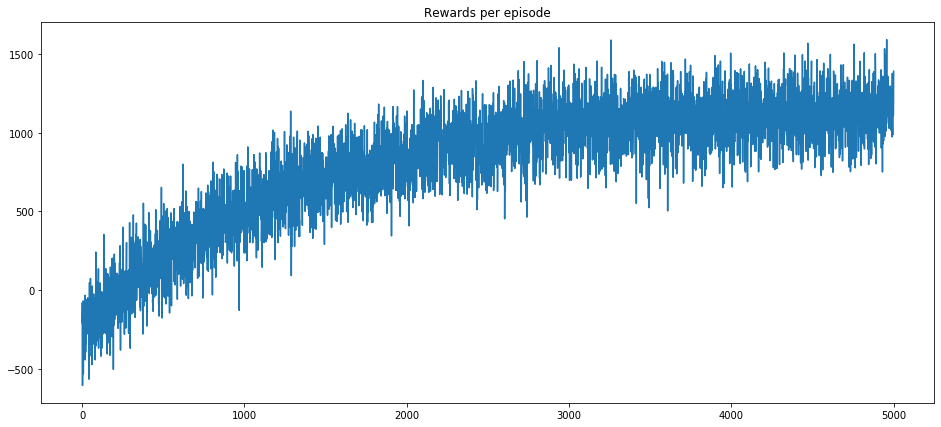

In [61]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
plt.plot(episodes,rewards_per_episode)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [62]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

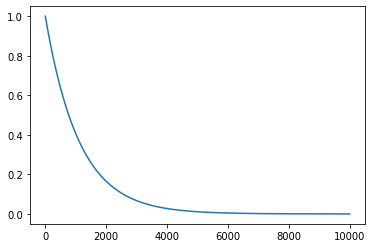

In [63]:
plt.plot(time, epsilon)
plt.show()